# PROJECT PIPELINE: MACHINE LEARNING–BASED ANALYSIS AND COMPARISON OF SPECIFIC CAPACITANCE FROM CV AND GCD

## 1. ENVIRONMENT SETUP AND DEPENDENCIES

### 1.1 VIRTUAL ENVIRONMENT PACKAGES (REQUIREMENTS.TXT)

THE FOLLOWING PACKAGES MUST BE INSTALLED IN YOUR VENV TO RUN THIS PIPELINE:

- PANDAS>=1.5.0
- NUMPY>=1.23.0
- MATPLOTLIB>=3.6.0
- SEABORN>=0.12.0
- SCIKIT-LEARN>=1.2.0
- XGBOOST>=1.7.0
- LIGHTGBM>=3.3.0
- SHAP>=0.41.0
- SCIPY>=1.9.0

### 1.2 GLOBAL IMPORTS AND VISUALIZATION STANDARDS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats

warnings.filterwarnings('ignore')

In [2]:
# -----------------------------------------------------------------------------
# GLOBAL VISUALIZATION STANDARDS
# -----------------------------------------------------------------------------
plt.rcParams.update({
    'figure.figsize': (8, 6),
    'figure.dpi': 500,
    'axes.grid': True,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'font.size': 12
})

## 2. DATA LOADING AND VALIDATION

### 2.1 LOAD DATASETS, CLEAN UNNAMED COLUMNS, AND DISPLAY SHAPE

In [3]:
def load_and_clean_data(cv_path: str, gcd_path: str) -> tuple:
    """
    LOADS CV AND GCD DATASETS, REMOVES UNNAMED COLUMNS,
    AND DISPLAYS BASIC SHAPE AND HEAD INFO.
    
    PARAMETERS:
    - cv_path: STRING PATH TO CV CSV
    - gcd_path: STRING PATH TO GCD CSV
    
    RETURNS:
    - TUPLE OF (CV_DATAFRAME, GCD_DATAFRAME)
    """
    cv_df = pd.read_csv(cv_path)
    gcd_df = pd.read_csv(gcd_path)
    
    # DROP UNNAMED COLUMNS IN CV DATA
    cv_df = cv_df.loc[:, ~cv_df.columns.str.contains('^Unnamed')]
    
    print("=== CV DATASET SHAPE ===")
    print(cv_df.shape)
    print("\n=== CV DATASET HEAD ===")
    display(cv_df.head())
    
    print("\n=== GCD DATASET SHAPE ===")
    print(gcd_df.shape)
    print("\n=== GCD DATASET HEAD ===")
    display(gcd_df.head())
    
    return cv_df, gcd_df

# EXECUTE DATA LOADING
cv_df, gcd_df = load_and_clean_data(
    '../../DATASET/DATA/KOH/AL203-1M-KOH-CV.csv',
    '../../DATASET/DATA/KOH/AL203-1M-KOH-GCD.csv'
)

=== CV DATASET SHAPE ===
(8752, 5)

=== CV DATASET HEAD ===


Scan_Rate  Potential  Current     Area        CS
0        100   -0.29984 -0.51050  2.41787  60.44685
1        100   -0.29885 -0.41119  2.41787  60.44685
2        100   -0.29786 -0.34692  2.41787  60.44685
3        100   -0.29380 -0.19546  2.41787  60.44685
4        100   -0.29284 -0.17072  2.41787  60.44685


=== GCD DATASET SHAPE ===
(3944, 5)

=== GCD DATASET HEAD ===


Current_Density          Time  Potential  Discharge_Time   GCD_CS
0              5.0 -3.170000e-07   -0.15928         2.88868  36.1085
1              5.0  1.000000e-01   -0.08898         2.88868  36.1085
2              5.0  2.000000e-01   -0.07416         2.88868  36.1085
3              5.0  3.000000e-01   -0.06734         2.88868  36.1085
4              5.0  4.000000e-01   -0.06165         2.88868  36.1085

### 2.2 VALIDATE MISSING VALUES, DUPLICATES, AND CS RANGE

In [4]:
def validate_data(df: pd.DataFrame, dataset_name: str, target_col: str):
    """
    CHECKS FOR MISSING VALUES, DUPLICATES, OUTLIERS, 
    AND VALIDATES TARGET VARIABLE (Cs) RANGE.
    """
    print(f"\n{'='*40}")
    print(f"DATA VALIDATION: {dataset_name.upper()}")
    print(f"{'='*40}")
    
    # MISSING VALUES
    missing_count = df.isnull().sum().sum()
    print(f"TOTAL MISSING VALUES: {missing_count}")
    
    # DUPLICATES
    duplicate_count = df.duplicated().sum()
    print(f"TOTAL DUPLICATE ROWS: {duplicate_count}")
    
    # VALIDATE CS (SPECIFIC CAPACITANCE)
    if target_col in df.columns:
        print(f"\n{target_col.upper()} (TARGET) SUMMARY STATISTICS:")
        display(df[target_col].describe())
        
        # OUTLIER DETECTION VIA Z-SCORE
        z_scores = np.abs(stats.zscore(df[target_col].dropna()))
        outliers = np.where(z_scores > 3)[0]
        print(f"DETECTED OUTLIERS IN {target_col.upper()} (Z > 3): {len(outliers)}")
    else:
        print(f"TARGET COLUMN '{target_col}' NOT FOUND.")

validate_data(cv_df, "CV Dataset", "CS")
validate_data(gcd_df, "GCD Dataset", "GCD_CS")


DATA VALIDATION: CV DATASET
TOTAL MISSING VALUES: 0
TOTAL DUPLICATE ROWS: 0

CS (TARGET) SUMMARY STATISTICS:


count    8752.000000
mean       71.759403
std         7.996925
min        60.446850
25%        64.487200
50%        70.618030
75%        78.711160
max        86.419420
Name: CS, dtype: float64

DETECTED OUTLIERS IN CS (Z > 3): 0

DATA VALIDATION: GCD DATASET
TOTAL MISSING VALUES: 0
TOTAL DUPLICATE ROWS: 0

GCD_CS (TARGET) SUMMARY STATISTICS:


count    3944.000000
mean       45.440003
std         3.206760
min        36.108500
25%        44.553500
50%        46.711120
75%        47.745620
max        47.745620
Name: GCD_CS, dtype: float64

DETECTED OUTLIERS IN GCD_CS (Z > 3): 0


# 3. FEATURE ENGINEERING AND MERGING

### 3.1 CORRECTED FEATURE ENGINEERING

In [5]:
def engineer_features(cv_df: pd.DataFrame, gcd_df: pd.DataFrame) -> pd.DataFrame:
    """
    STANDARDIZES COLUMN NAMES, CREATES METHOD FLAGS, 
    DERIVES NEW ELECTROCHEMICAL FEATURES, AND MERGES BOTH DATASETS.
    
    NOTE: CURRENT IN CV DATASET IS ALREADY THE CURRENT DENSITY.
    """
    # 1. RENAME TARGET AND COMMON COLUMNS
    cv_clean = cv_df.rename(columns={'CS': 'Cs', 'Current': 'Current_Density'})
    gcd_clean = gcd_df.rename(columns={'GCD_CS': 'Cs'})
    
    # 2. METHOD FLAGS
    cv_clean['Method'] = 'CV'
    gcd_clean['Method'] = 'GCD'
    
    # 3. DERIVE POTENTIAL WINDOW FOR CV
    cv_clean['Potential_Window'] = cv_clean.groupby('Scan_Rate')['Potential'].transform(lambda x: x.max() - x.min())
    
    # 4. DERIVE POTENTIAL WINDOW FOR GCD
    gcd_clean['Potential_Window'] = gcd_clean.groupby('Current_Density')['Potential'].transform(lambda x: x.max() - x.min())
    
    # 5. MERGE DATASETS
    # KEEPING DOMAIN-SPECIFIC COLUMNS (PADDED WITH NAN FOR THE OTHER METHOD)
    unified_df = pd.concat([cv_clean, gcd_clean], ignore_index=True)
    
    print(f"=== UNIFIED DATASET SHAPE: {unified_df.shape} ===")
    
    return unified_df, cv_clean, gcd_clean

unified_df, cv_clean, gcd_clean = engineer_features(cv_df, gcd_df)

=== UNIFIED DATASET SHAPE: (12696, 9) ===


In [6]:
unified_df

Scan_Rate  Potential  Current_Density     Area        Cs Method  \
0          100.0   -0.29984         -0.51050  2.41787  60.44685     CV   
1          100.0   -0.29885         -0.41119  2.41787  60.44685     CV   
2          100.0   -0.29786         -0.34692  2.41787  60.44685     CV   
3          100.0   -0.29380         -0.19546  2.41787  60.44685     CV   
4          100.0   -0.29284         -0.17072  2.41787  60.44685     CV   
...          ...        ...              ...      ...       ...    ...   
12691        NaN   -0.28868          0.25000      NaN  47.74562    GCD   
12692        NaN   -0.29243          0.25000      NaN  47.74562    GCD   
12693        NaN   -0.29627          0.25000      NaN  47.74562    GCD   
12694        NaN   -0.29904          0.25000      NaN  47.74562    GCD   
12695        NaN   -0.29990          0.25000      NaN  47.74562    GCD   

       Potential_Window      Time  Discharge_Time  
0               0.40035       NaN             NaN  
1               0.40035       NaN             NaN  
2               0.40035       NaN             NaN  
3               0.40035       NaN             NaN  
4               0.40035       NaN             NaN  
...                 ...       ...             ...  
12691           0.39971  180.3960          76.393  
12692           0.39971  180.4960          76.393  
12693           0.39971  180.5960          76.393  
12694           0.39971  180.6396          76.393  
12695           0.39971  180.6398          76.393  

[12696 rows x 9 columns]

## 3.2 DATA PREPROCESSING ON UNIFIED DATASET

In [7]:
def preprocess_data(unified_df: pd.DataFrame) -> pd.DataFrame:
    """
    HANDLES MISSING VALUES, CHECKS FOR OUTLIERS IN TARGET VARIABLE (Cs),
    AND PREPARES THE CLEANED COMBINED DATASET FOR VISUALIZATION AND MODELING.
    """
    print("=== STARTING PREPROCESSING ===")
    
    # 1. MISSING VALUE ANALYSIS
    print("\nMISSING VALUES PER COLUMN (EXPECTED DUE TO METHOD SPECIFIC FEATURES):")
    print(unified_df.isnull().sum())
    
    # NOTE: WE DO NOT DROP NANS IN 'SCAN_RATE' OR 'TIME' BECAUSE THEY ARE 
    # METHOD-DEPENDENT (CV HAS SCAN_RATE, GCD HAS TIME). WE LEAVE THEM AS IS 
    # FOR EXPLORATORY ANALYSIS AND WILL HANDLE THEM DURING METHOD-SPECIFIC MODELING.
    
    # 2. OUTLIER DETECTION IN Cs (TARGET) USING IQR
    Q1 = unified_df['Cs'].quantile(0.25)
    Q3 = unified_df['Cs'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = unified_df[(unified_df['Cs'] < lower_bound) | (unified_df['Cs'] > upper_bound)]
    print(f"\nDETECTED OUTLIERS IN Cs (IQR METHOD): {len(outliers)}")
    
    if len(outliers) > 0:
        print("OUTLIERS FOUND. DEPENDING ON ELECTROCHEMICAL CONTEXT, THESE MIGHT BE REMOVED.")
        # UNCOMMENT TO DROP OUTLIERS:
        # unified_df = unified_df[~((unified_df['Cs'] < lower_bound) | (unified_df['Cs'] > upper_bound))]
    else:
        print("NO OUTLIERS DETECTED IN Cs. DATA IS CLEAN AND STABLE.")
        
    print(f"\n=== FINAL CLEANED DATASET SHAPE: {unified_df.shape} ===")
    return unified_df

cleaned_unified_df = preprocess_data(unified_df)

=== STARTING PREPROCESSING ===

MISSING VALUES PER COLUMN (EXPECTED DUE TO METHOD SPECIFIC FEATURES):
Scan_Rate           3944
Potential              0
Current_Density        0
Area                3944
Cs                     0
Method                 0
Potential_Window       0
Time                8752
Discharge_Time      8752
dtype: int64

DETECTED OUTLIERS IN Cs (IQR METHOD): 0
NO OUTLIERS DETECTED IN Cs. DATA IS CLEAN AND STABLE.

=== FINAL CLEANED DATASET SHAPE: (12696, 9) ===


## 4. EXPLORATORY DATA ANALYSIS AND VISUALIZATION (ON CLEANED DATA)

### 4.1 DISTRIBUTION AND METHOD COMPARISON FOR Cs

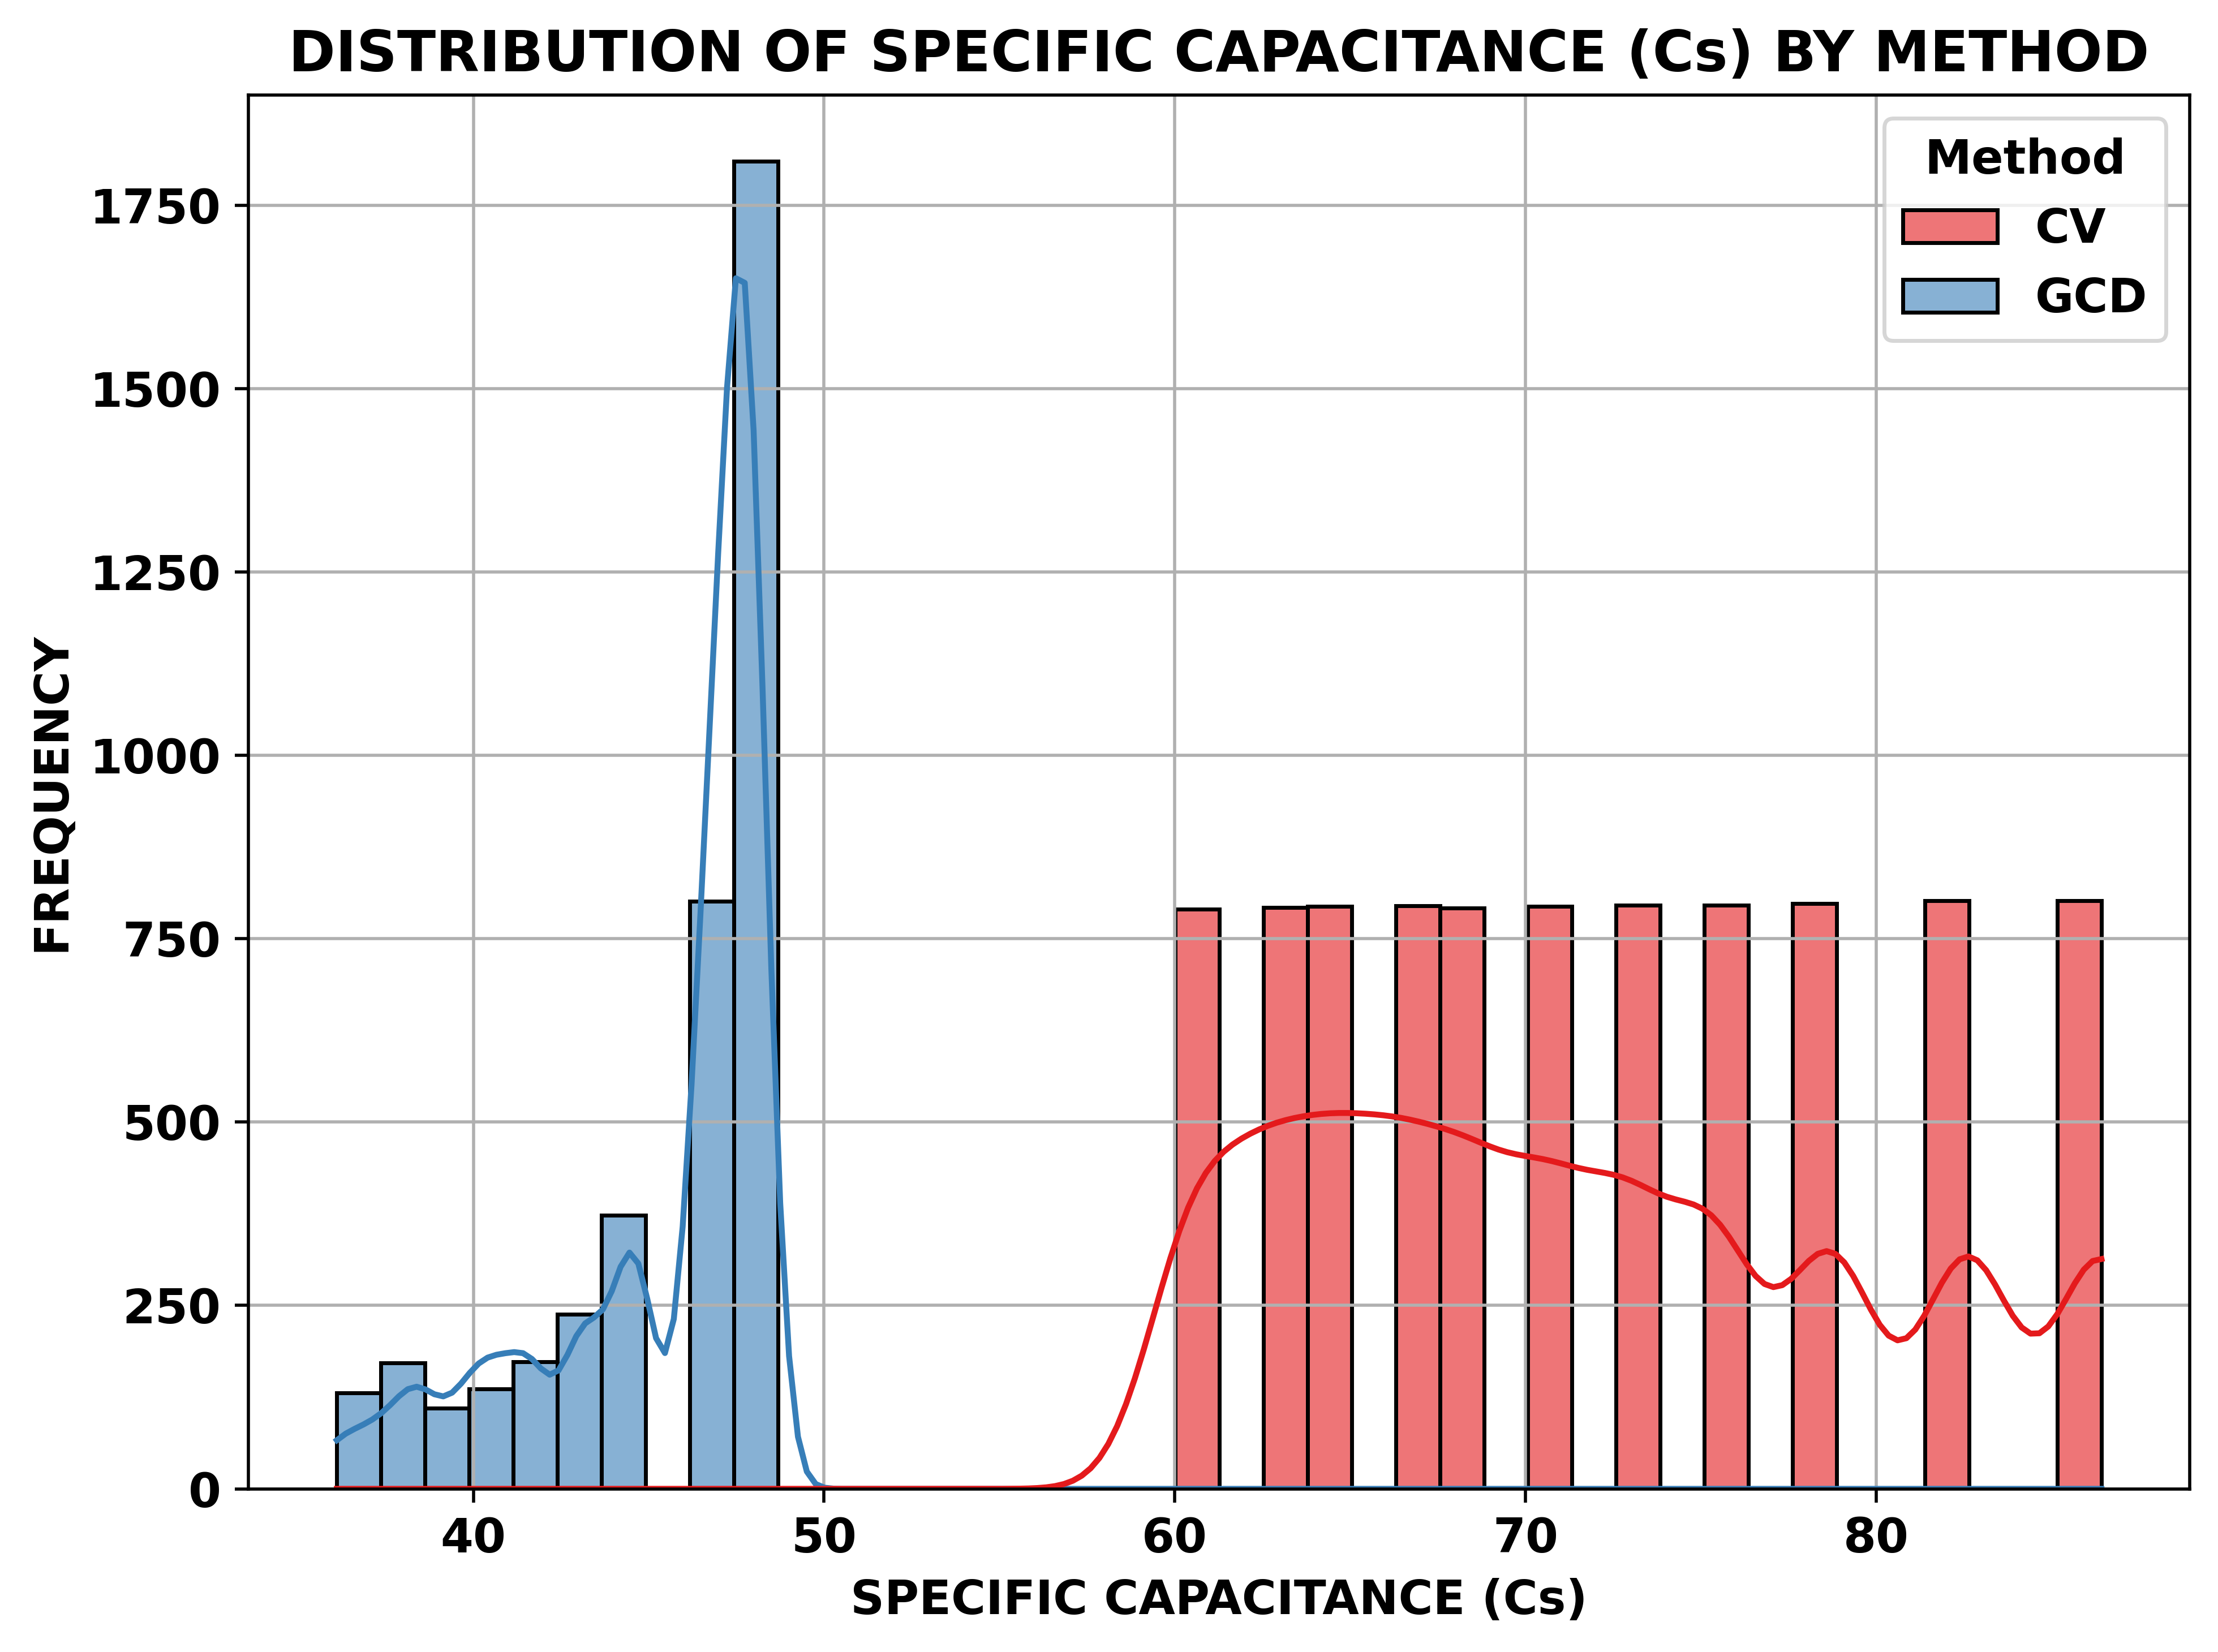

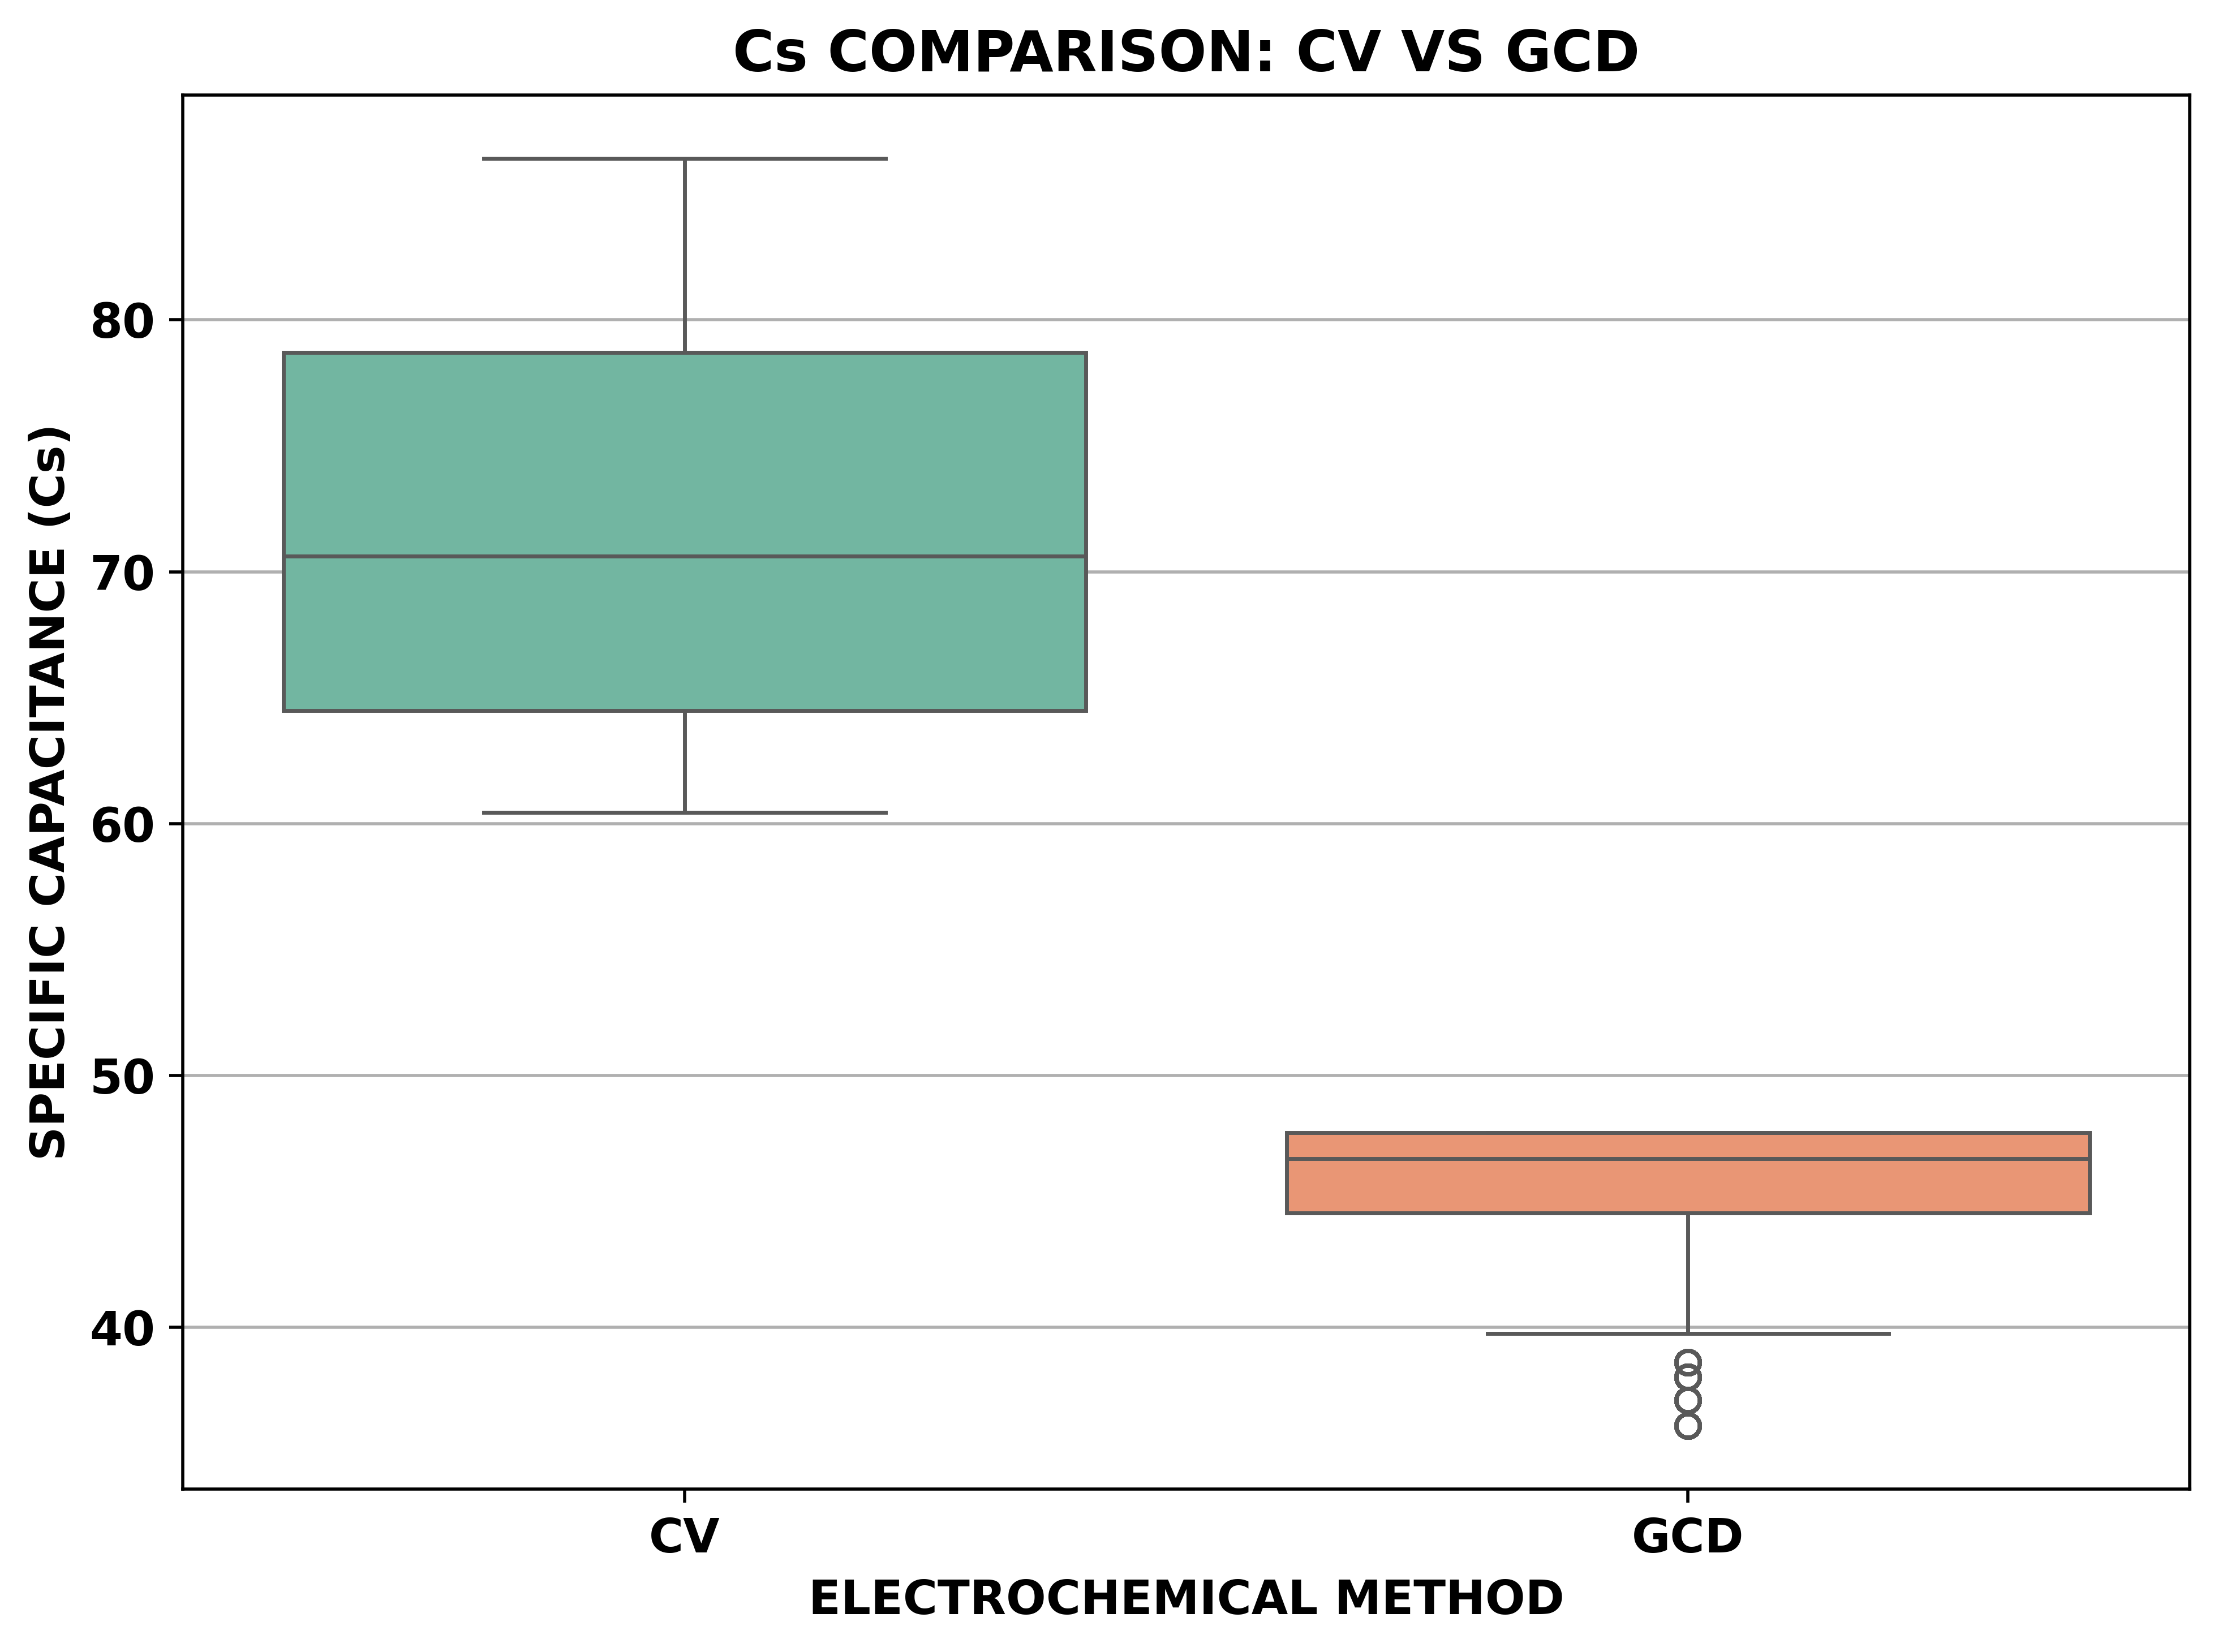

In [8]:
def plot_cleaned_distributions(df: pd.DataFrame):
    """
    RE-RUNS DISTRIBUTION VISUALIZATIONS ON THE PRE-PROCESSED UNIFIED DATASET.
    """
    # HISTOGRAM
    plt.figure()
    sns.histplot(data=df, x='Cs', hue='Method', kde=True, palette='Set1', bins=40, alpha=0.6)
    plt.title('DISTRIBUTION OF SPECIFIC CAPACITANCE (Cs) BY METHOD')
    plt.xlabel('SPECIFIC CAPACITANCE (Cs)')
    plt.ylabel('FREQUENCY')
    plt.tight_layout()
    plt.show()

    # BOXPLOT
    plt.figure()
    sns.boxplot(data=df, x='Method', y='Cs', palette='Set2')
    plt.title('Cs COMPARISON: CV VS GCD')
    plt.xlabel('ELECTROCHEMICAL METHOD')
    plt.ylabel('SPECIFIC CAPACITANCE (Cs)')
    plt.tight_layout()
    plt.show()

plot_cleaned_distributions(cleaned_unified_df)

### 4.2 UPDATED CV AND GCD ELECTROCHEMICAL VISUALIZATIONS

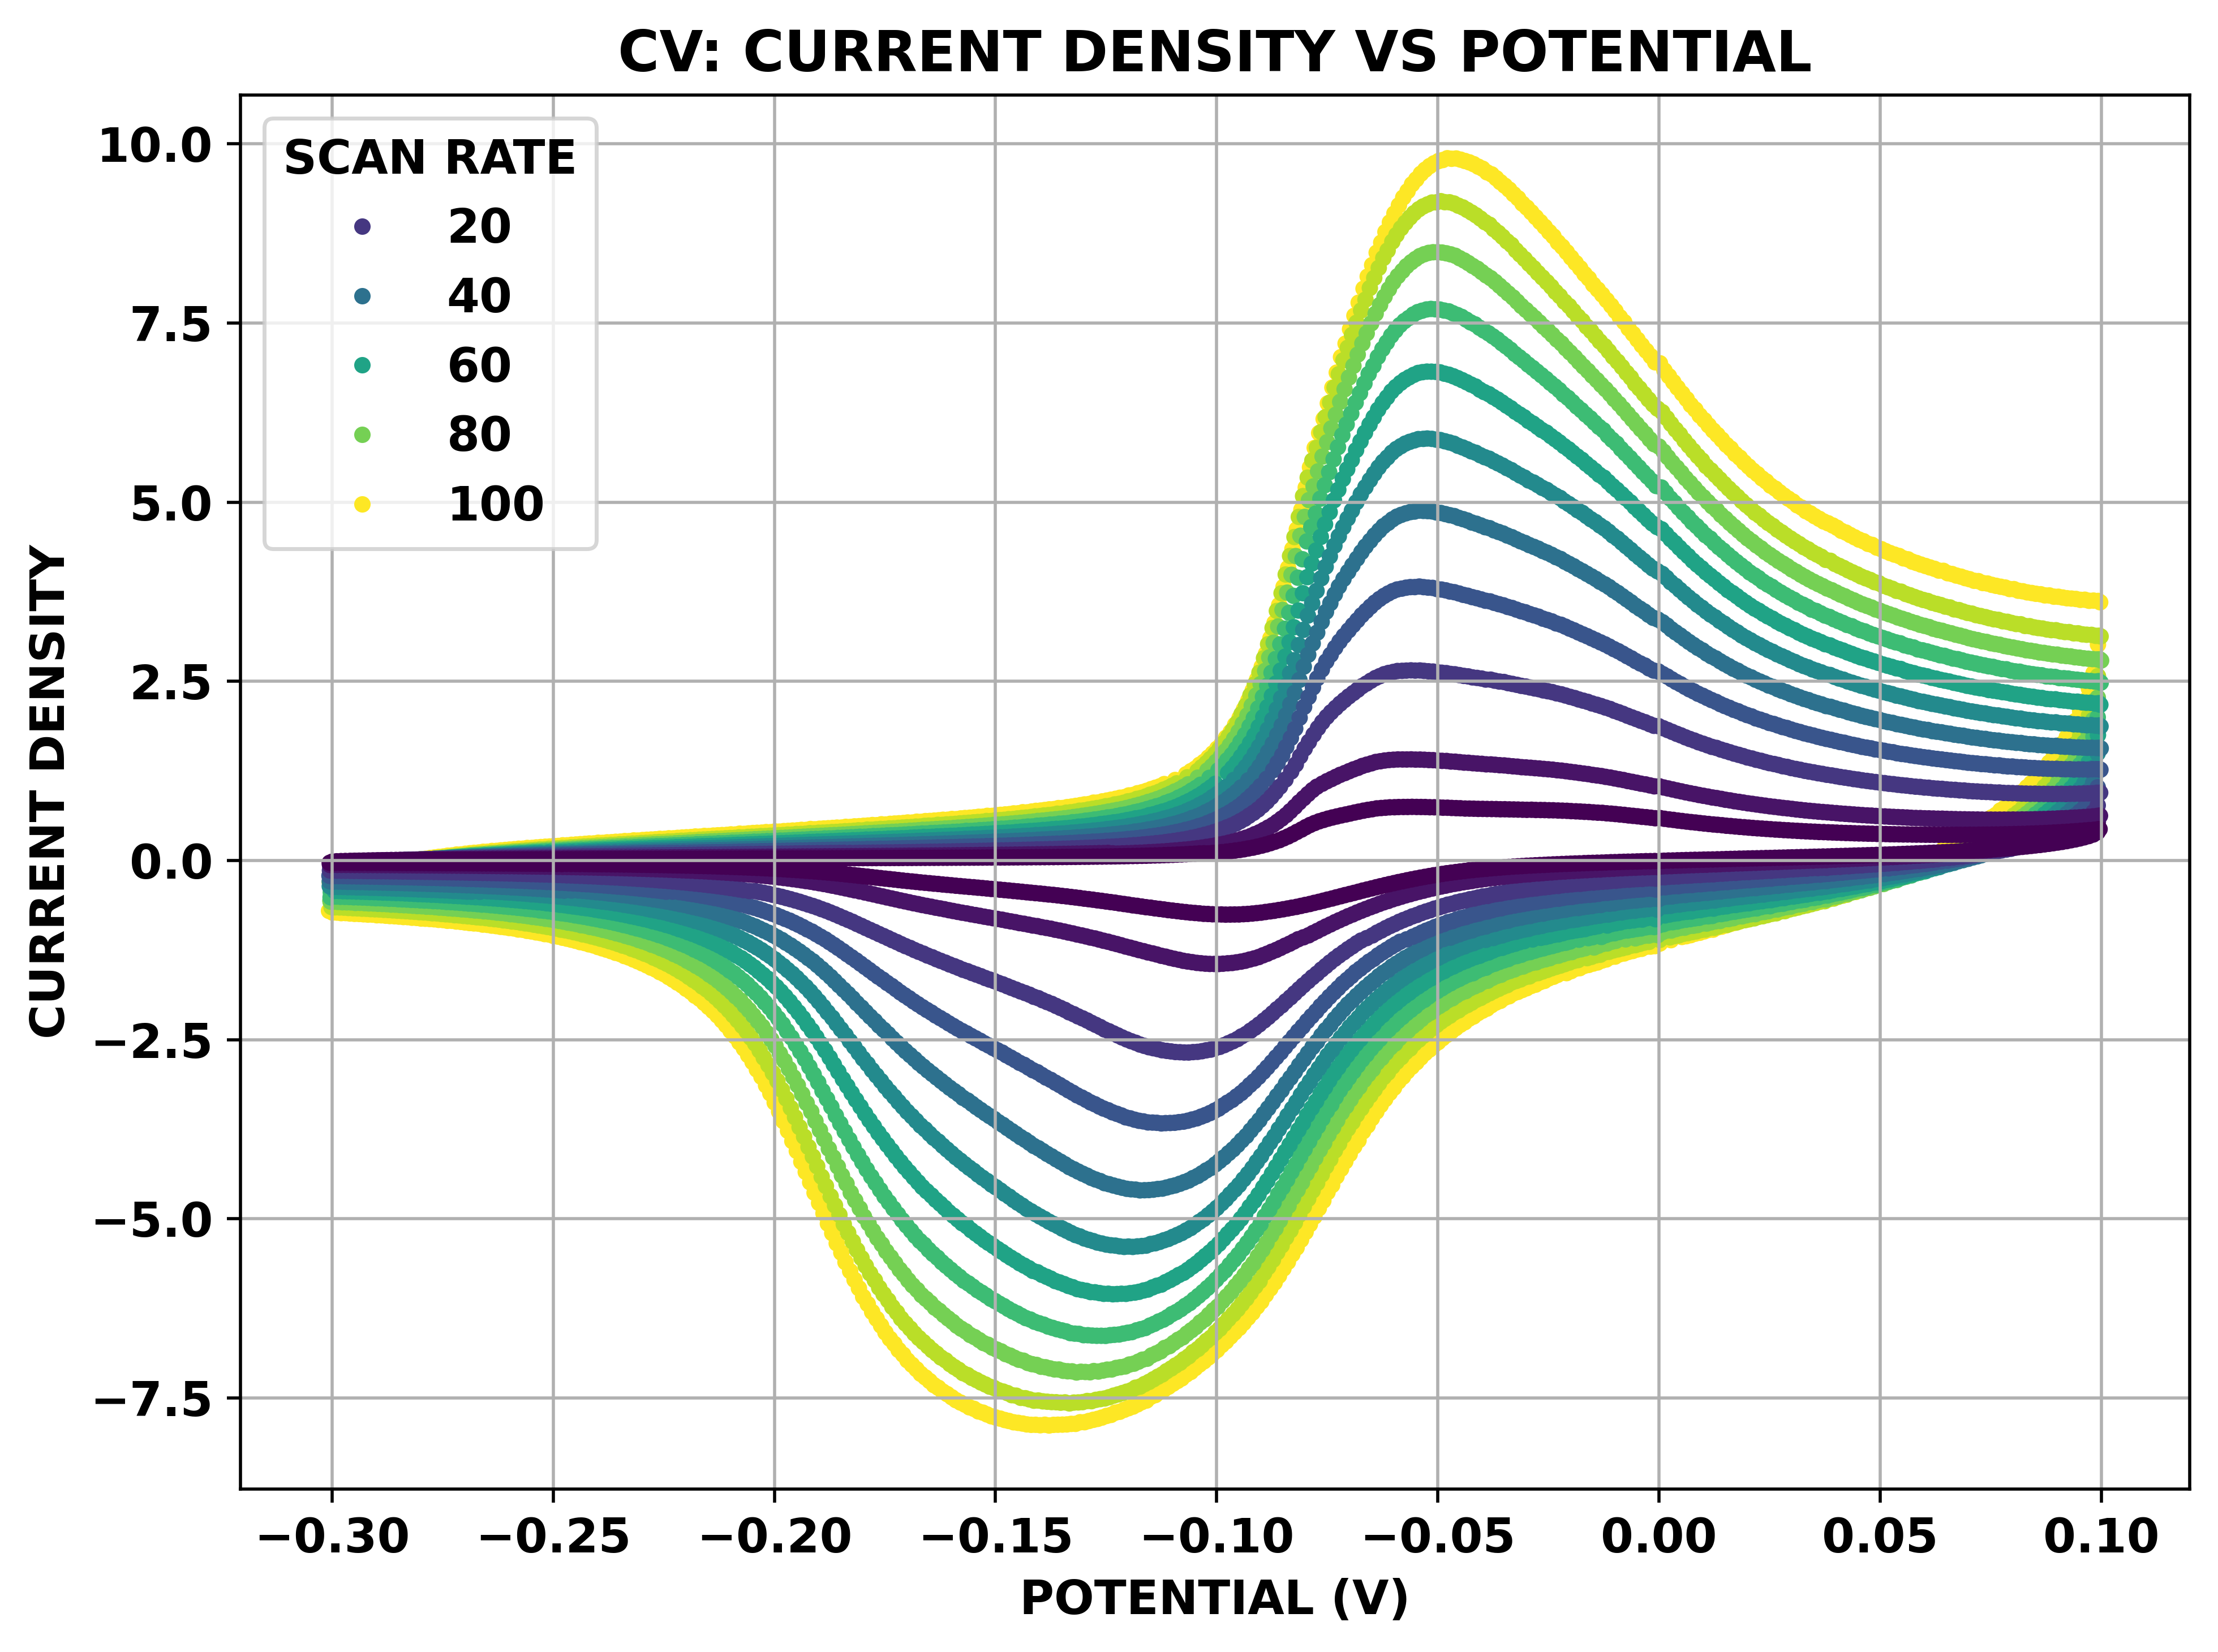

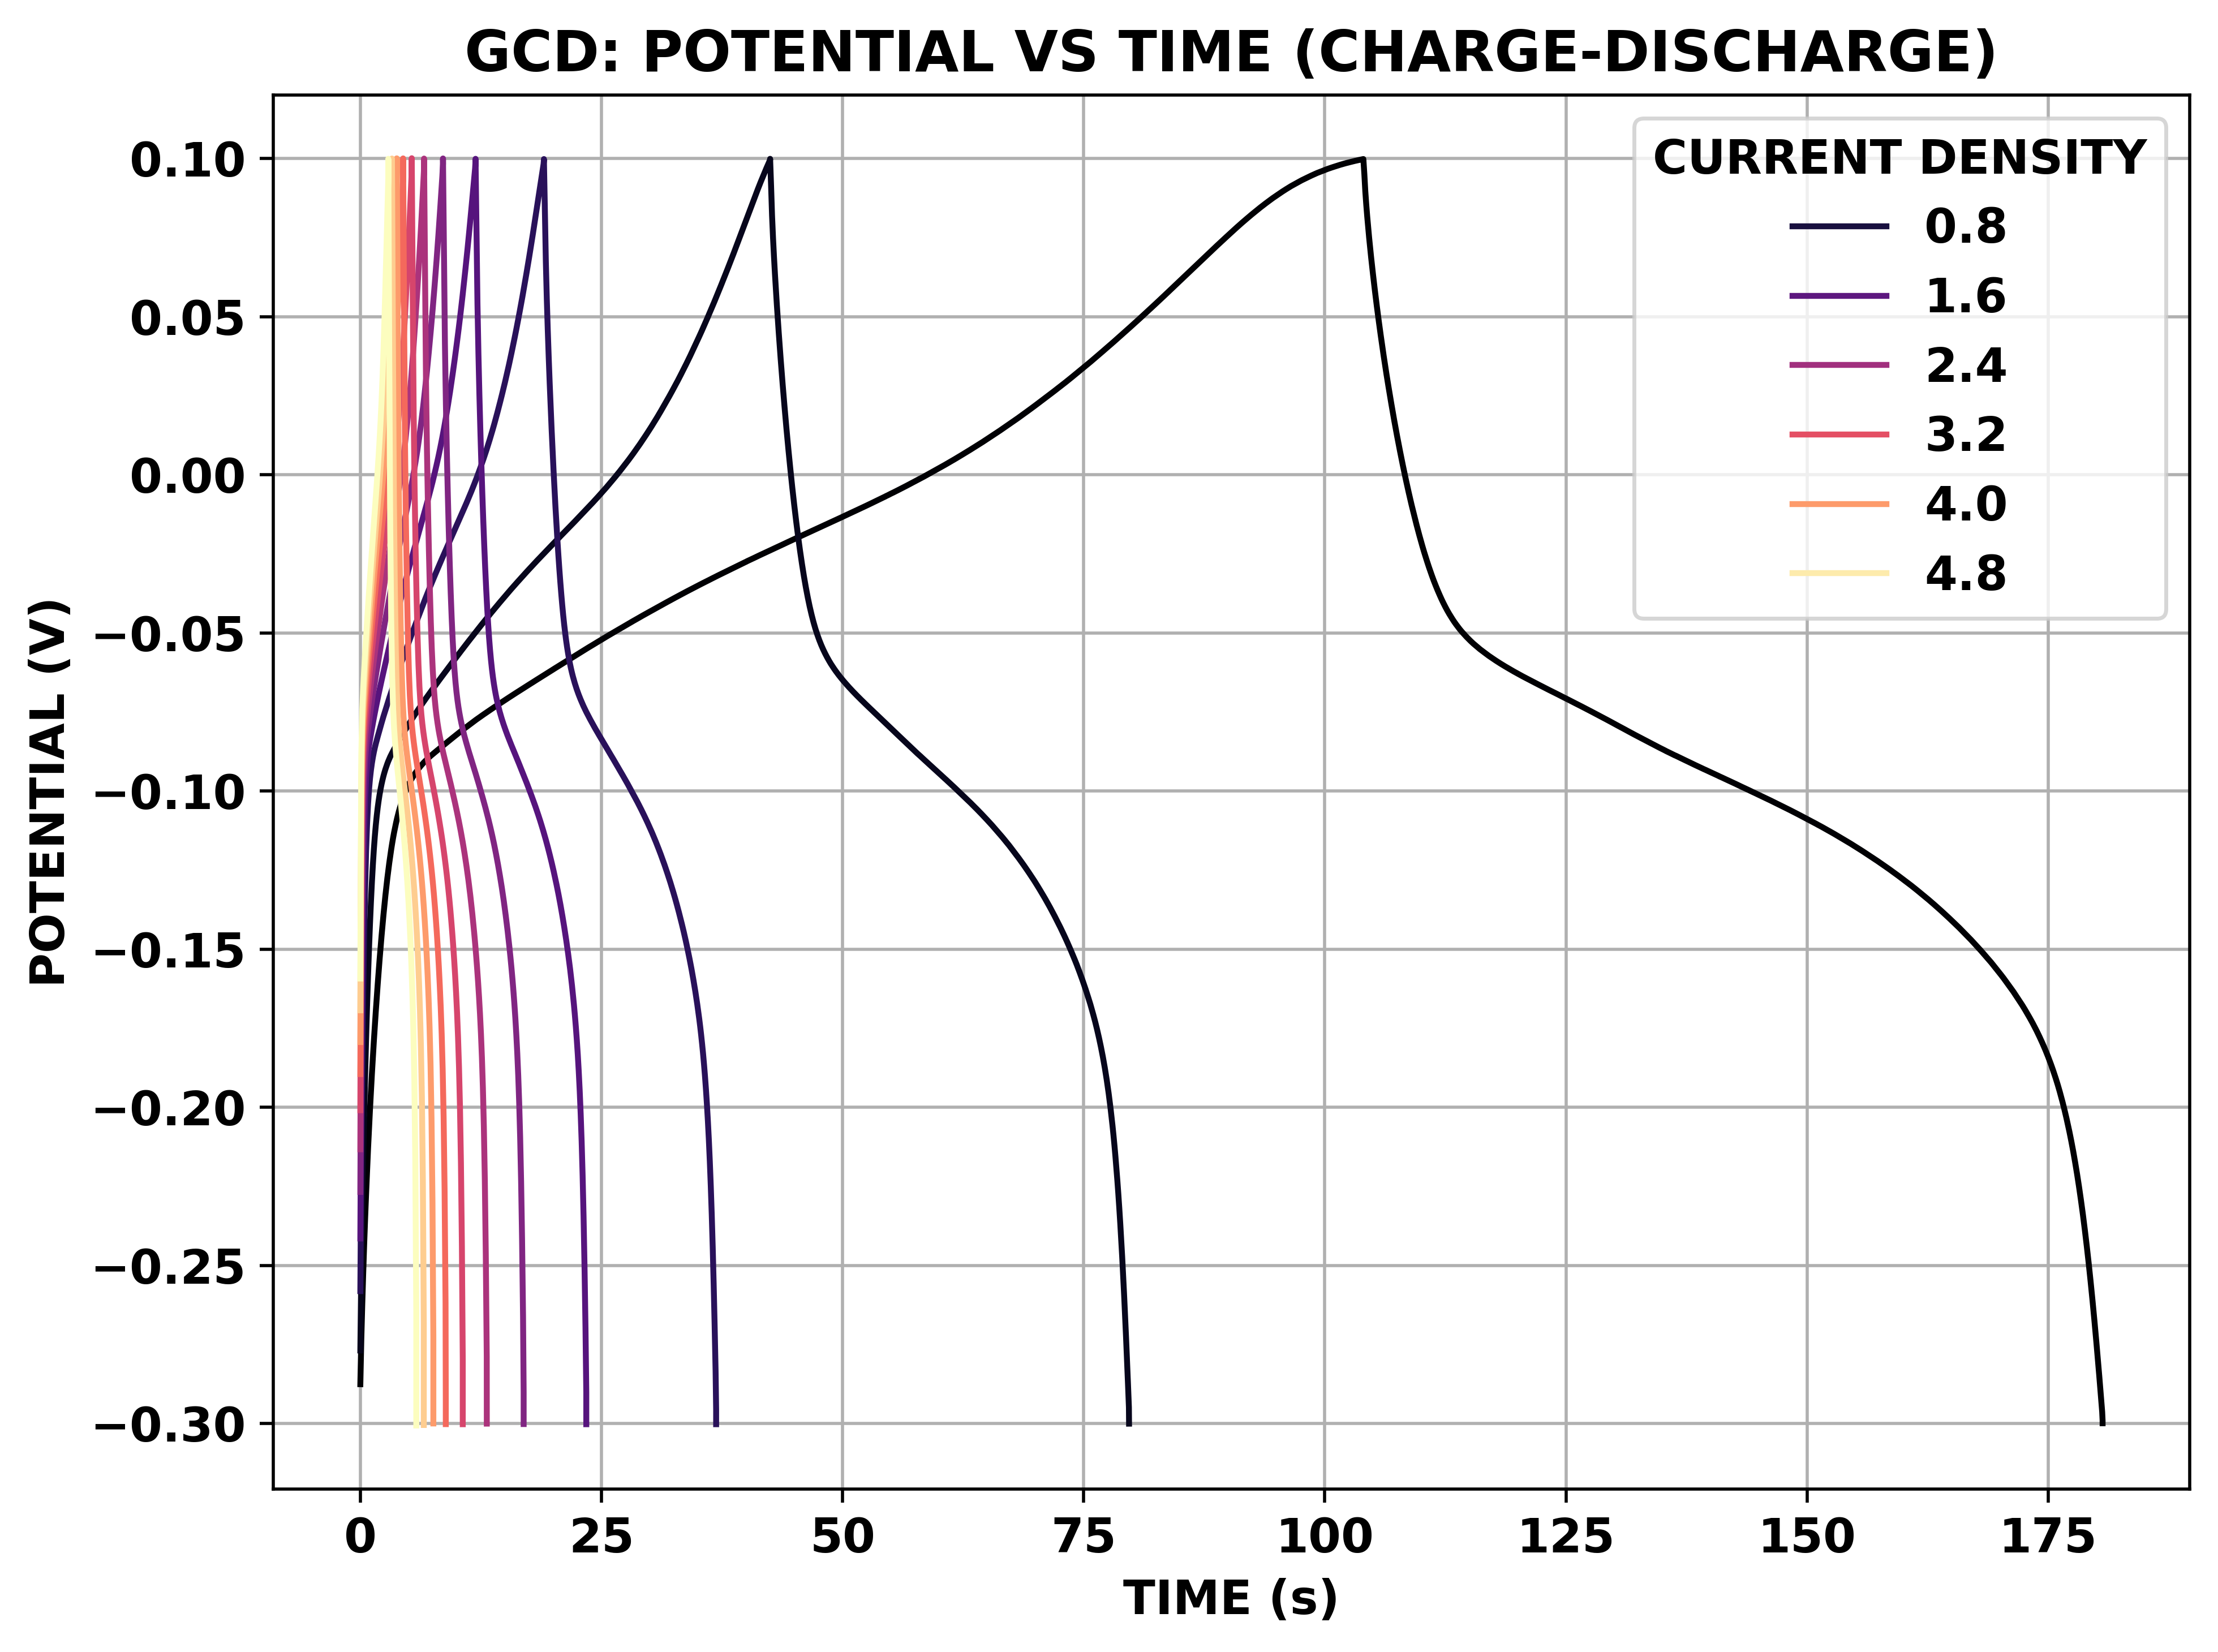

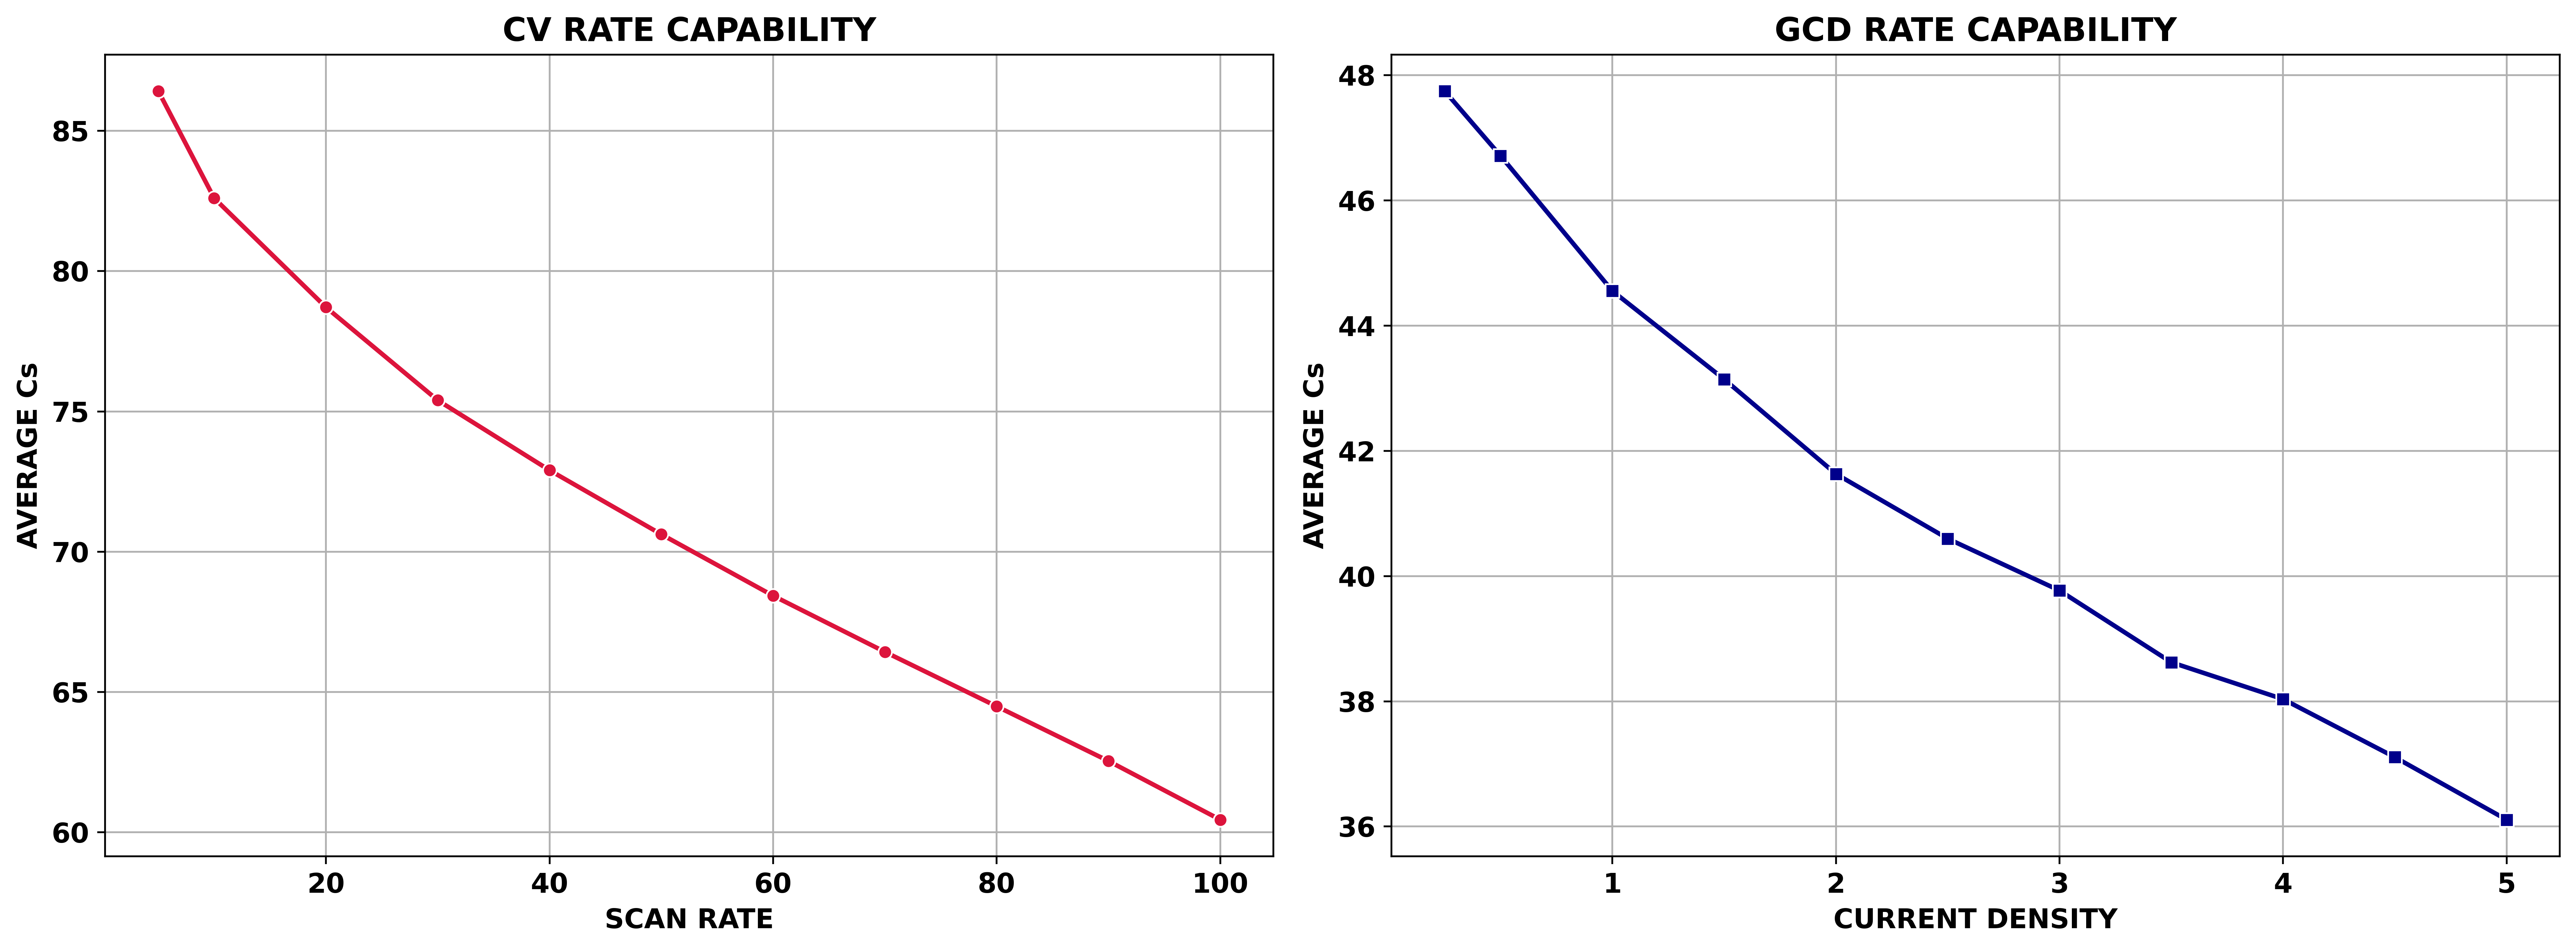

In [9]:
def plot_updated_electrochemistry(df: pd.DataFrame):
    """
    PLOTS CV AND GCD ELECTROCHEMICAL BEHAVIOR USING THE CLEANED DATASET.
    """
    cv_data = df[df['Method'] == 'CV']
    gcd_data = df[df['Method'] == 'GCD']
    
    # 1. CV: CURRENT DENSITY VS POTENTIAL
    plt.figure()
    sns.scatterplot(data=cv_data, x='Potential', y='Current_Density', hue='Scan_Rate', palette='viridis', s=15, edgecolor=None)
    plt.title('CV: CURRENT DENSITY VS POTENTIAL')
    plt.xlabel('POTENTIAL (V)')
    plt.ylabel('CURRENT DENSITY')
    plt.legend(title='SCAN RATE')
    plt.tight_layout()
    plt.show()

    # 2. GCD: POTENTIAL VS TIME
    plt.figure()
    sns.lineplot(data=gcd_data, x='Time', y='Potential', hue='Current_Density', palette='magma')
    plt.title('GCD: POTENTIAL VS TIME (CHARGE-DISCHARGE)')
    plt.xlabel('TIME (s)')
    plt.ylabel('POTENTIAL (V)')
    plt.legend(title='CURRENT DENSITY')
    plt.tight_layout()
    plt.show()
    
    # 3. RATE CAPABILITY COMPARISON
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # CV RATE CAPABILITY
    cv_rate = cv_data.groupby('Scan_Rate')['Cs'].mean().reset_index()
    sns.lineplot(data=cv_rate, x='Scan_Rate', y='Cs', marker='o', color='crimson', linewidth=2, ax=axes[0])
    axes[0].set_title('CV RATE CAPABILITY')
    axes[0].set_xlabel('SCAN RATE')
    axes[0].set_ylabel('AVERAGE Cs')
    
    # GCD RATE CAPABILITY
    gcd_rate = gcd_data.groupby('Current_Density')['Cs'].mean().reset_index()
    sns.lineplot(data=gcd_rate, x='Current_Density', y='Cs', marker='s', color='darkblue', linewidth=2, ax=axes[1])
    axes[1].set_title('GCD RATE CAPABILITY')
    axes[1].set_xlabel('CURRENT DENSITY')
    axes[1].set_ylabel('AVERAGE Cs')
    
    plt.tight_layout()
    plt.show()

plot_updated_electrochemistry(cleaned_unified_df)

### 4.3 CORRELATION AND FEATURE IMPORTANCE (STATISTICAL)

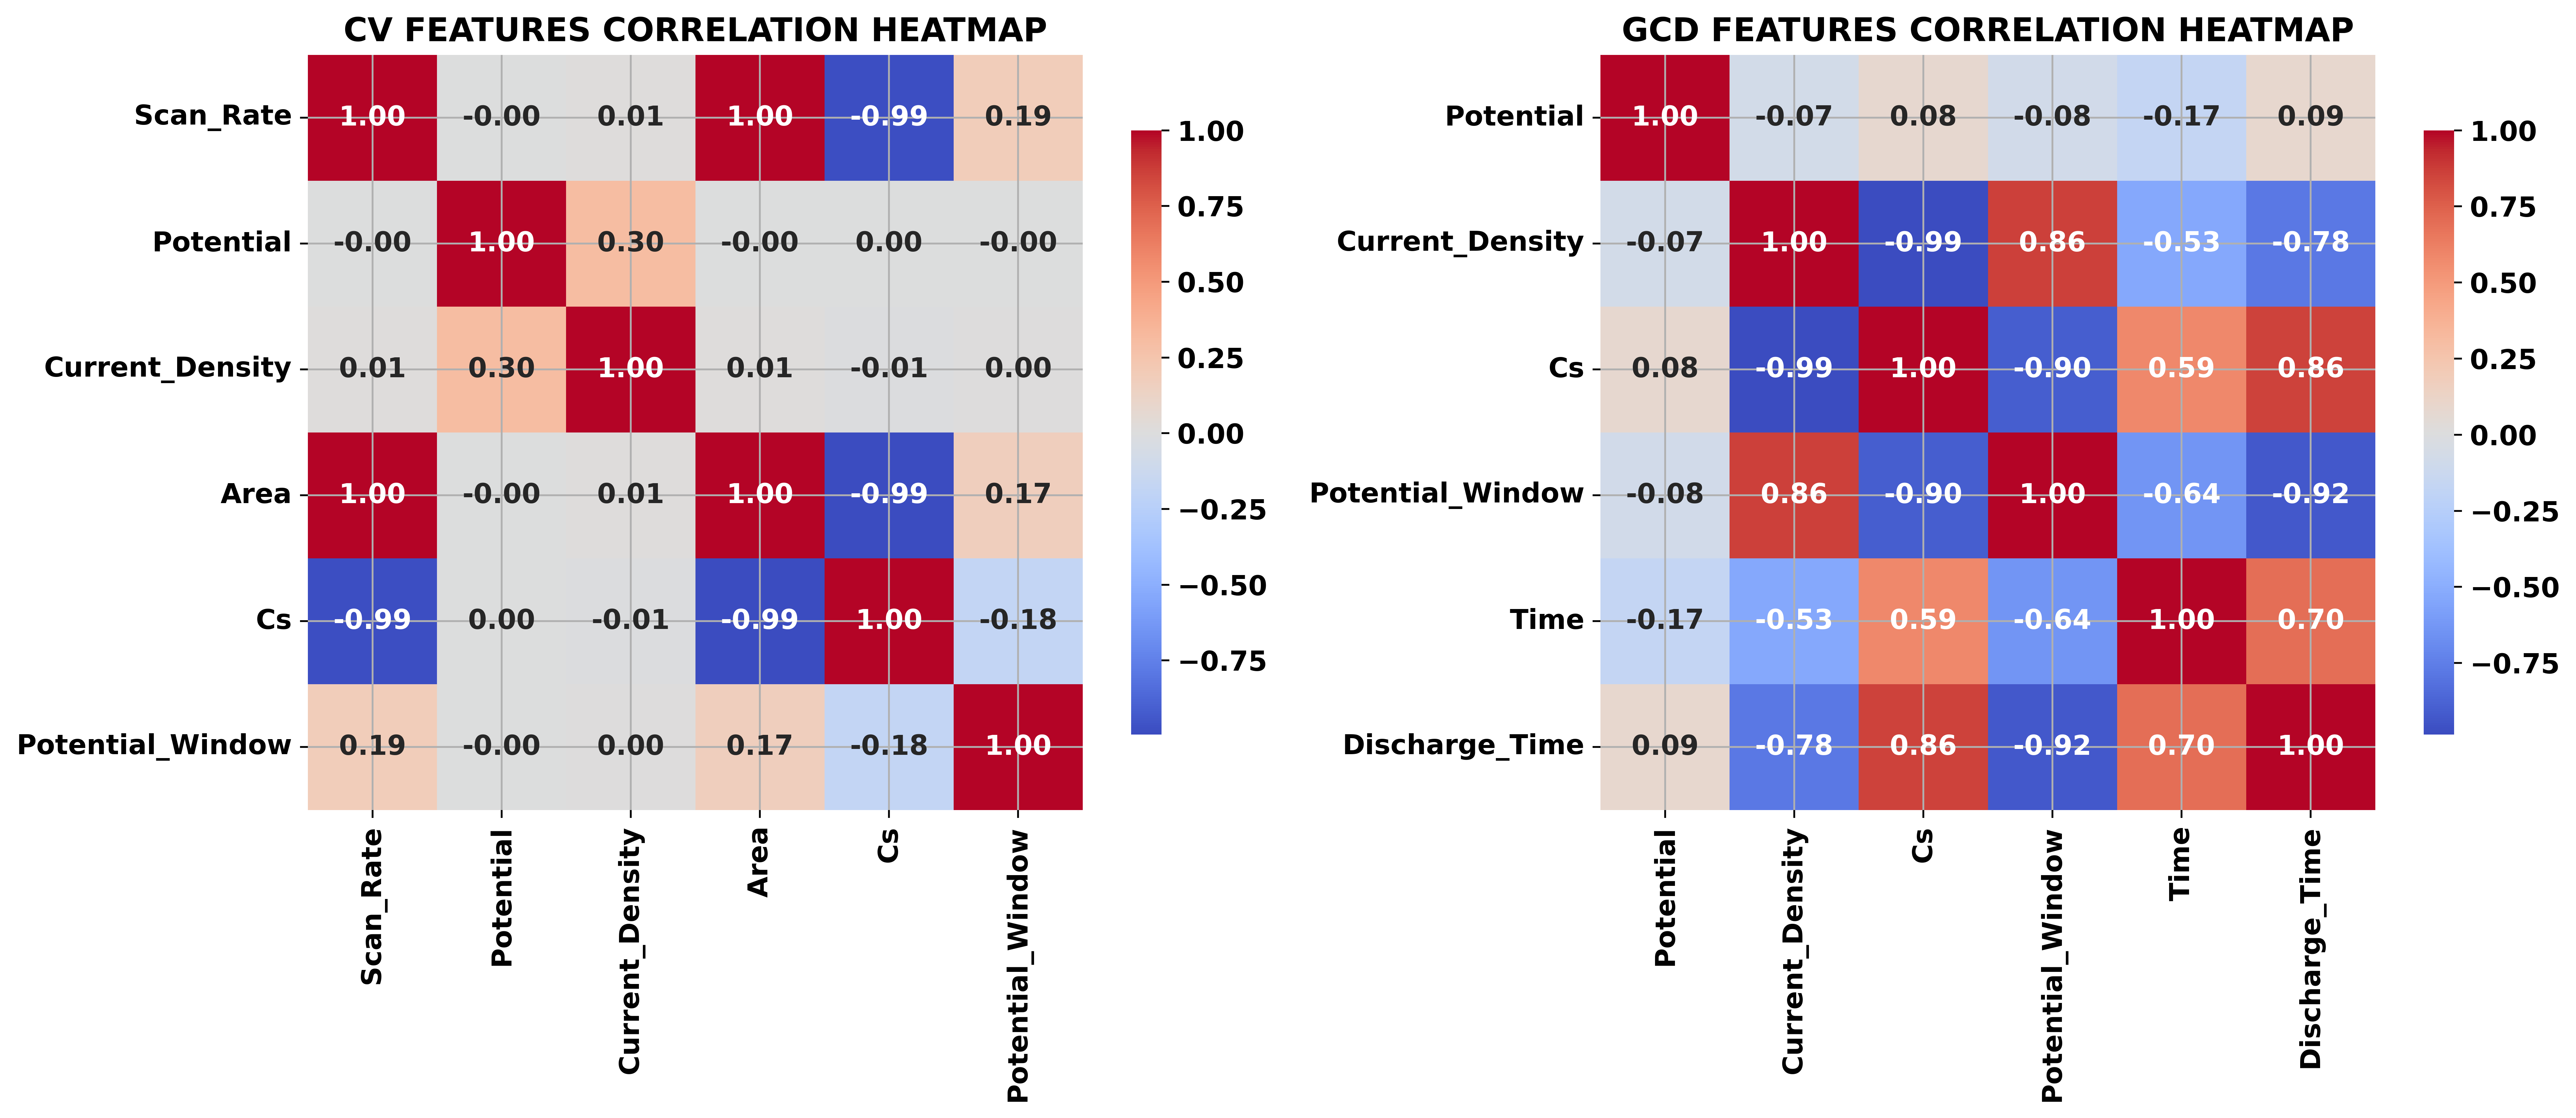

In [10]:
def plot_correlation_matrices_cleaned(df: pd.DataFrame):
    """
    PLOTS PEARSON CORRELATION HEATMAPS FOR THE PREPROCESSED DATA.
    """
    cv_numeric = df[df['Method'] == 'CV'].select_dtypes(include=[np.number]).dropna(axis=1, how='all')
    gcd_numeric = df[df['Method'] == 'GCD'].select_dtypes(include=[np.number]).dropna(axis=1, how='all')

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    sns.heatmap(cv_numeric.corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[0], cbar_kws={'shrink': .8})
    axes[0].set_title('CV FEATURES CORRELATION HEATMAP')

    sns.heatmap(gcd_numeric.corr(method='pearson'), annot=True, cmap='coolwarm', fmt=".2f", ax=axes[1], cbar_kws={'shrink': .8})
    axes[1].set_title('GCD FEATURES CORRELATION HEATMAP')

    plt.tight_layout()
    plt.show()

plot_correlation_matrices_cleaned(cleaned_unified_df)

# 5. MACHINE LEARNING MODELING (REVISED: LEAKAGE-FREE)

### 5.1 DATA PREPARATION USING GROUP SHUFFLE SPLIT & ROBUST SCALING

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ALGORITHMS
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import RobustScaler

In [38]:
def prepare_leakage_free_data(df: pd.DataFrame) -> dict:
    """
    PREPARES DATA USING GROUP-BASED SPLITTING TO PREVENT LEAKAGE 
    FROM REPEATED TARGET VARIABLES IN TIME-SERIES ELECTROCHEMISTRY DATA.
    INCLUDES AREA (CV) AND DISCHARGE TIME (GCD) IN THE COMBINED MODEL.
    """
    print("=== PREPARING LEAKAGE-FREE DATA SPLITS ===")
    
    # 1. CV-ONLY
    cv_data = df[df['Method'] == 'CV'].dropna(axis=1, how='all').dropna()
    X_cv = cv_data[['Scan_Rate', 'Potential', 'Current_Density', 'Area', 'Potential_Window']]
    y_cv = cv_data['Cs']
    groups_cv = cv_data['Scan_Rate']
    
    gss_cv = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx_cv, test_idx_cv = next(gss_cv.split(X_cv, y_cv, groups_cv))
    
    # 2. GCD-ONLY (NOTE: ADDED DISCHARGE_TIME BACK TO YOUR X_gcd)
    gcd_data = df[df['Method'] == 'GCD'].dropna(axis=1, how='all').dropna()
    X_gcd = gcd_data[['Current_Density', 'Time', 'Potential', 'Discharge_Time', 'Potential_Window']]
    y_gcd = gcd_data['Cs']
    groups_gcd = gcd_data['Current_Density']
    
    gss_gcd = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx_gcd, test_idx_gcd = next(gss_gcd.split(X_gcd, y_gcd, groups_gcd))
    
    # 3. COMBINED
    df_comb = df.dropna(subset=['Cs', 'Method', 'Potential', 'Current_Density', 'Potential_Window']).copy()
    df_comb['Experiment_Group'] = df_comb['Scan_Rate'].fillna(0).astype(str) + "_" + df_comb['Current_Density'].astype(str) + "_" + df_comb['Method']
    
    # ADD AREA AND DISCHARGE_TIME TO THE COMBINED DATASET
    X_comb = df_comb[['Current_Density', 'Potential', 'Potential_Window', 'Area', 'Discharge_Time', 'Method']]
    
    # FILL THE METHOD-SPECIFIC NaNs WITH 0 SO THE ML MODEL DOES NOT CRASH
    X_comb['Area'] = X_comb['Area'].fillna(0)
    X_comb['Discharge_Time'] = X_comb['Discharge_Time'].fillna(0)
    
    X_comb_encoded = pd.get_dummies(X_comb, columns=['Method'], drop_first=True)
    y_comb = df_comb['Cs']
    groups_comb = df_comb['Experiment_Group']
    
    gss_comb = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx_comb, test_idx_comb = next(gss_comb.split(X_comb_encoded, y_comb, groups_comb))
    
    return {
        'CV': (X_cv.iloc[train_idx_cv], X_cv.iloc[test_idx_cv], y_cv.iloc[train_idx_cv], y_cv.iloc[test_idx_cv]),
        'GCD': (X_gcd.iloc[train_idx_gcd], X_gcd.iloc[test_idx_gcd], y_gcd.iloc[train_idx_gcd], y_gcd.iloc[test_idx_gcd]),
        'COMBINED': (X_comb_encoded.iloc[train_idx_comb], X_comb_encoded.iloc[test_idx_comb], y_comb.iloc[train_idx_comb], y_comb.iloc[test_idx_comb])
    }

data_splits_robust = prepare_leakage_free_data(cleaned_unified_df)

=== PREPARING LEAKAGE-FREE DATA SPLITS ===


### 5.2 HIGH-PRECISION BENCHMARKING (8 DECIMAL PLACES)

In [39]:
def benchmark_models_precision(X_train, X_test, y_train, y_test, dataset_name: str) -> pd.DataFrame:
    """
    BENCHMARKS MODELS AND PRINTS METRICS TO 8 DECIMAL PLACES TO DETECT MICRO-VARIANCES.
    """
    print(f"\n=== HIGH-PRECISION BENCHMARK: {dataset_name.upper()} ===")
    
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
    }
    
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = []
    
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        
        results.append({
            'MODEL': name,
            'R²': f"{r2_score(y_test, preds):.8f}",
            'RMSE': f"{np.sqrt(mean_squared_error(y_test, preds)):.8f}",
            'MAE': f"{mean_absolute_error(y_test, preds):.8f}",
            'MSE': f"{mean_squared_error(y_test, preds):.8f}"
        })
            
    results_df = pd.DataFrame(results).sort_values(by='R²', ascending=False).reset_index(drop=True)
    display(results_df)
    return results_df

cv_results = benchmark_models_precision(*data_splits_robust['CV'], 'CV-Only Dataset')
gcd_results = benchmark_models_precision(*data_splits_robust['GCD'], 'GCD-Only Dataset')
comb_results = benchmark_models_precision(*data_splits_robust['COMBINED'], 'Combined Dataset')


=== HIGH-PRECISION BENCHMARK: CV-ONLY DATASET ===


MODEL          R²        RMSE         MAE         MSE
0  Linear Regression  0.97990442  1.40765992  0.94786830  1.98150646
1              Ridge  0.97717855  1.50009611  0.97938572  2.25028835
2      Random Forest  0.94833527  2.25706775  1.64178670  5.09435483
3  Gradient Boosting  0.94237819  2.38364164  1.96623691  5.68174748


=== HIGH-PRECISION BENCHMARK: GCD-ONLY DATASET ===


MODEL          R²        RMSE         MAE         MSE
0  Gradient Boosting  0.85192452  0.98913019  0.96284010  0.97837853
1      Random Forest  0.84601723  1.00866731  1.00140945  1.01740974
2              Ridge  0.36221568  2.05281020  1.97566912  4.21402971
3  Linear Regression  0.35894608  2.05806534  1.97981766  4.23563295


=== HIGH-PRECISION BENCHMARK: COMBINED DATASET ===


MODEL          R²        RMSE         MAE          MSE
0      Random Forest  0.99705236  0.73204919  0.52338329   0.53589601
1  Gradient Boosting  0.99704338  0.73316319  0.52567085   0.53752827
2              Ridge  0.85815242  5.07824807  3.90847176  25.78860348
3  Linear Regression  0.85320573  5.16603687  3.97401549  26.68793690

In [40]:
best_models = {
    'CV-Only': cv_results.loc[0, 'MODEL'],
    'GCD-Only': gcd_results.loc[0, 'MODEL'],
    'Combined': comb_results.loc[0, 'MODEL']
}

### 5.3 BEST MODEL TRAINING AND EVALUATION PLOTS

In [41]:
def get_model(model_name: str):
    if model_name == 'Linear Regression':
        return LinearRegression()
    elif model_name == 'Ridge':
        return Ridge(alpha=1.0)
    elif model_name == 'Random Forest':
        return RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    elif model_name == 'Gradient Boosting':
        return GradientBoostingRegressor(n_estimators=100, random_state=42)
    else:
        raise ValueError(f"UNKNOWN MODEL: {model_name}")

#### **ACTUAL VS PREDICTED ANALYSIS USING BEST PERFORMING MODELS**

**THE BEST MODEL FOR EACH DATASET (BASED ON BENCHMARK RESULTS) IS TRAINED AND USED TO VISUALIZE ACTUAL VS PREDICTED SPECIFIC CAPACITANCE VALUES.**

##### **CV-ONLY DATASET — LINEAR REGRESSION PERFORMANCE**
##### **GCD-ONLY DATASET — GRADIENT BOOSTING PERFORMANCE**
##### **COMBINED DATASET — GRADIENT BOOSTING PERFORMANCE**

In [42]:
def plot_actual_vs_predicted(X_train, X_test, y_train, y_test, dataset_name: str, color: str):
    """
    AUTOMATICALLY SELECTS BEST MODEL FROM BENCHMARK.
    APPLIES SCALING ONLY FOR LINEAR MODELS.
    ALL DISPLAY TEXT IN UPPER CASE.
    """
    
    # GET BEST MODEL NAME
    model_name = best_models[dataset_name]
    model = get_model(model_name)
    
    # SCALE ONLY FOR LINEAR MODELS
    if model_name in ['Linear Regression', 'Ridge']:
        scaler = RobustScaler()
        X_train_proc = scaler.fit_transform(X_train)
        X_test_proc = scaler.transform(X_test)
    else:
        X_train_proc = X_train
        X_test_proc = X_test
    
    # TRAIN
    model.fit(X_train_proc, y_train)
    preds = model.predict(X_test_proc)
    
    # METRICS
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    
    # PLOT
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_test, y=preds, alpha=0.5, color=color, edgecolor=None, s=30)
    
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='PERFECT FIT')
    
    plt.title(f'{dataset_name.upper()} ({model_name.upper()})\nR²={r2:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f}')
    plt.xlabel('ACTUAL SPECIFIC CAPACITANCE (CS)')
    plt.ylabel('PREDICTED SPECIFIC CAPACITANCE (CS)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return model, X_test.columns

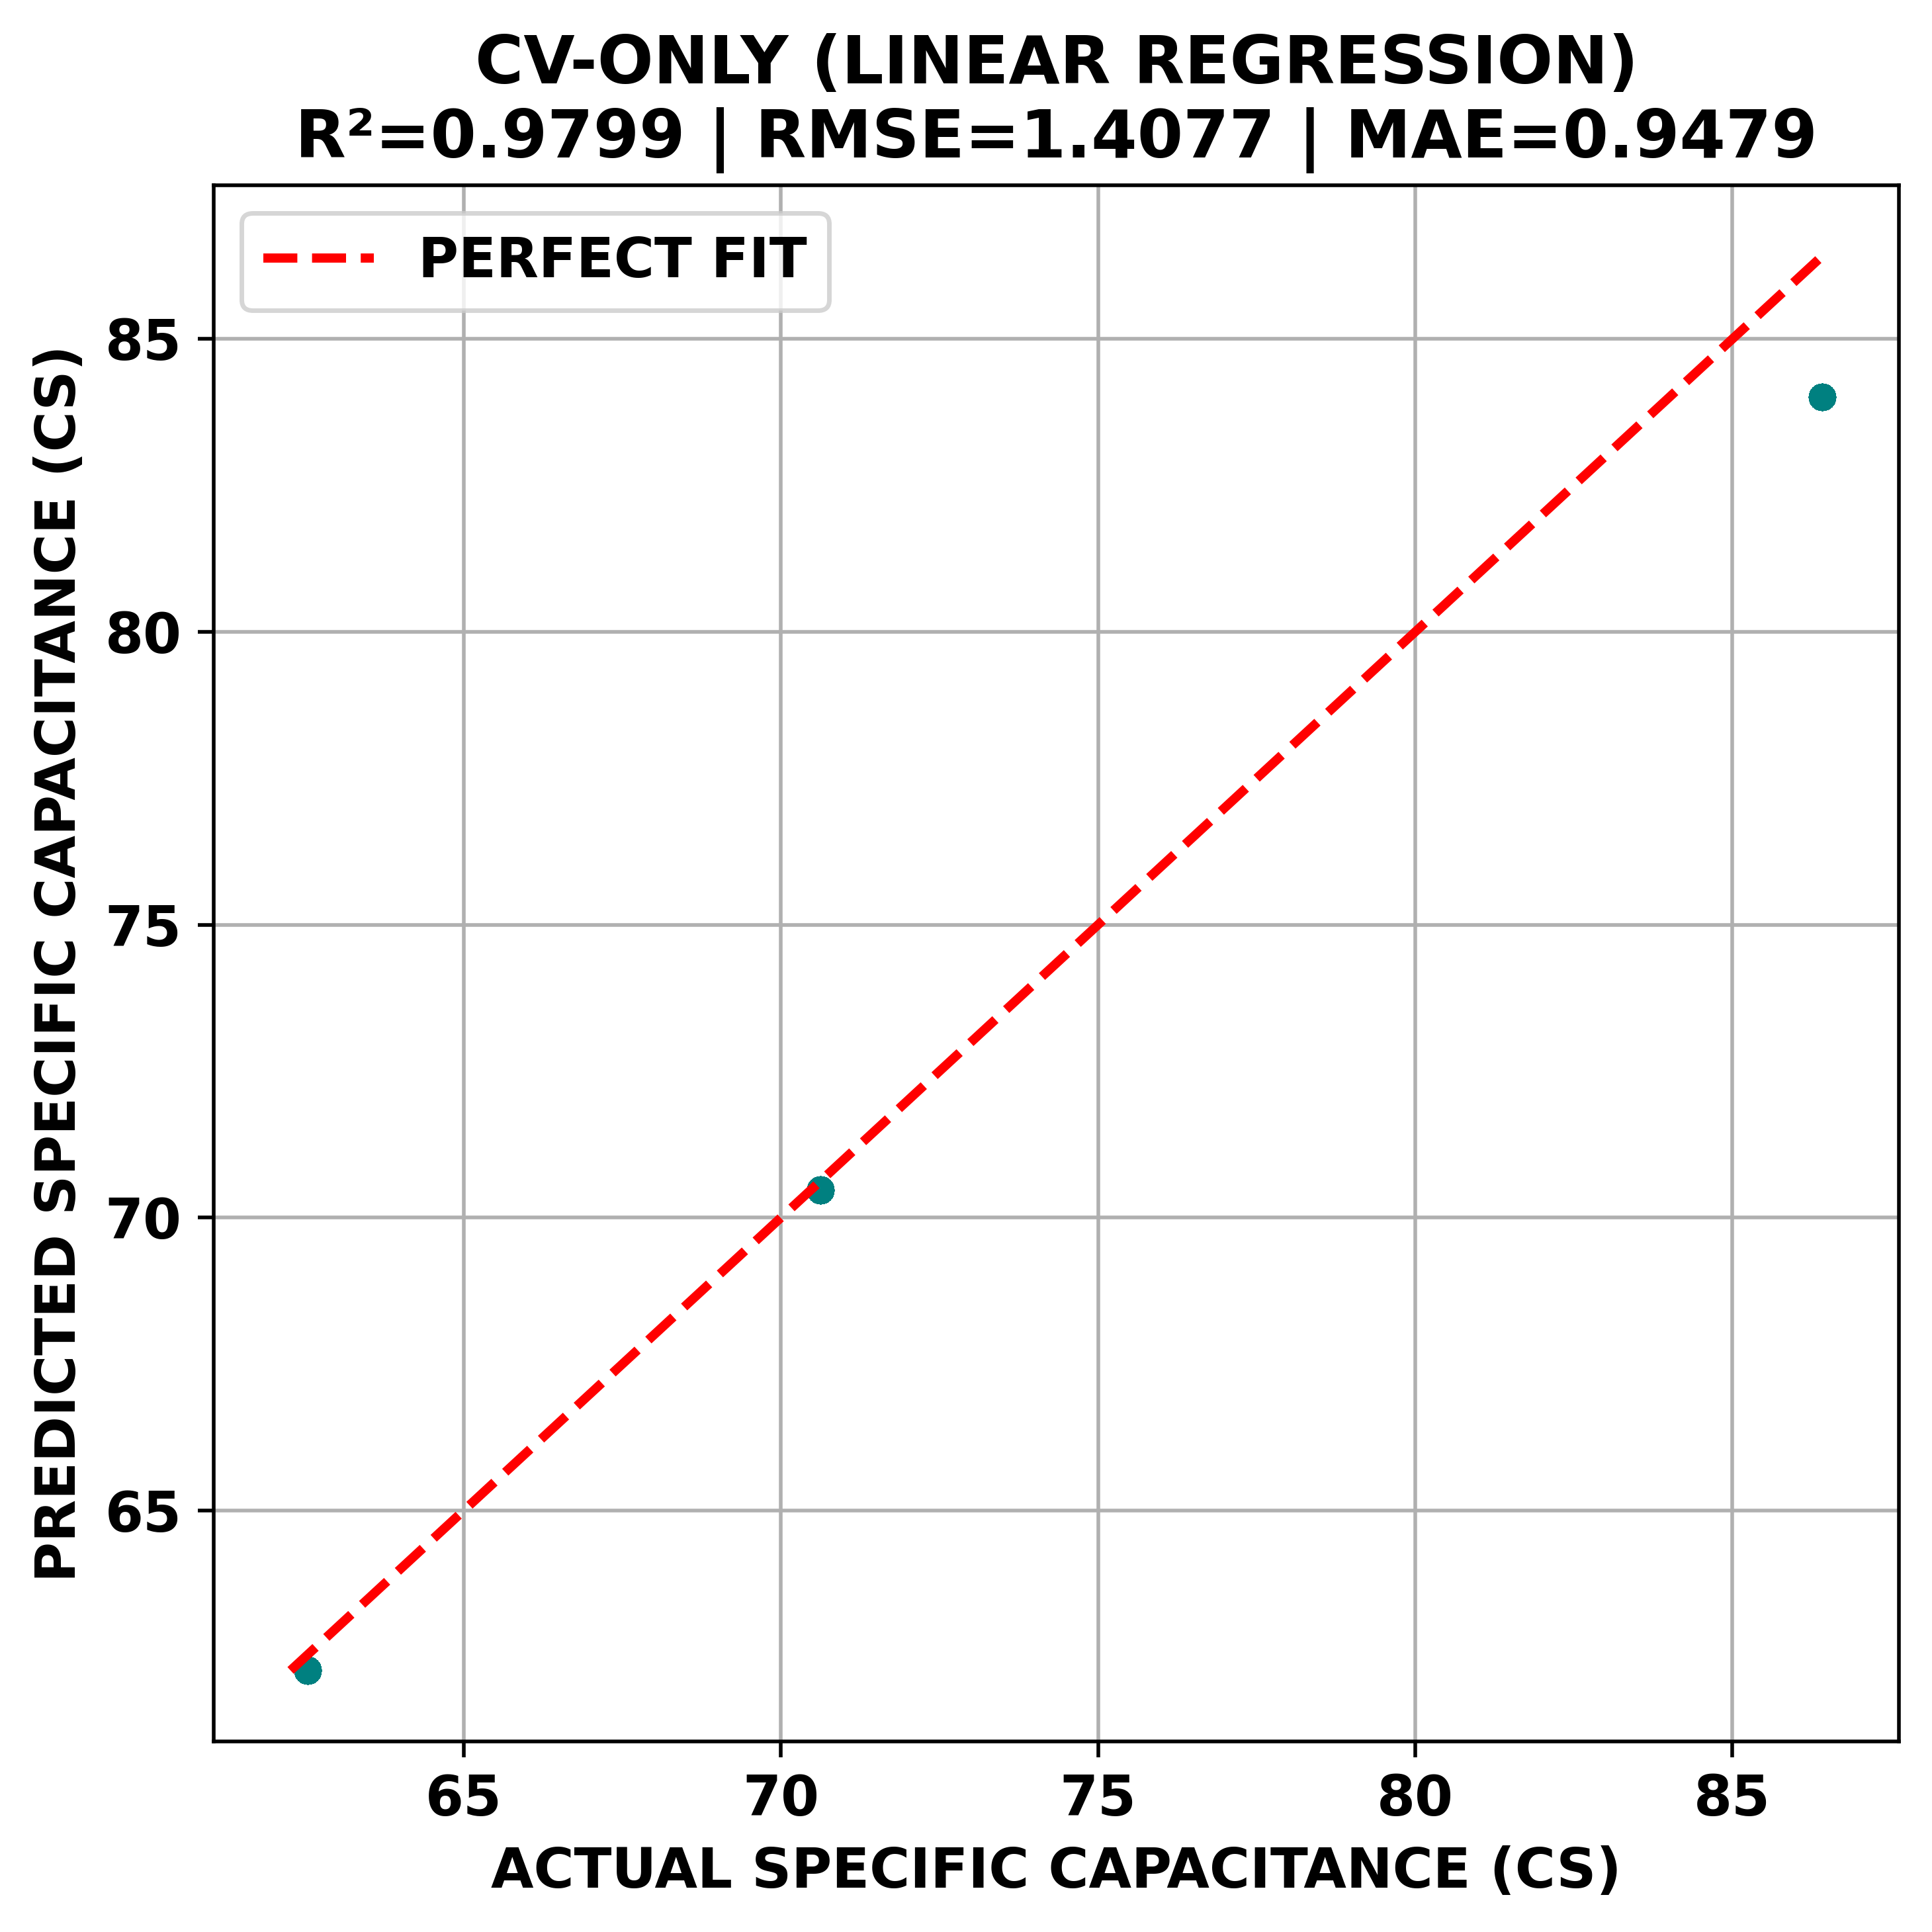

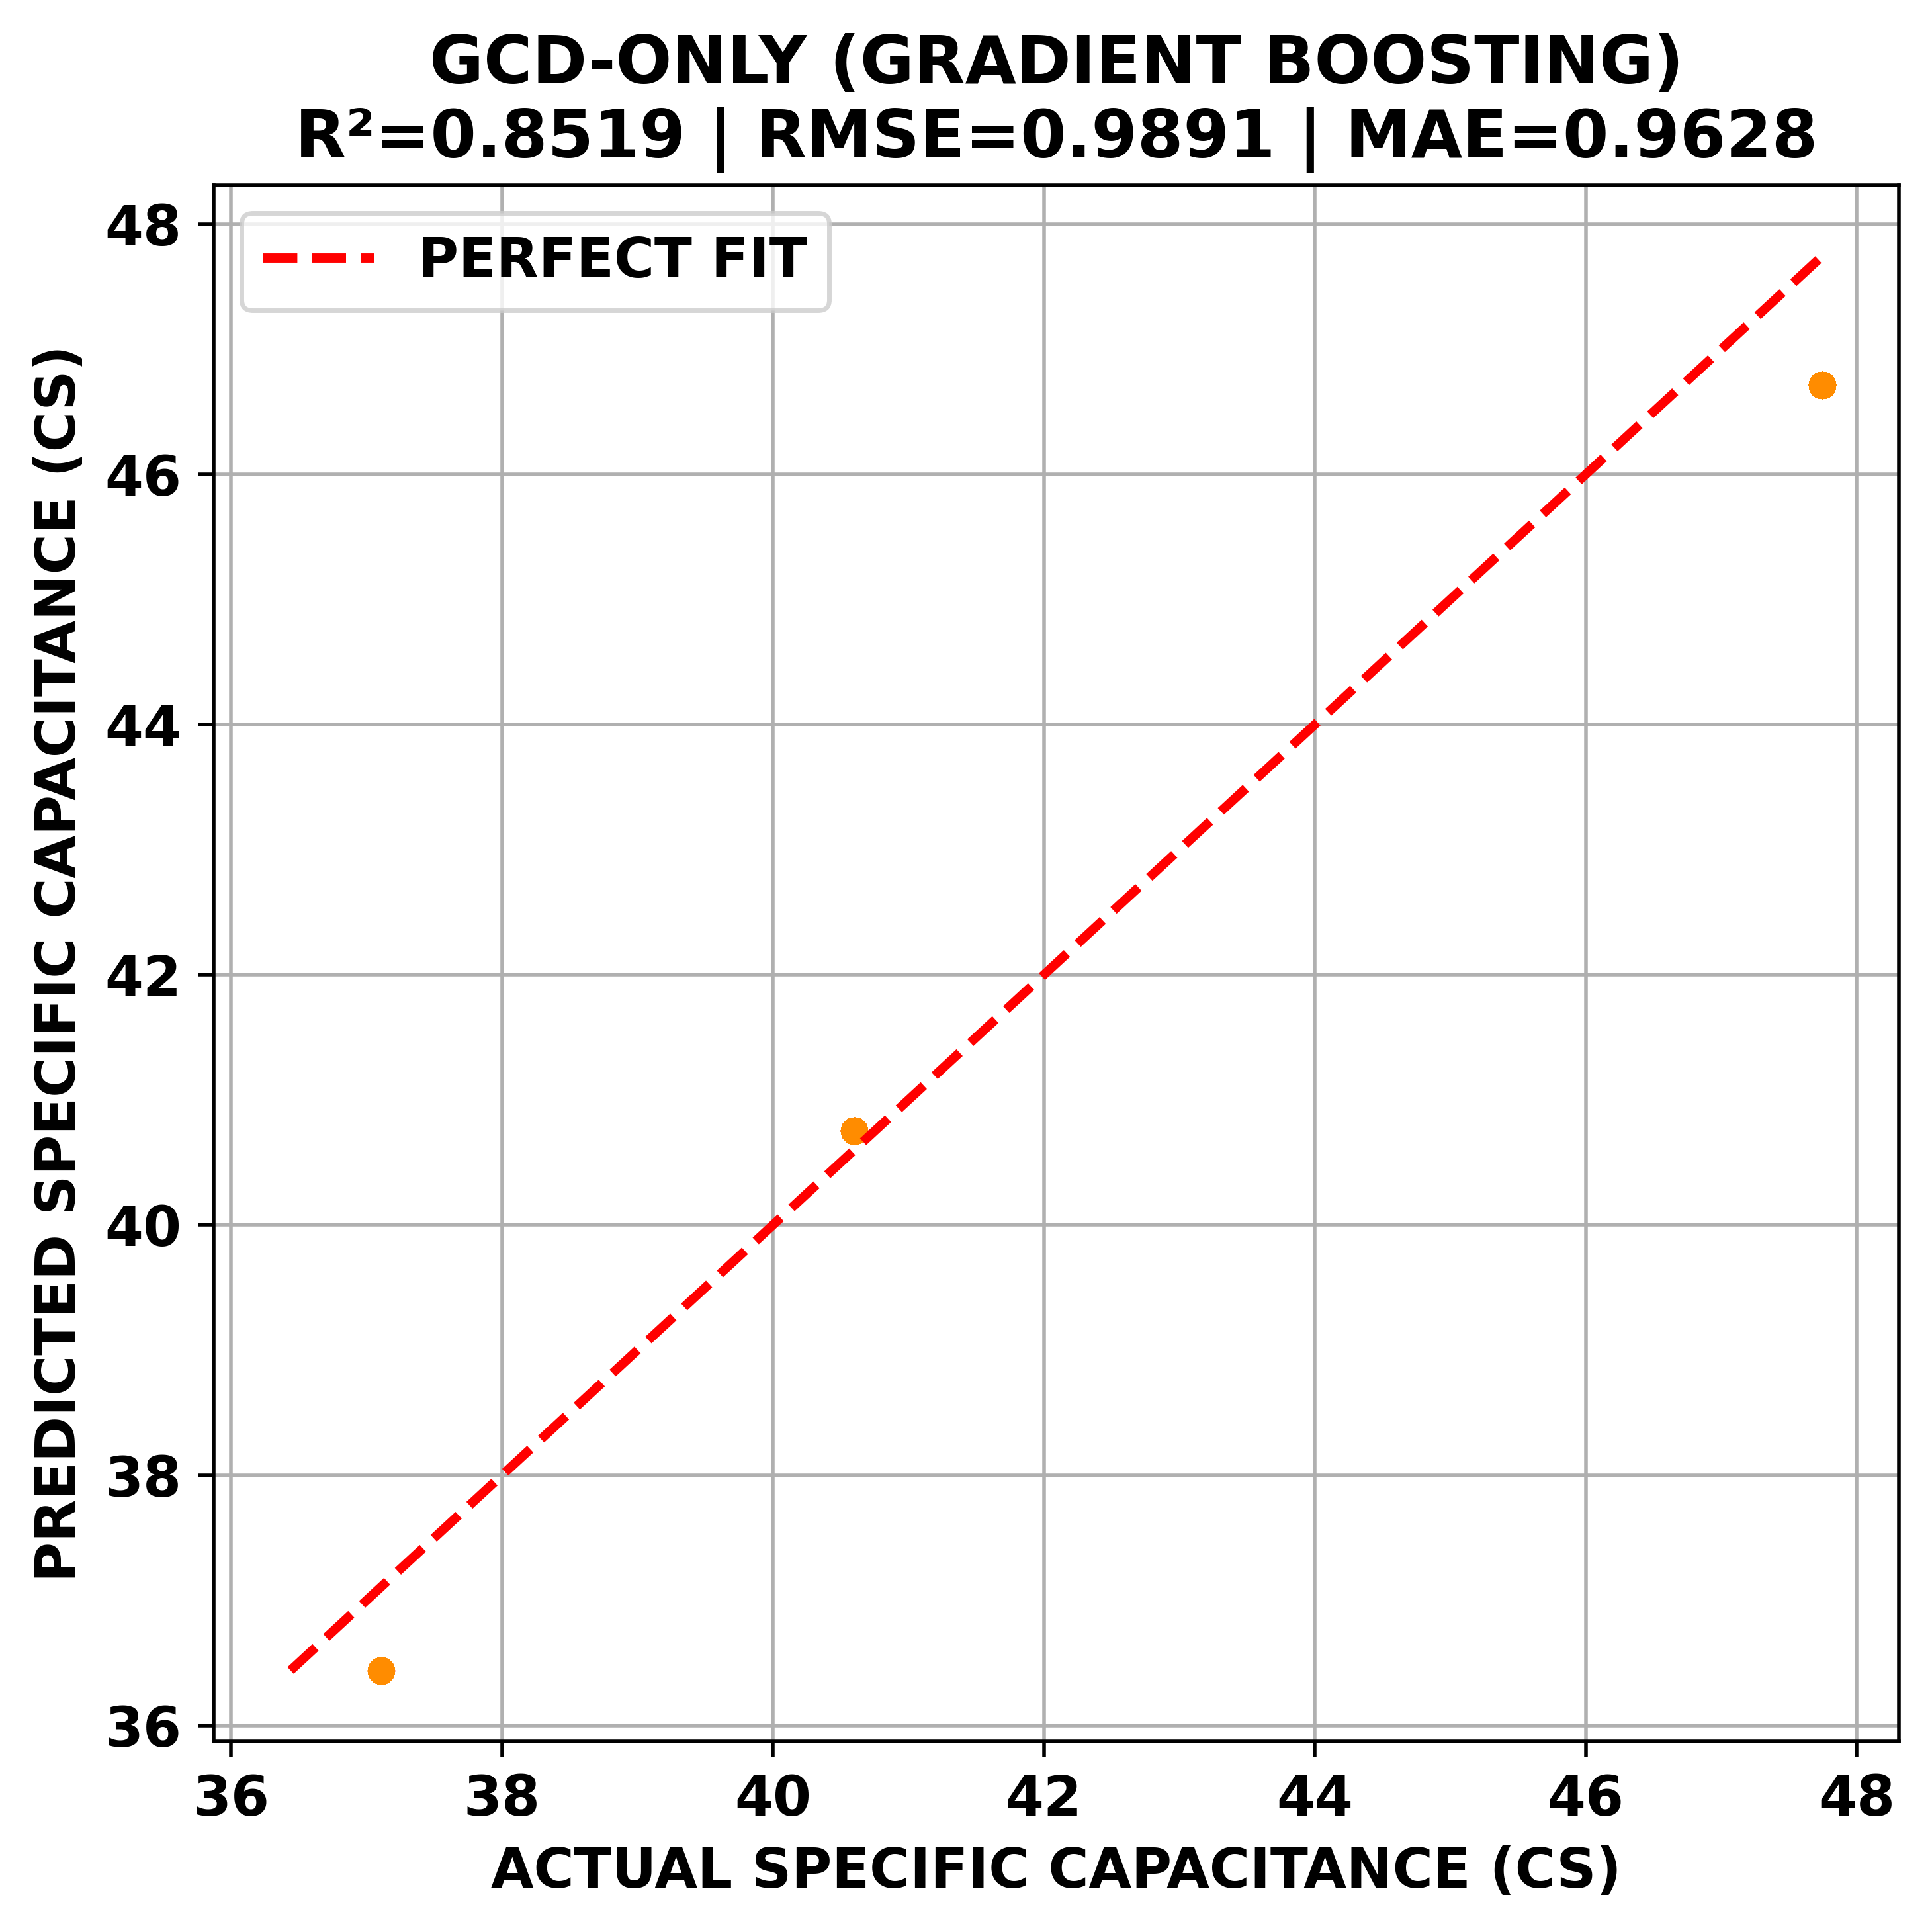

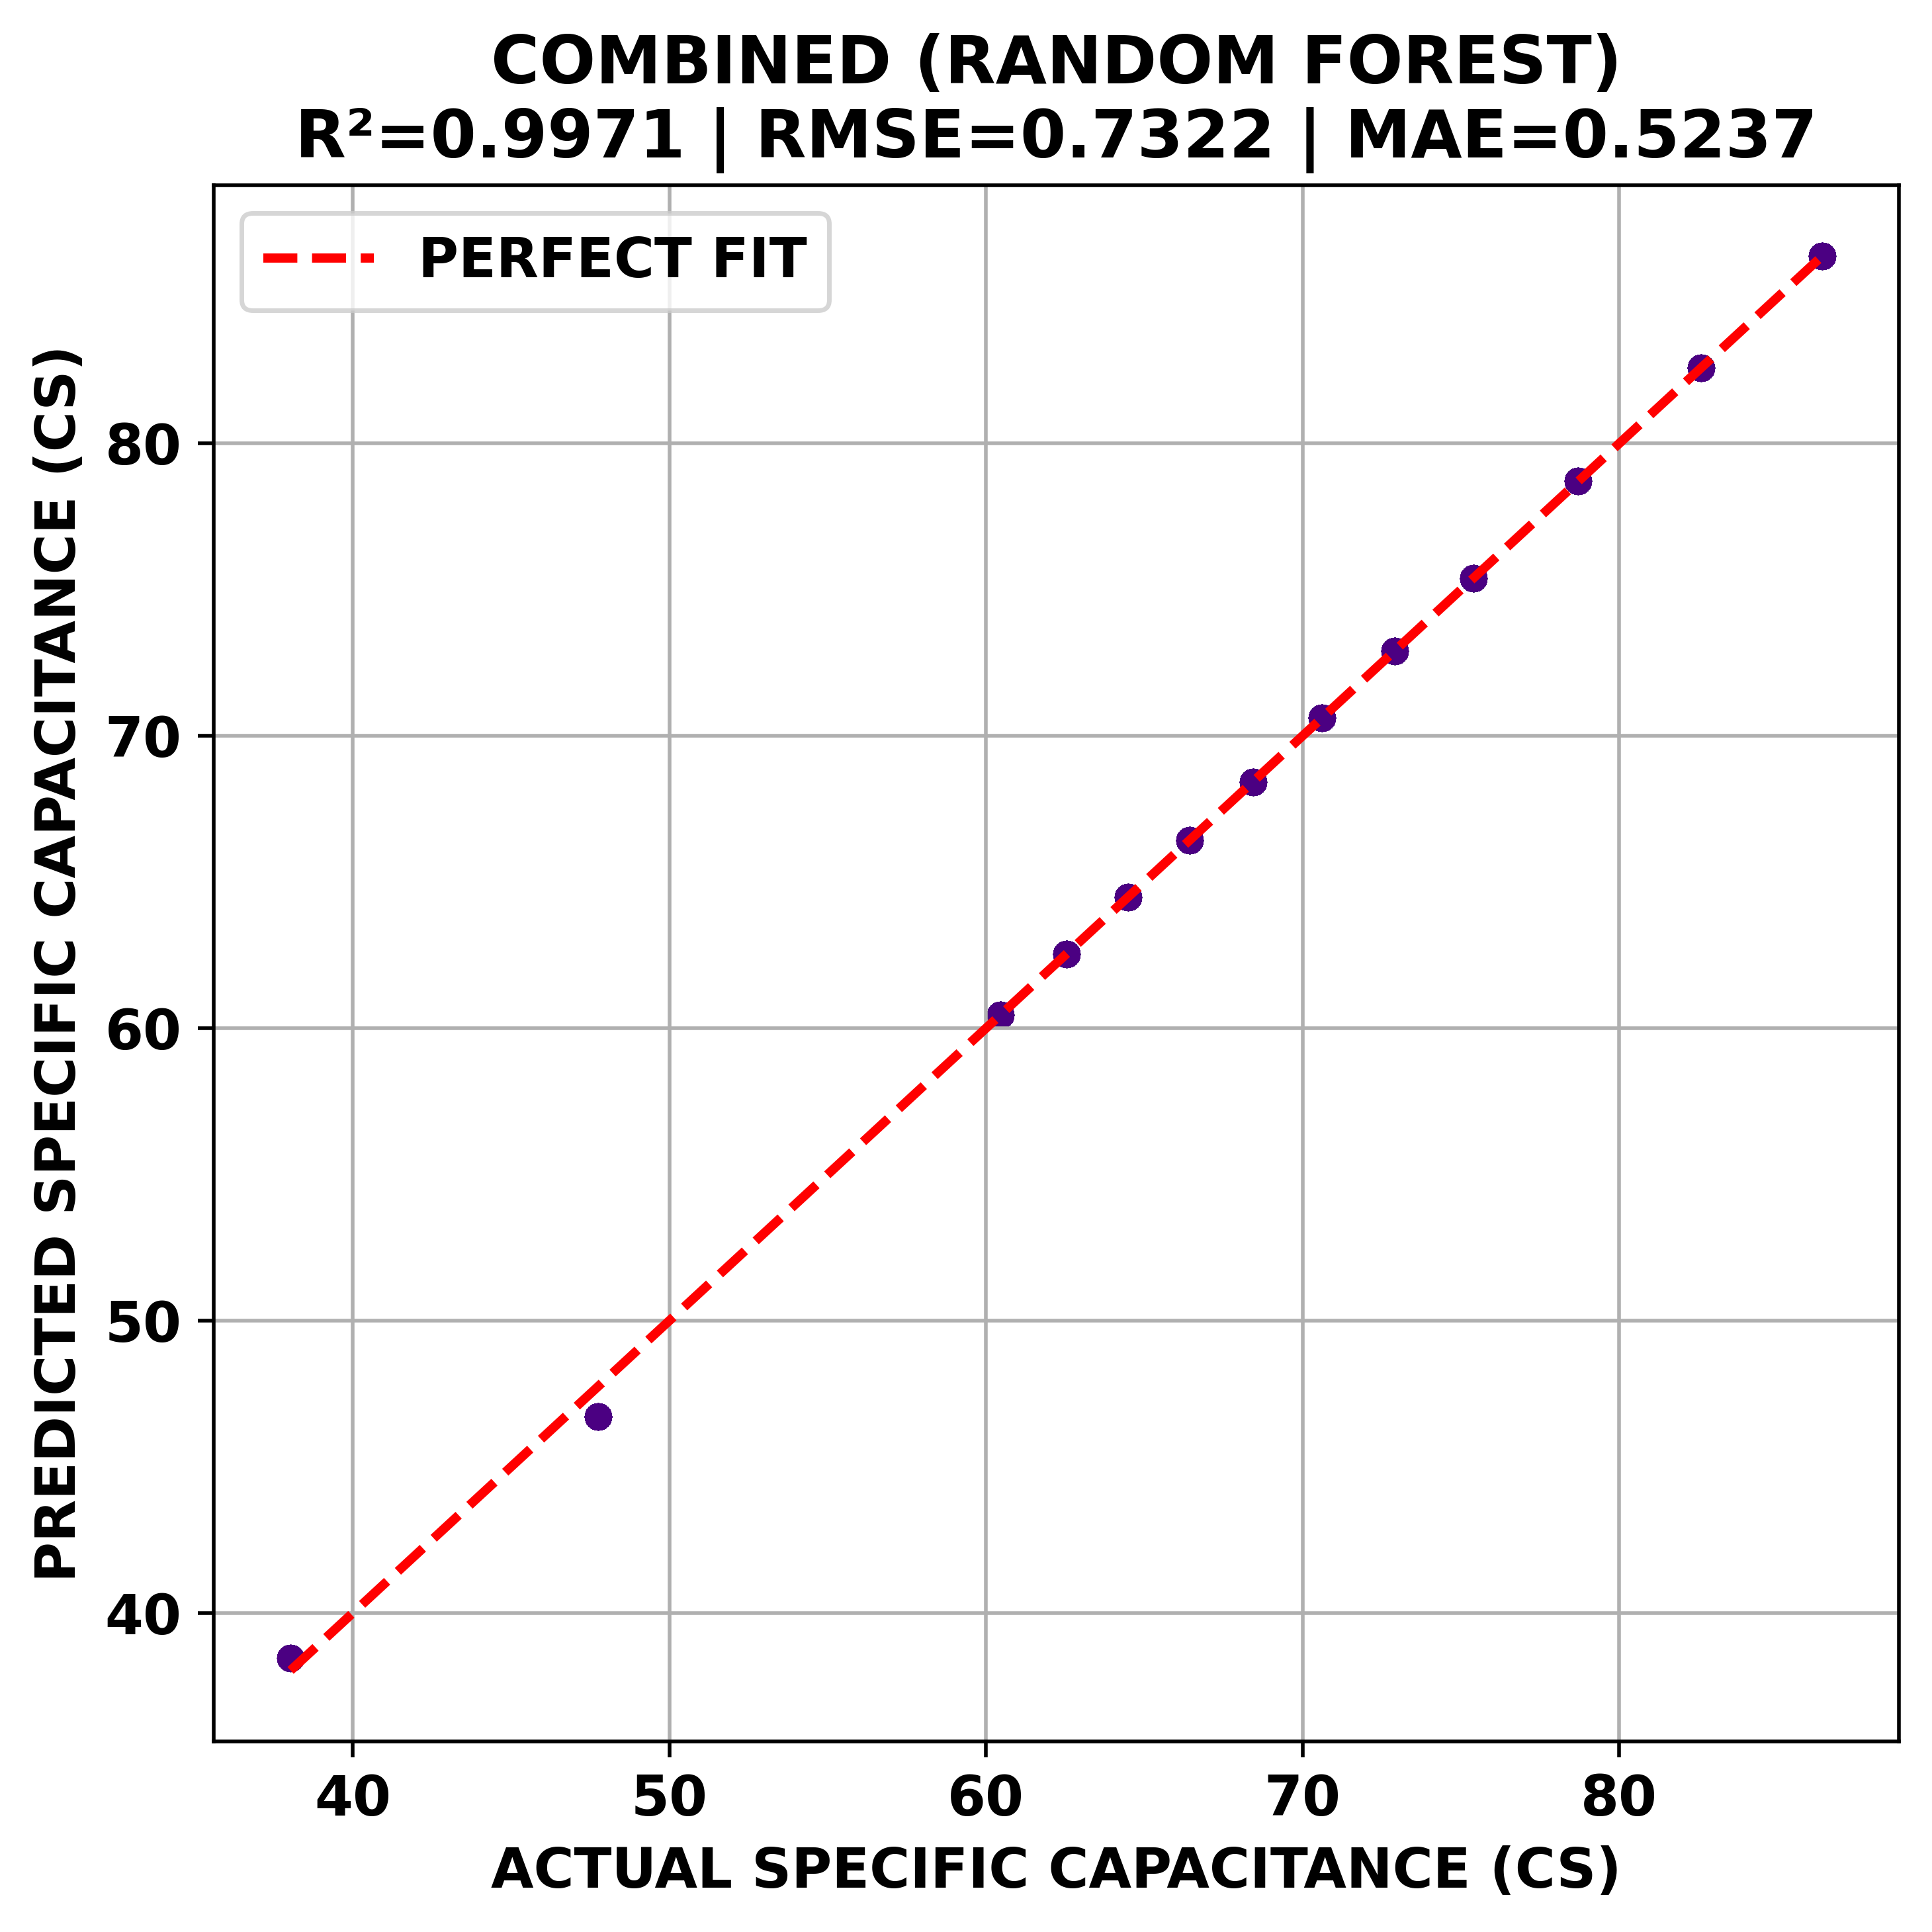

(RandomForestRegressor(n_jobs=-1, random_state=42),
 Index(['Current_Density', 'Potential', 'Potential_Window', 'Area',
        'Discharge_Time', 'Method_GCD'],
       dtype='str'))

In [43]:
plot_actual_vs_predicted(*data_splits_robust['CV'], 'CV-Only', 'teal')
plot_actual_vs_predicted(*data_splits_robust['GCD'], 'GCD-Only', 'darkorange')
plot_actual_vs_predicted(*data_splits_robust['COMBINED'], 'Combined', 'indigo')

#### **RESIDUAL DISTRIBUTION AND ERROR BEHAVIOR USING BEST PERFORMING MODELS**

##### **CV-ONLY DATASET — RESIDUAL ANALYSIS (LINEAR REGRESSION)**
##### **GCD-ONLY DATASET — RESIDUAL ANALYSIS (GRADIENT BOOSTING)**
##### **COMBINED DATASET — RESIDUAL ANALYSIS (GRADIENT BOOSTING)**

In [44]:
def plot_residuals(X_train, X_test, y_train, y_test, dataset_name: str, color: str):
    """
    AUTOMATIC MODEL SELECTION + CONDITIONAL SCALING.
    ALL DISPLAY TEXT IN UPPER CASE.
    """
    print(f"\n=== RESIDUAL ANALYSIS: {dataset_name.upper()} ===")
    
    # GET BEST MODEL
    model_name = best_models[dataset_name]
    model = get_model(model_name)
    
    # SCALE ONLY FOR LINEAR MODELS
    if model_name in ['Linear Regression', 'Ridge']:
        scaler = RobustScaler()
        X_train_proc = scaler.fit_transform(X_train)
        X_test_proc = scaler.transform(X_test)
    else:
        X_train_proc = X_train
        X_test_proc = X_test
    
    # TRAIN
    model.fit(X_train_proc, y_train)
    preds = model.predict(X_test_proc)
    
    residuals = y_test - preds
    
    # METRICS
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    
    # RESIDUALS VS PREDICTED
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=preds, y=residuals, alpha=0.6, color=color, s=35)
    plt.axhline(0, linestyle='--', color='red', linewidth=2)
    
    plt.title(f'{dataset_name.upper()} ({model_name.upper()})\nRESIDUALS VS PREDICTED\nR²={r2:.4f}, RMSE={rmse:.4f}')
    plt.xlabel('PREDICTED CS')
    plt.ylabel('RESIDUALS (ACTUAL − PREDICTED)')
    plt.tight_layout()
    plt.show()
    
    # DISTRIBUTION
    plt.figure(figsize=(6,5))
    sns.histplot(residuals, kde=True, color=color, bins=30)
    plt.axvline(0, linestyle='--', color='red', linewidth=2)
    
    plt.title(f'{dataset_name.upper()} ({model_name.upper()})\nRESIDUAL DISTRIBUTION')
    plt.xlabel('RESIDUAL VALUE')
    plt.ylabel('FREQUENCY')
    plt.tight_layout()
    plt.show()
    
    return residuals


=== RESIDUAL ANALYSIS: CV-ONLY ===


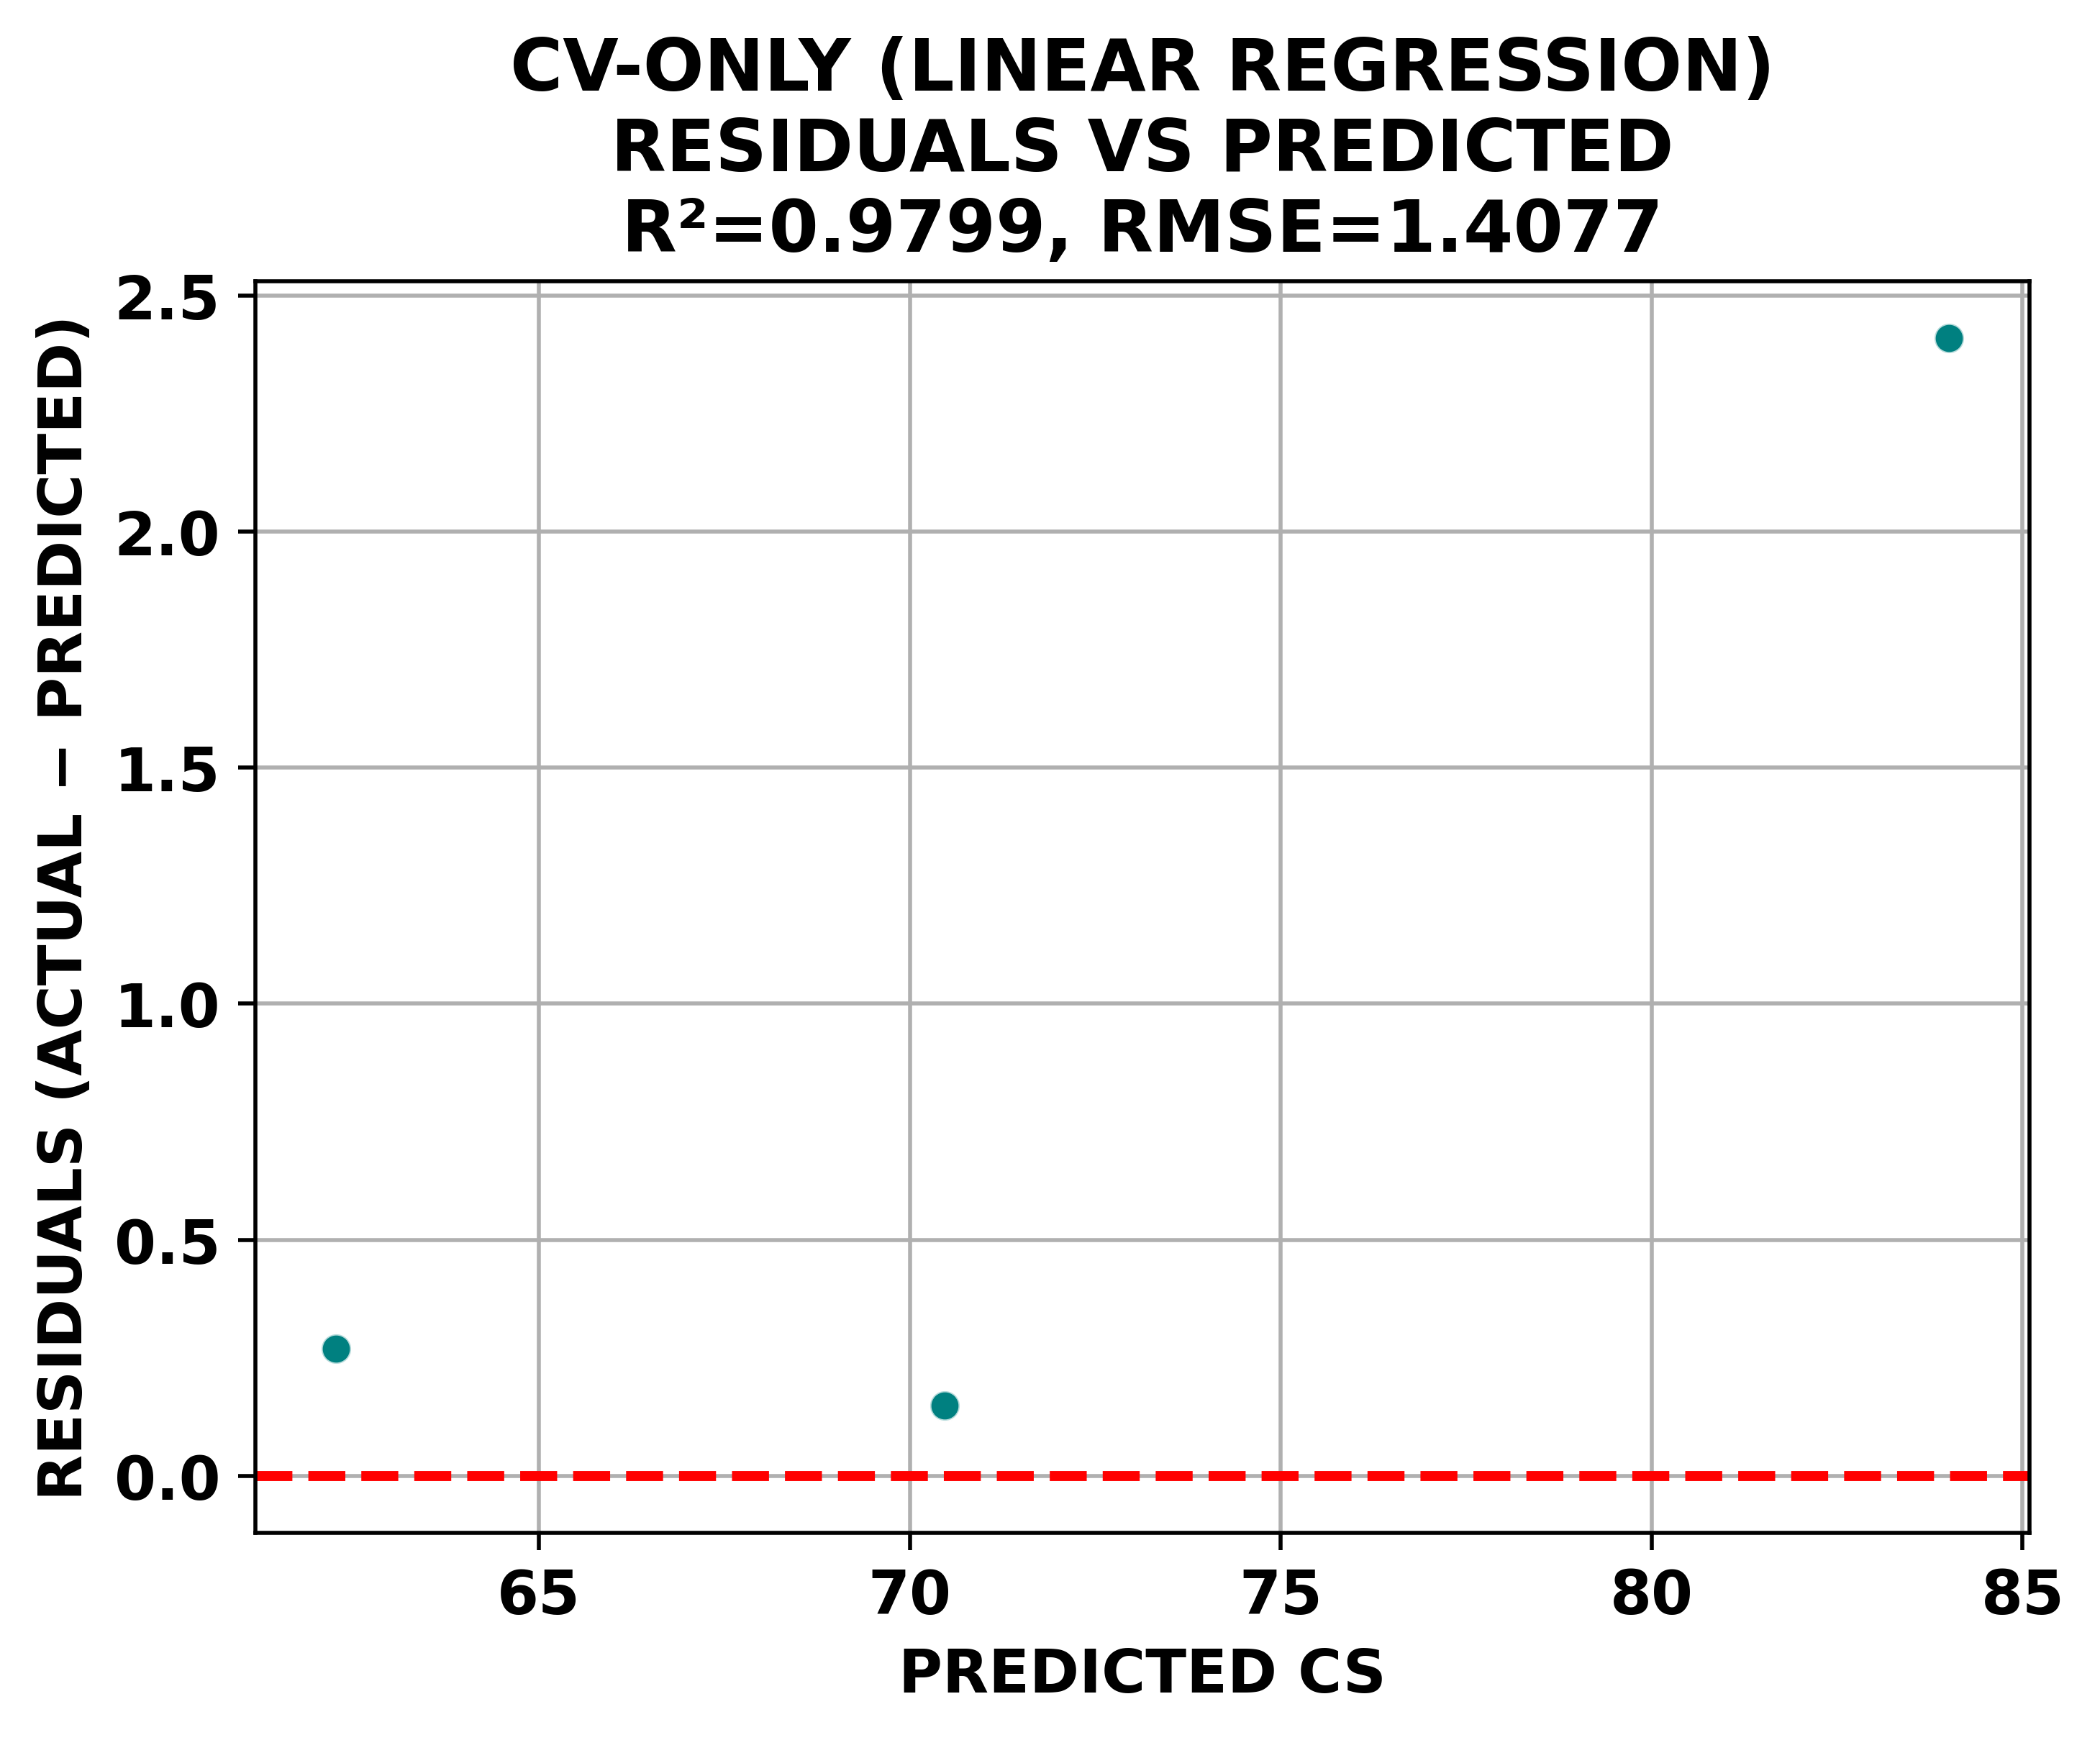

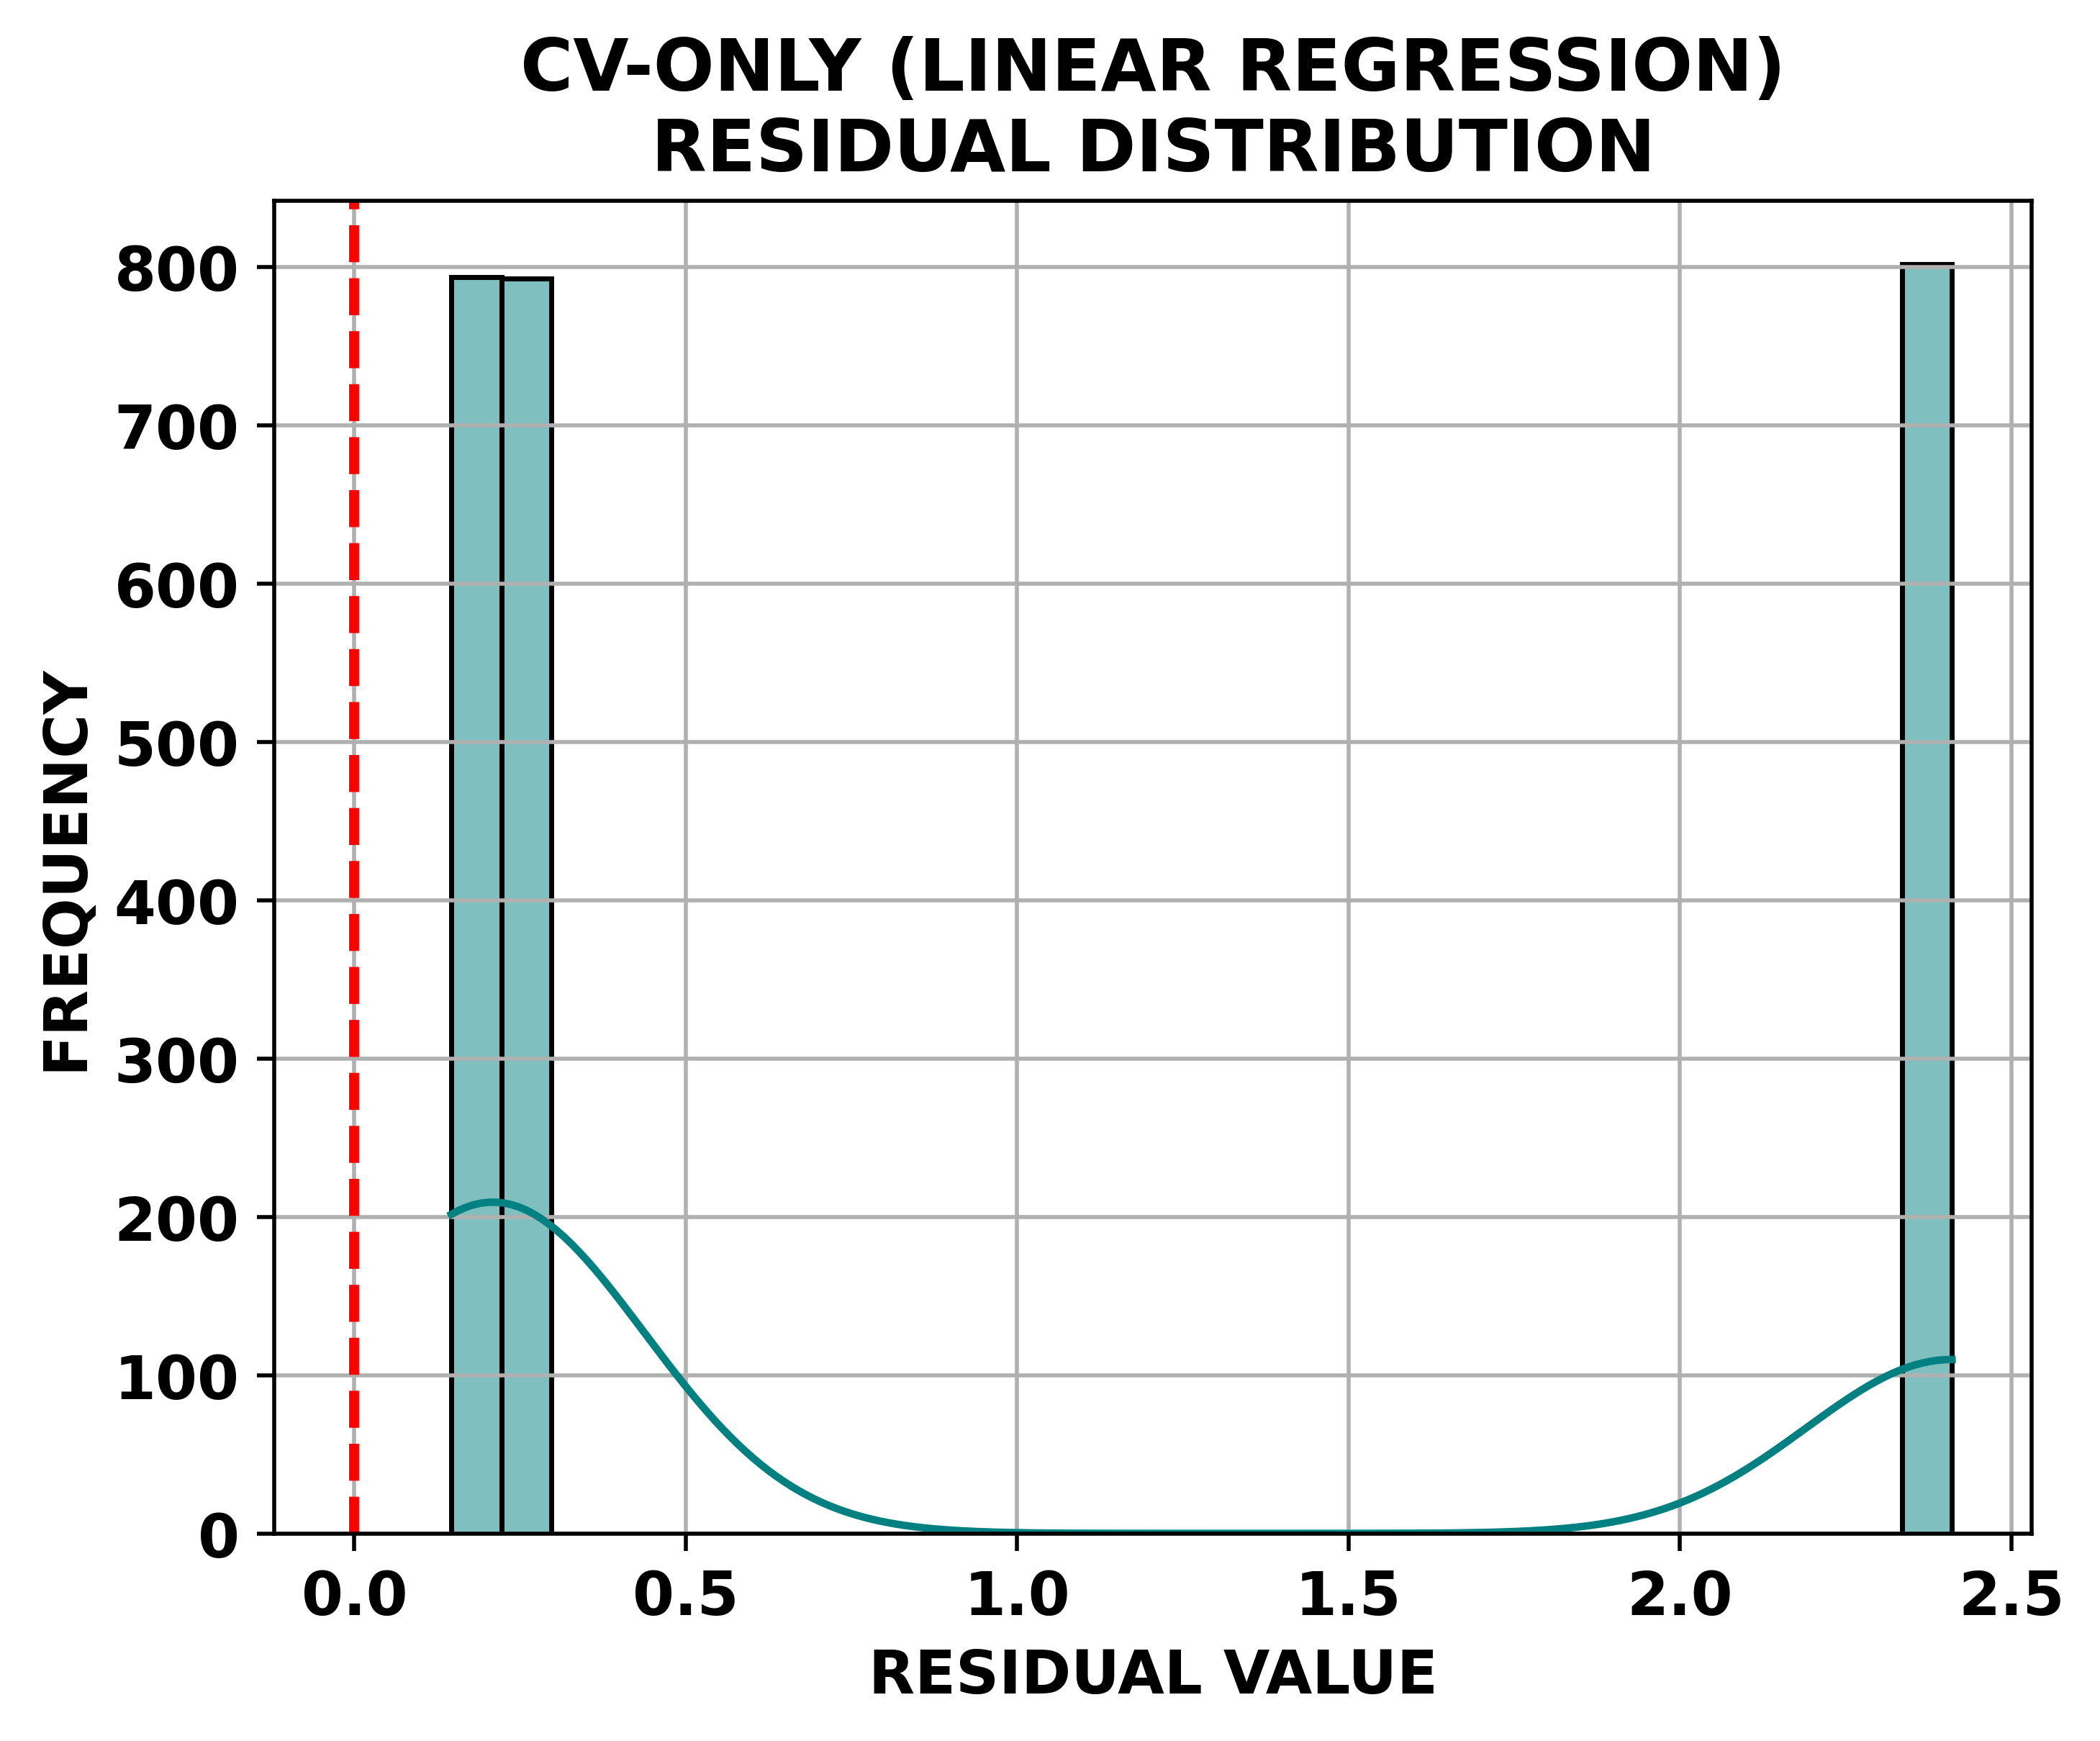


=== RESIDUAL ANALYSIS: GCD-ONLY ===


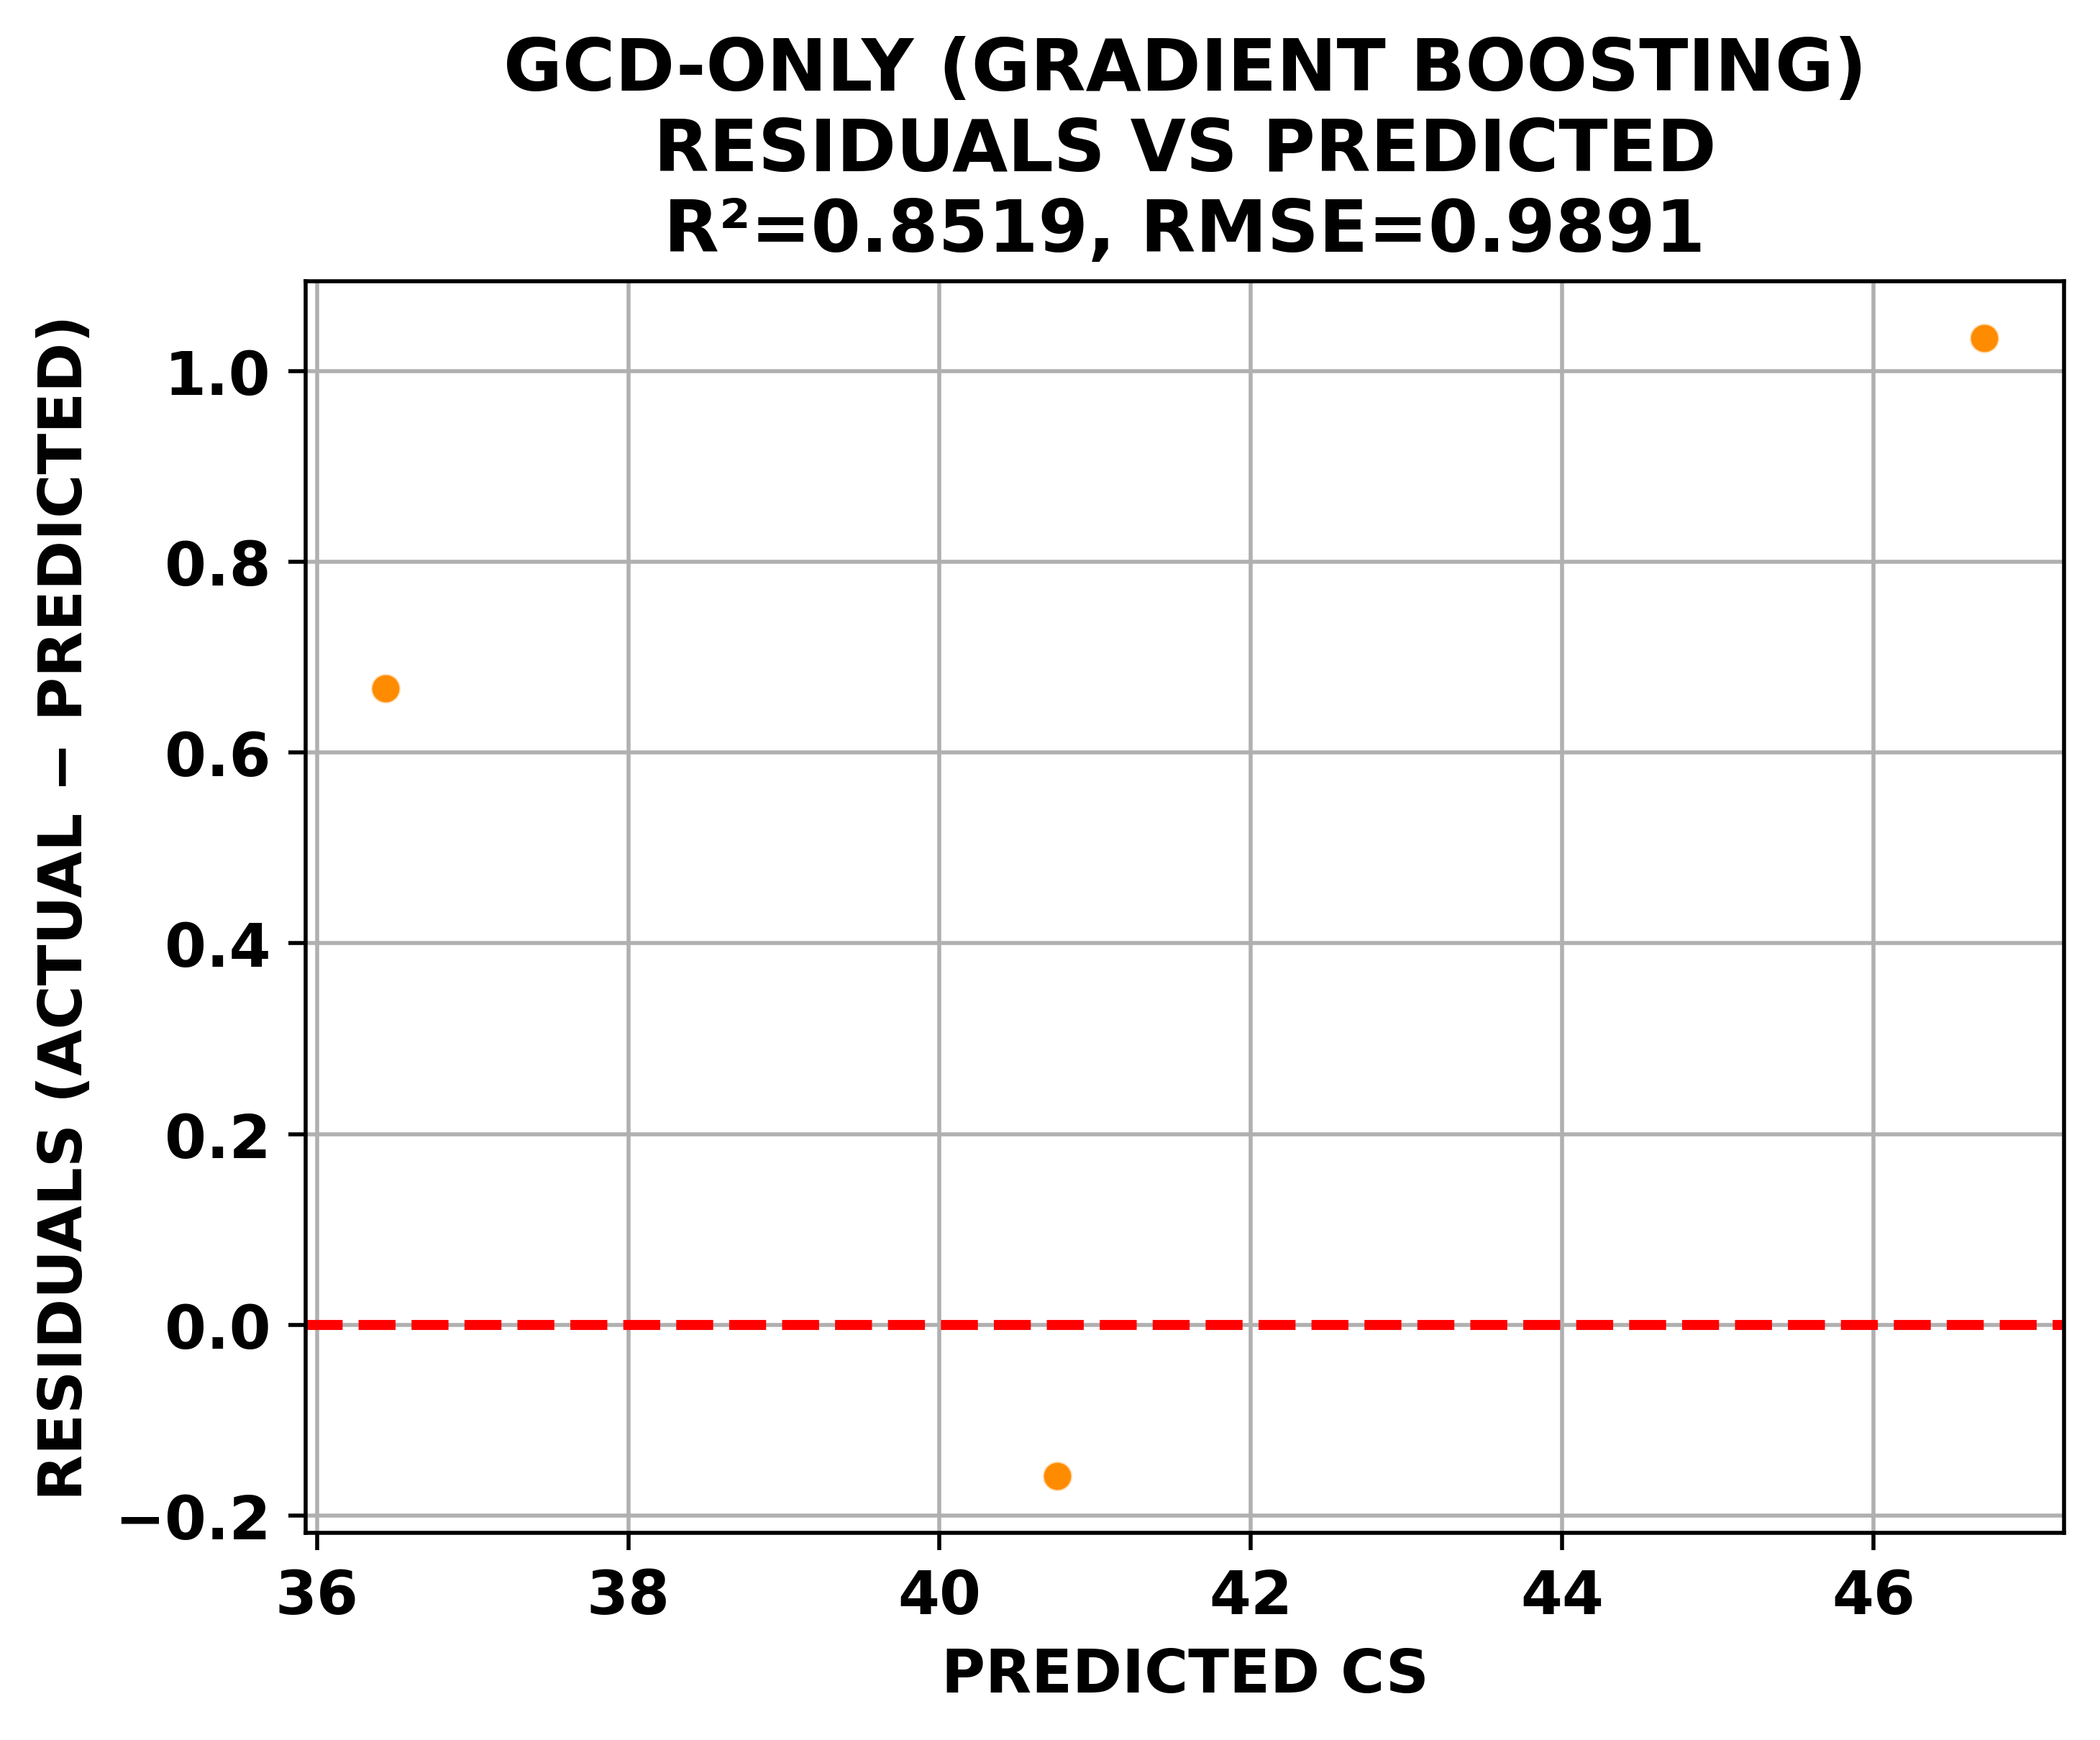

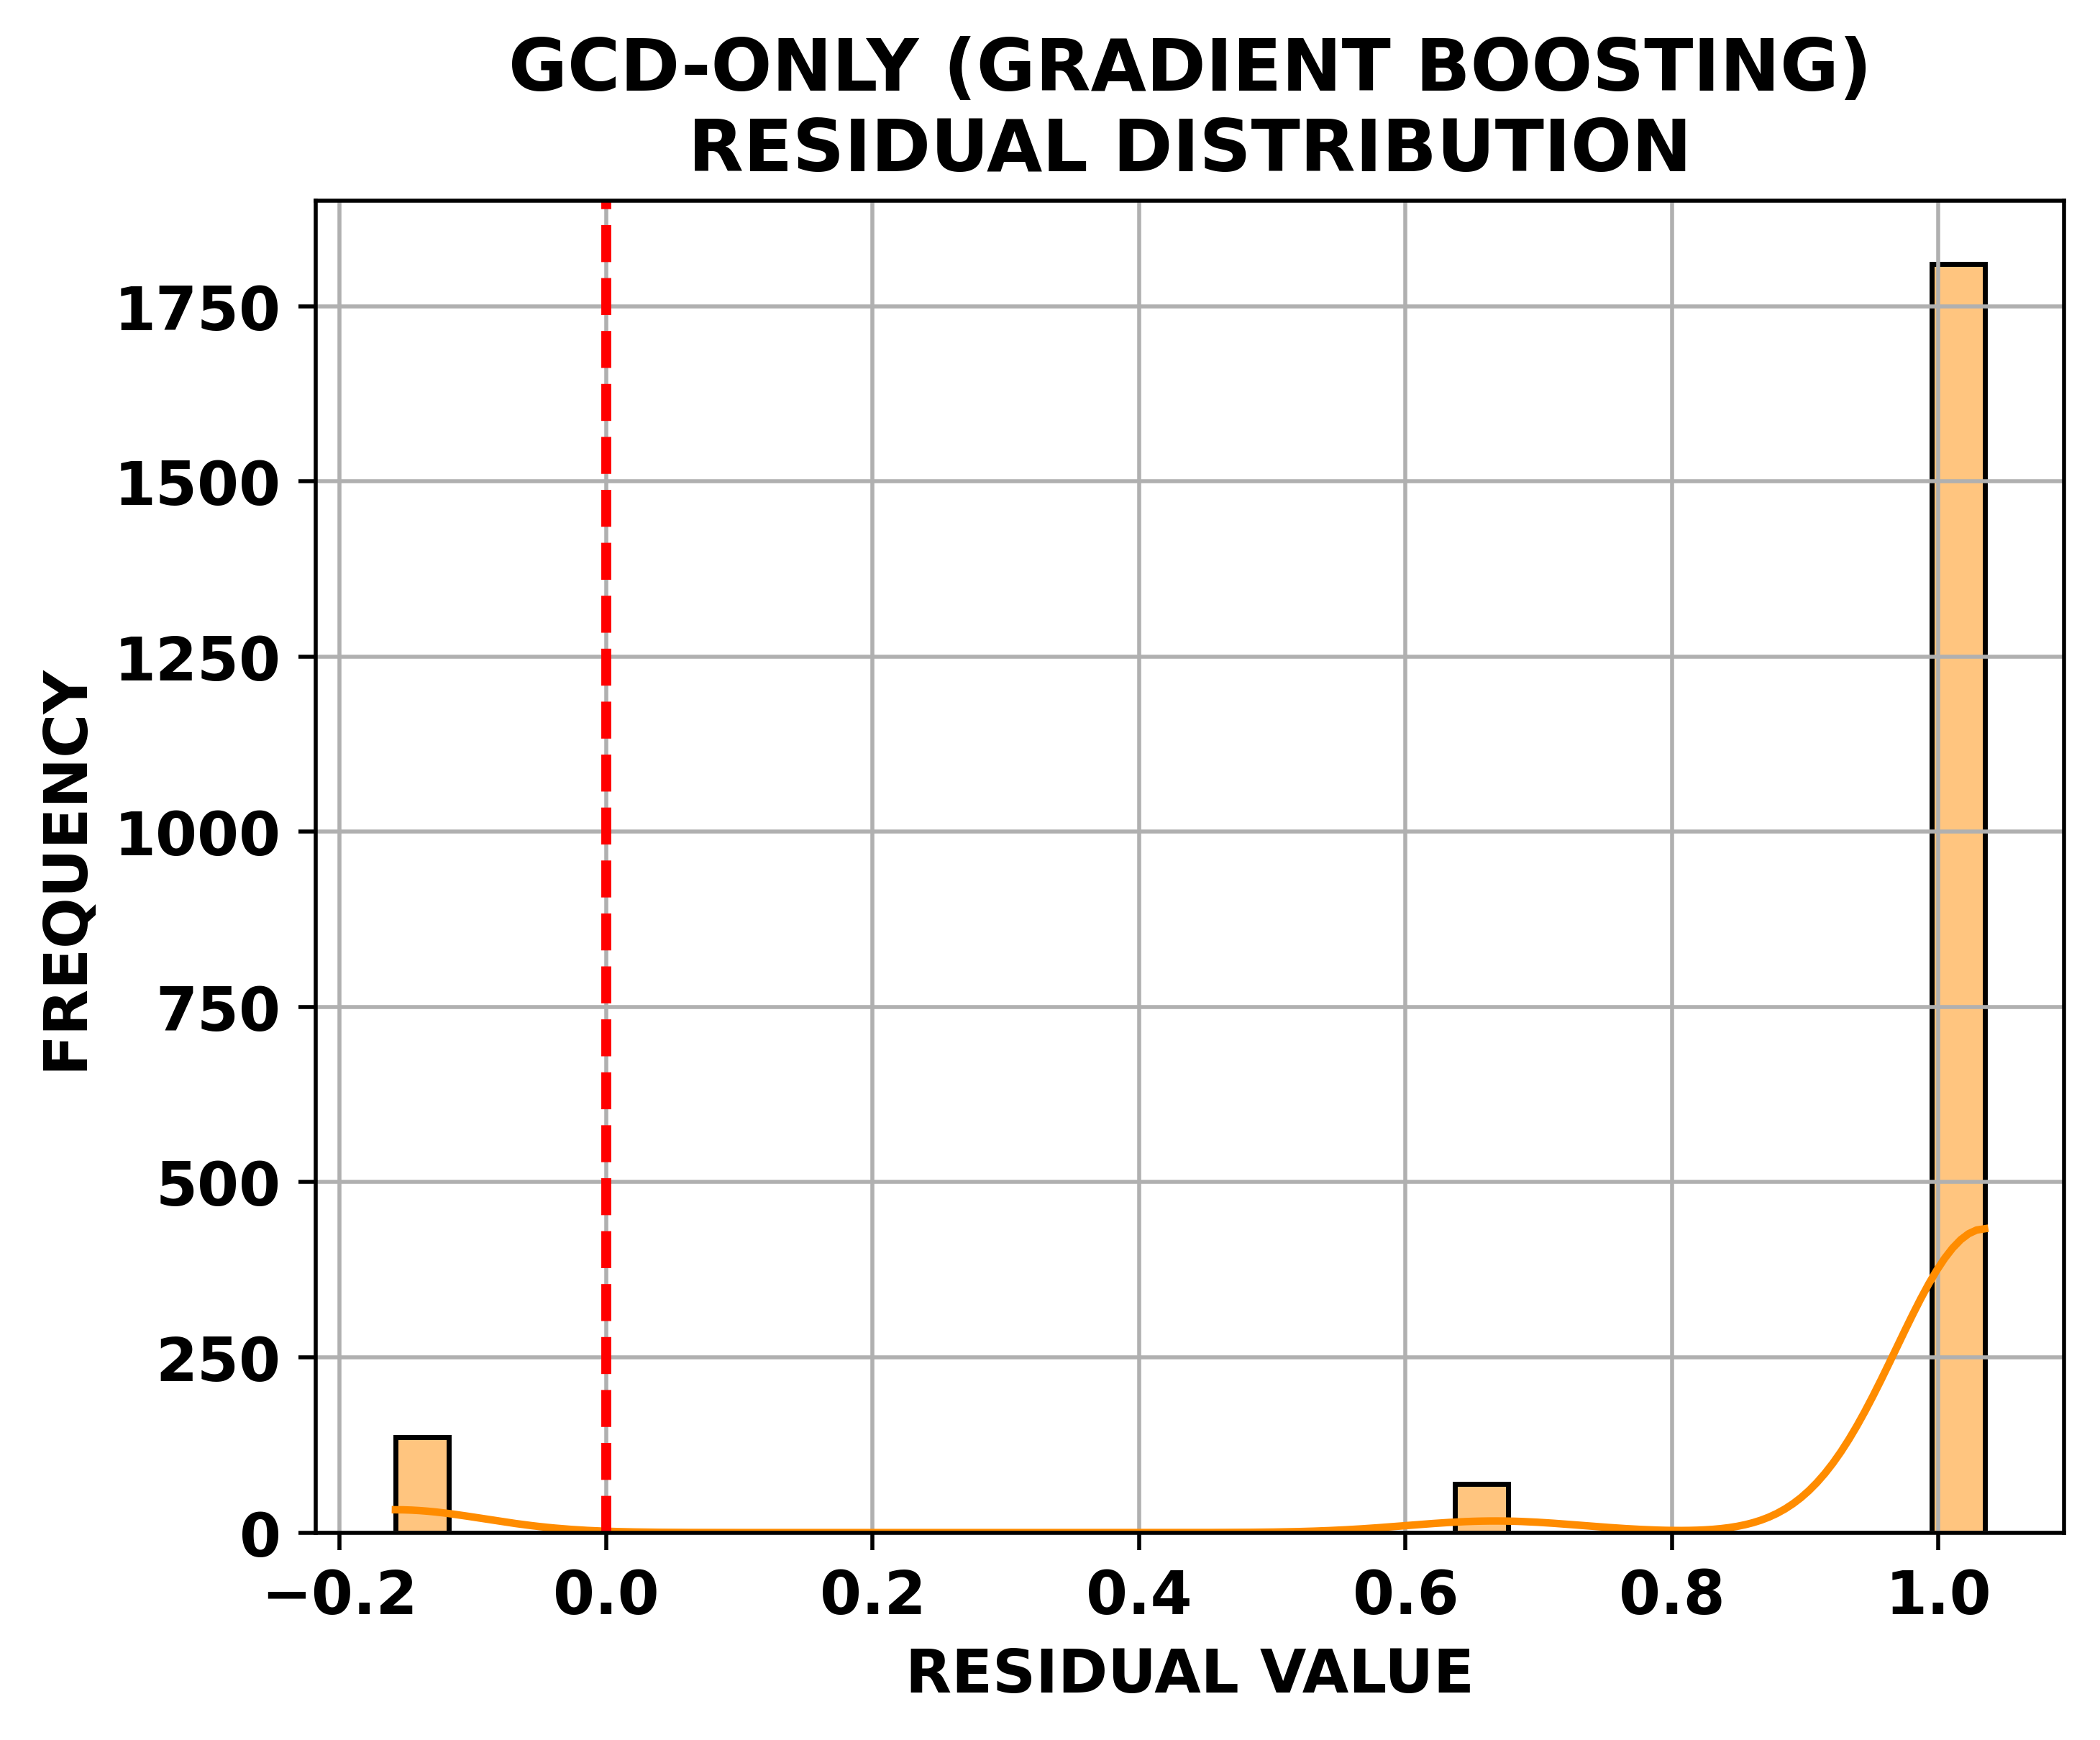


=== RESIDUAL ANALYSIS: COMBINED ===


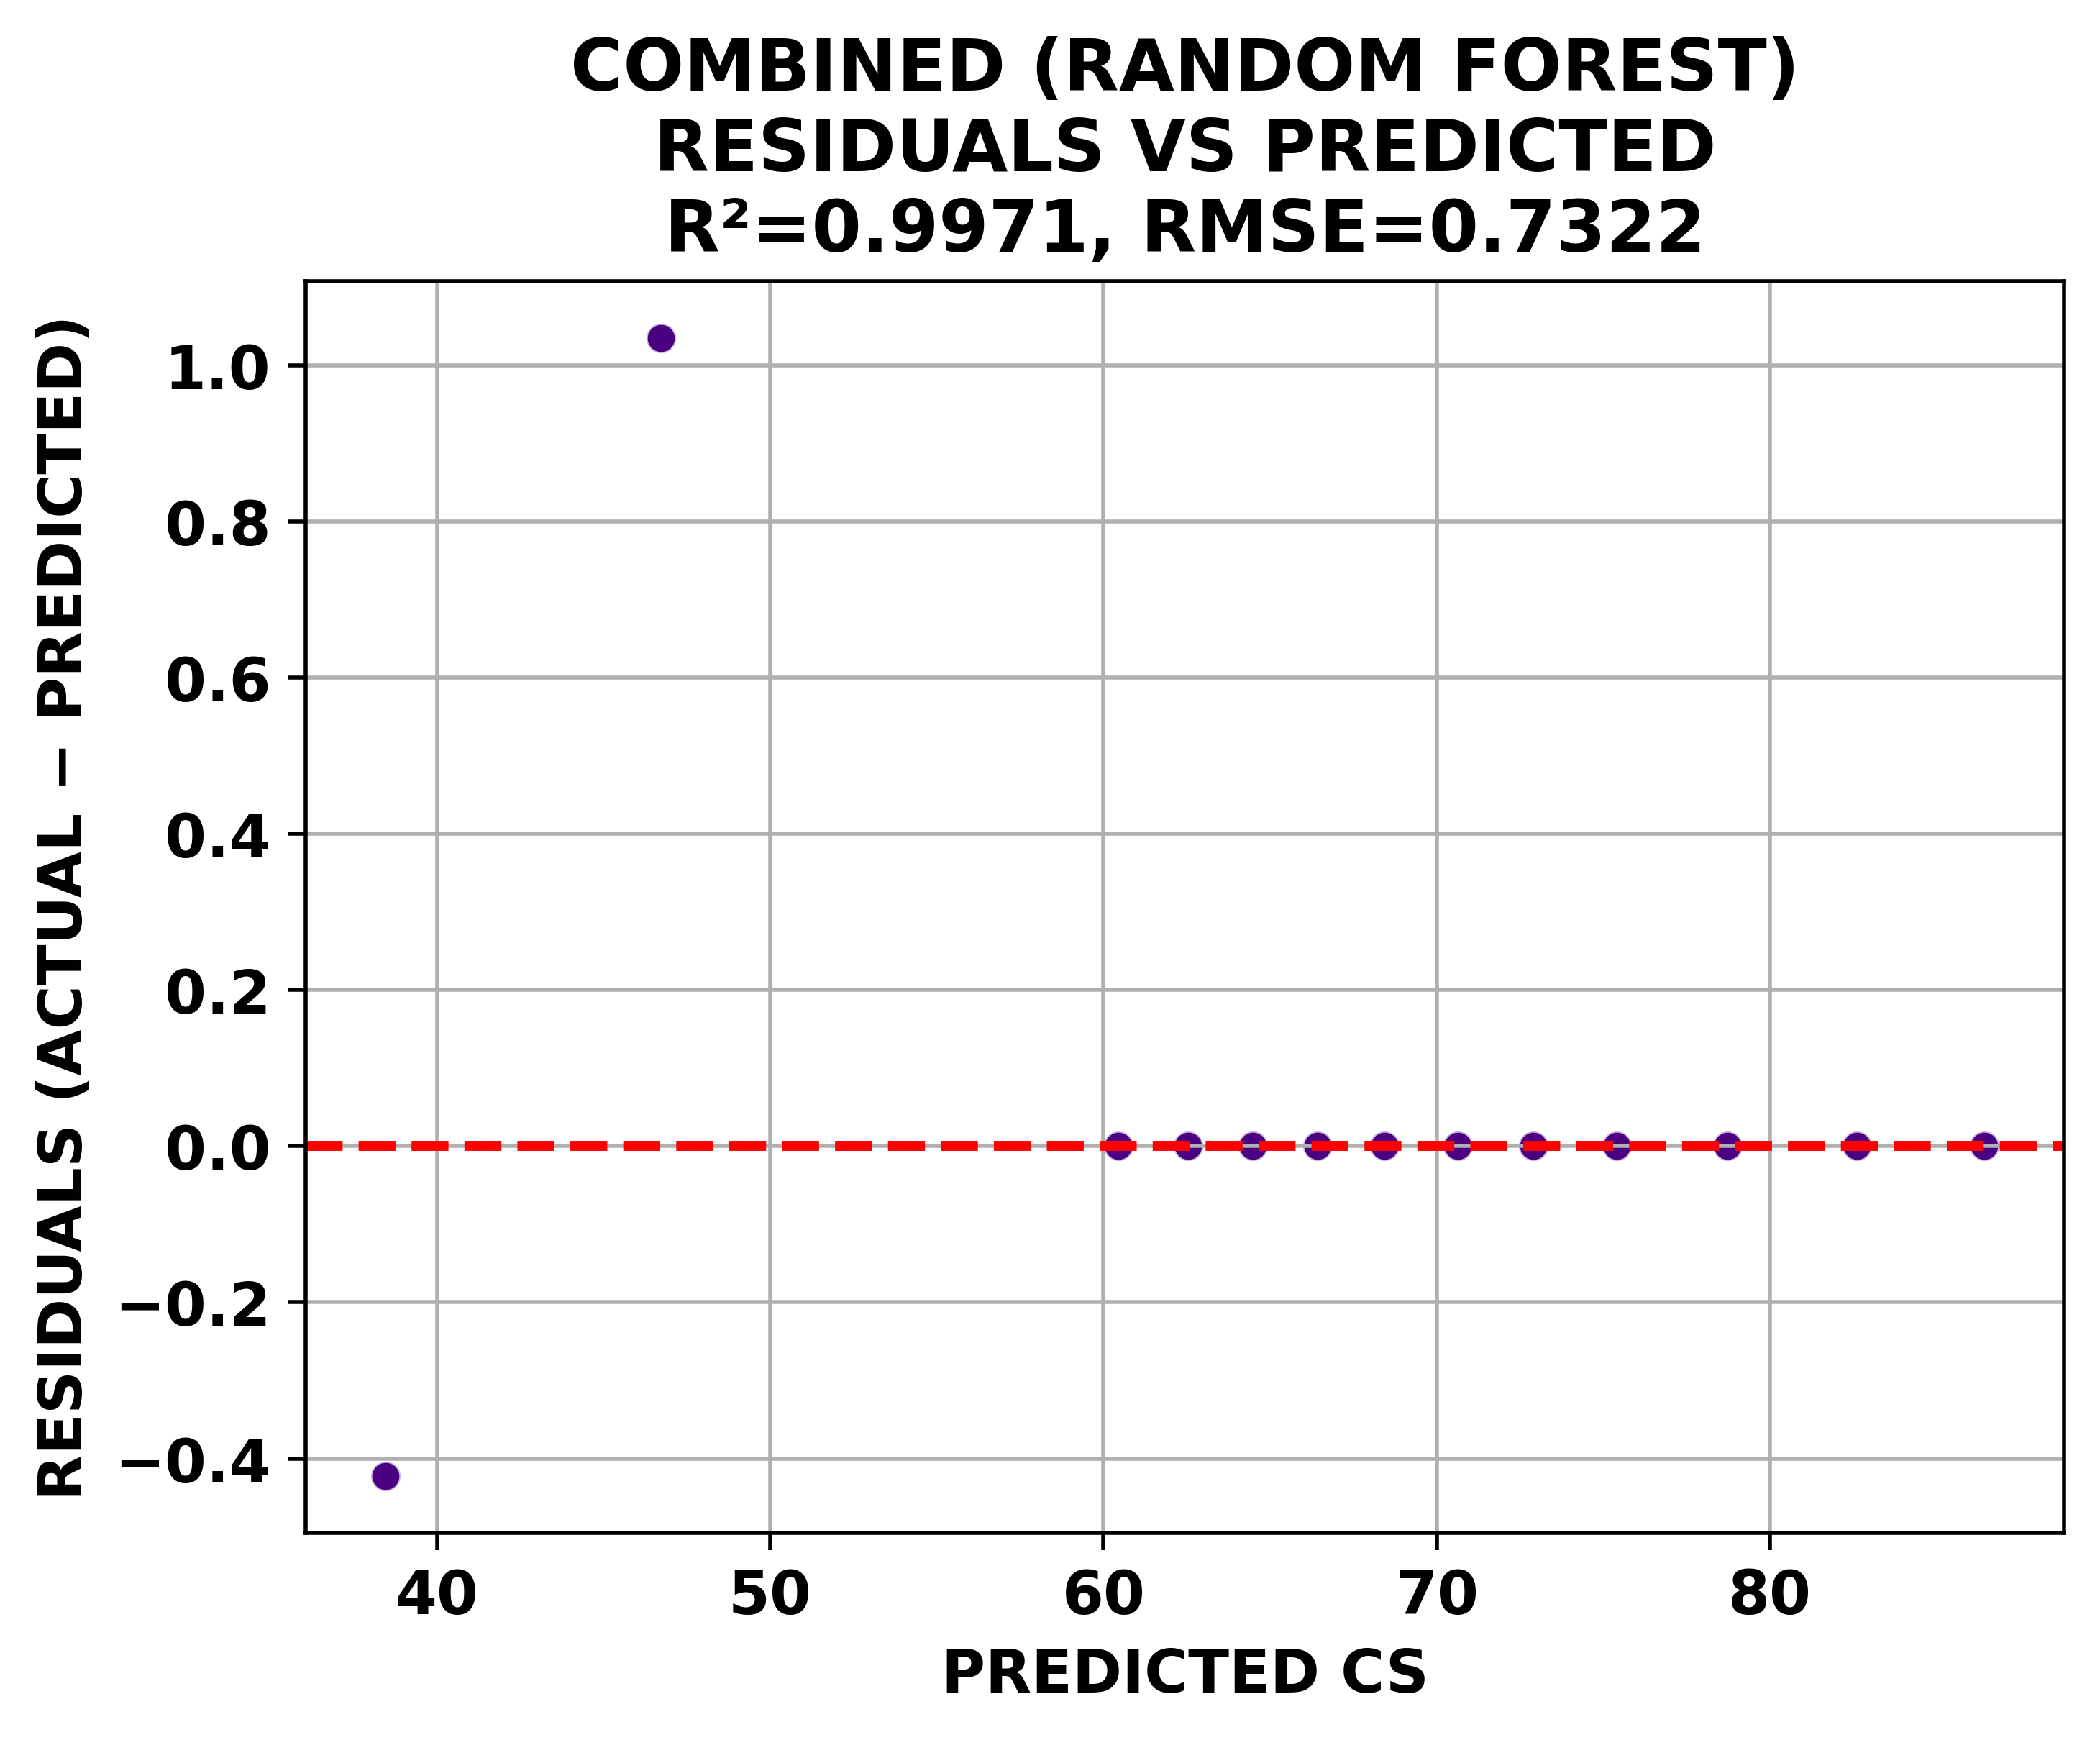

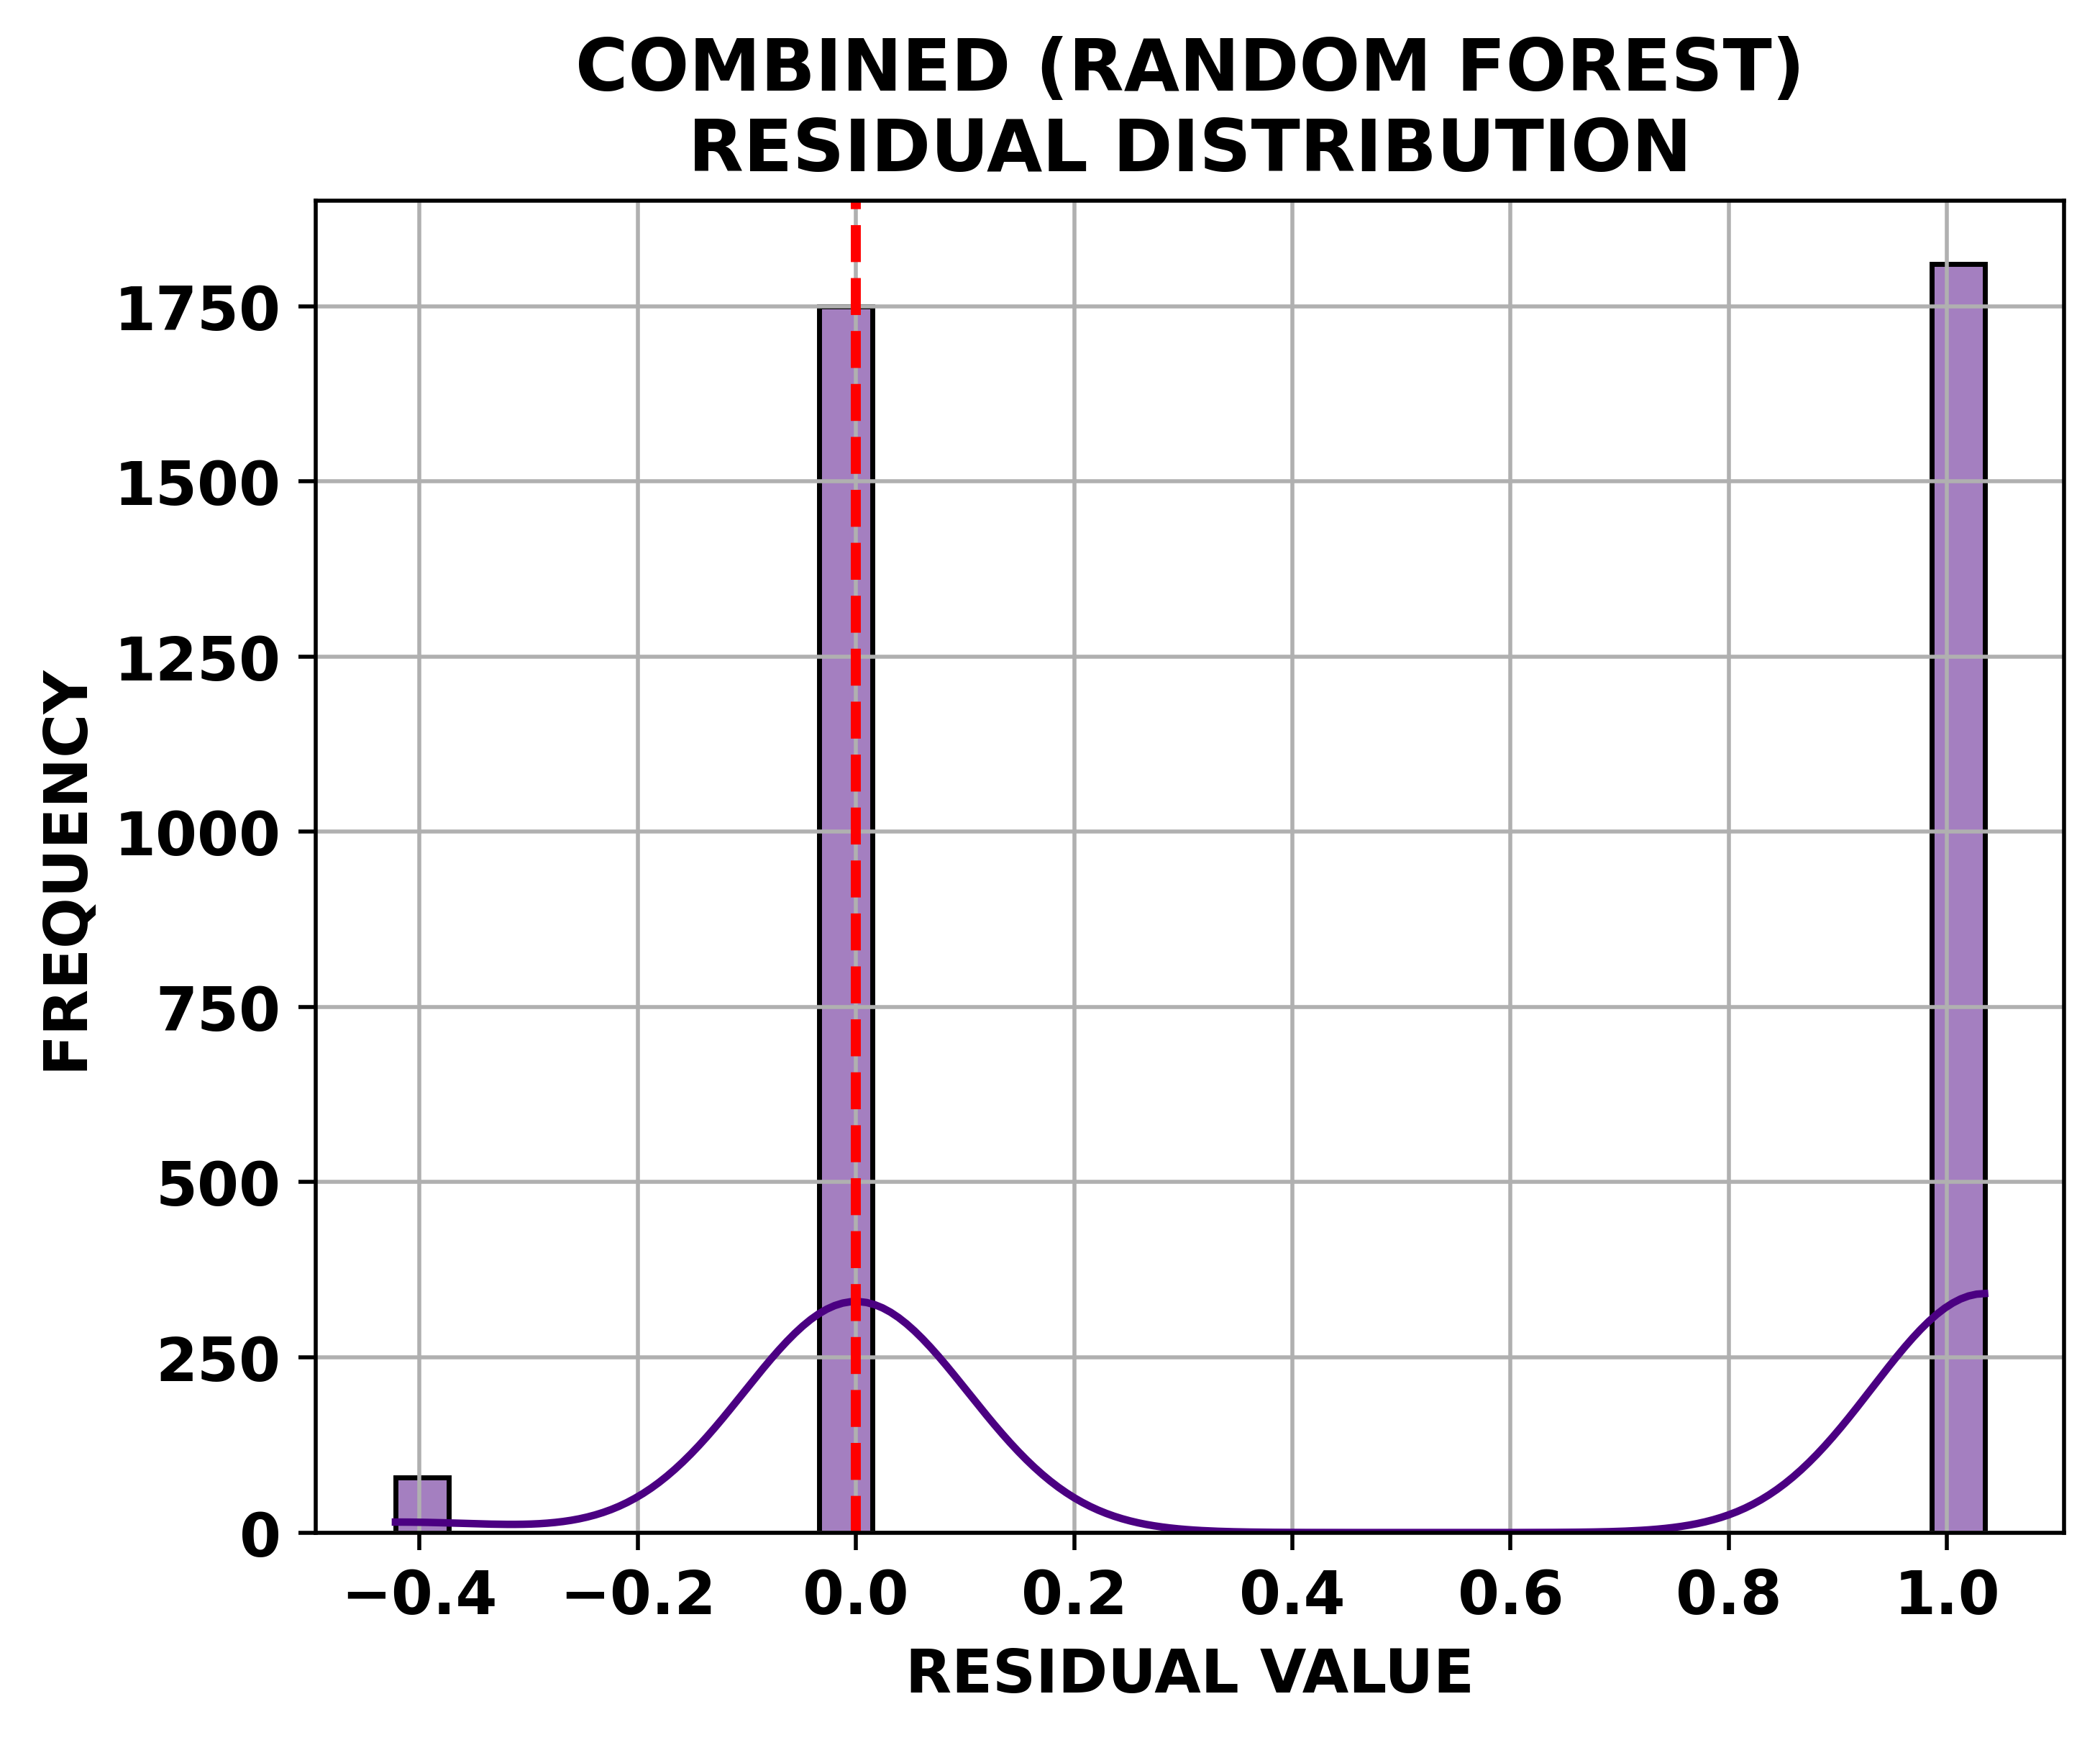

1       -1.421085e-13
14      -2.415845e-13
16      -2.415845e-13
24      -2.415845e-13
25      -2.415845e-13
             ...     
12691    1.034500e+00
12692    1.034500e+00
12693    1.034500e+00
12694    1.034500e+00
12695    1.034500e+00
Name: Cs, Length: 3639, dtype: float64

In [45]:
plot_residuals(*data_splits_robust['CV'], 'CV-Only', 'teal')
plot_residuals(*data_splits_robust['GCD'], 'GCD-Only', 'darkorange')
plot_residuals(*data_splits_robust['COMBINED'], 'Combined', 'indigo')

## 6. POST-TRAINING ANALYSIS & METHOD COMPARISON

### 6.1 DIRECT COMPARISON: WHICH METHOD INFLUENCES THE MODEL MORE?

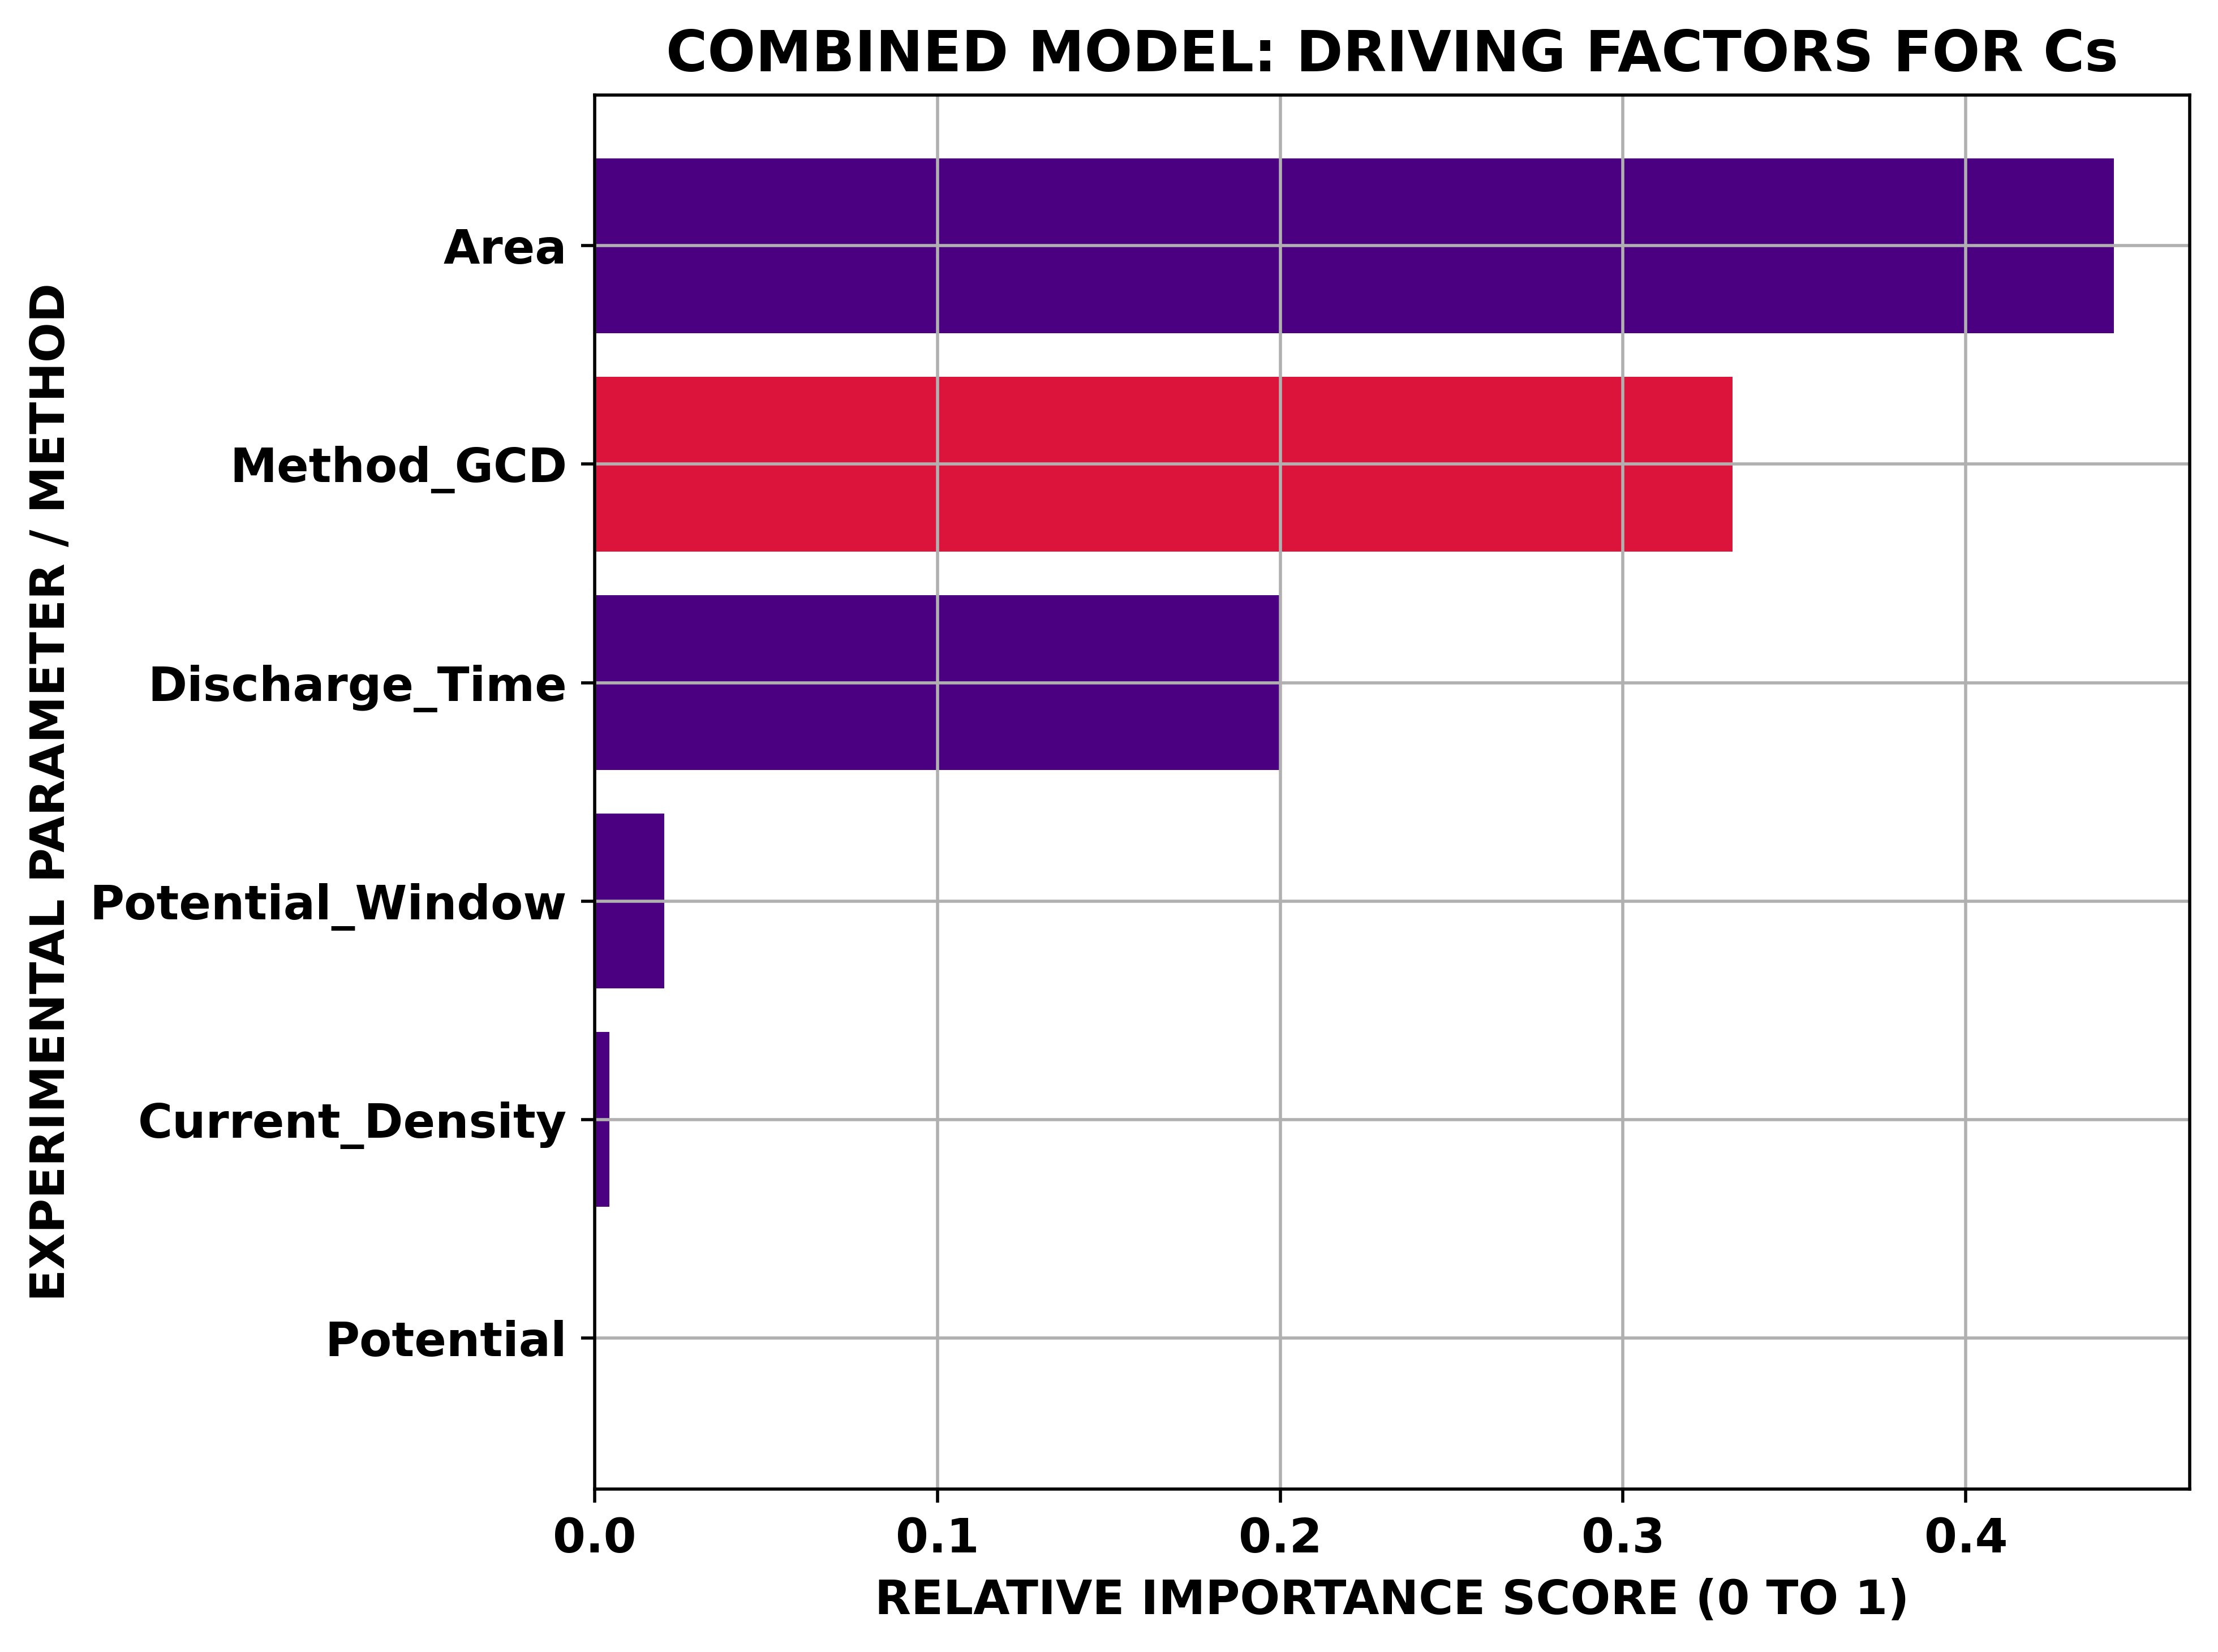

In [46]:
def extract_and_train_combined(X_train, X_test, y_train, y_test):
    """
    TRAINS THE BEST MODEL ON THE COMBINED DATASET TO COMPARE CV VS GCD INFLUENCE.
    """
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # USING GRADIENT BOOSTING AS IT IS HIGHLY ROBUST TO NON-LINEAR TABULAR DATA
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    return model, X_test.columns

comb_model, comb_features = extract_and_train_combined(*data_splits_robust['COMBINED'])

def plot_comparative_feature_importance(model, feature_names):
    """
    PLOTS THE IMPORTANCE OF COMBINED FEATURES, SPECIFICALLY HIGHLIGHTING 
    THE INFLUENCE OF THE EXPERIMENTAL METHOD ON THE OVERALL TARGET.
    """
    importances = model.feature_importances_
    feat_df = pd.DataFrame({'FEATURE': feature_names, 'IMPORTANCE': importances})
    feat_df = feat_df.sort_values(by='IMPORTANCE', ascending=True)
    
    # HIGHLIGHT THE 'METHOD' FLAG TO SEE ITS INFLUENCE
    colors = ['crimson' if 'Method' in feat else 'indigo' for feat in feat_df['FEATURE']]
    
    plt.figure()
    plt.barh(feat_df['FEATURE'], feat_df['IMPORTANCE'], color=colors)
    plt.title('COMBINED MODEL: DRIVING FACTORS FOR Cs')
    plt.xlabel('RELATIVE IMPORTANCE SCORE (0 TO 1)')
    plt.ylabel('EXPERIMENTAL PARAMETER / METHOD')
    plt.tight_layout()
    plt.show()

# RUN THE COMPARISON PLOT
plot_comparative_feature_importance(comb_model, comb_features)

### 6.1.2 INDIVIDUAL MODEL FEATURE IMPORTANCE (LEAKAGE-FREE)

NOW WE EVALUATE THE DRIVING FACTORS FOR Cs WITHIN EACH INDIVIDUAL METHOD USING THE LEAKAGE-FREE (GROUP-SPLIT) DATASETS AND ROBUST SCALING.

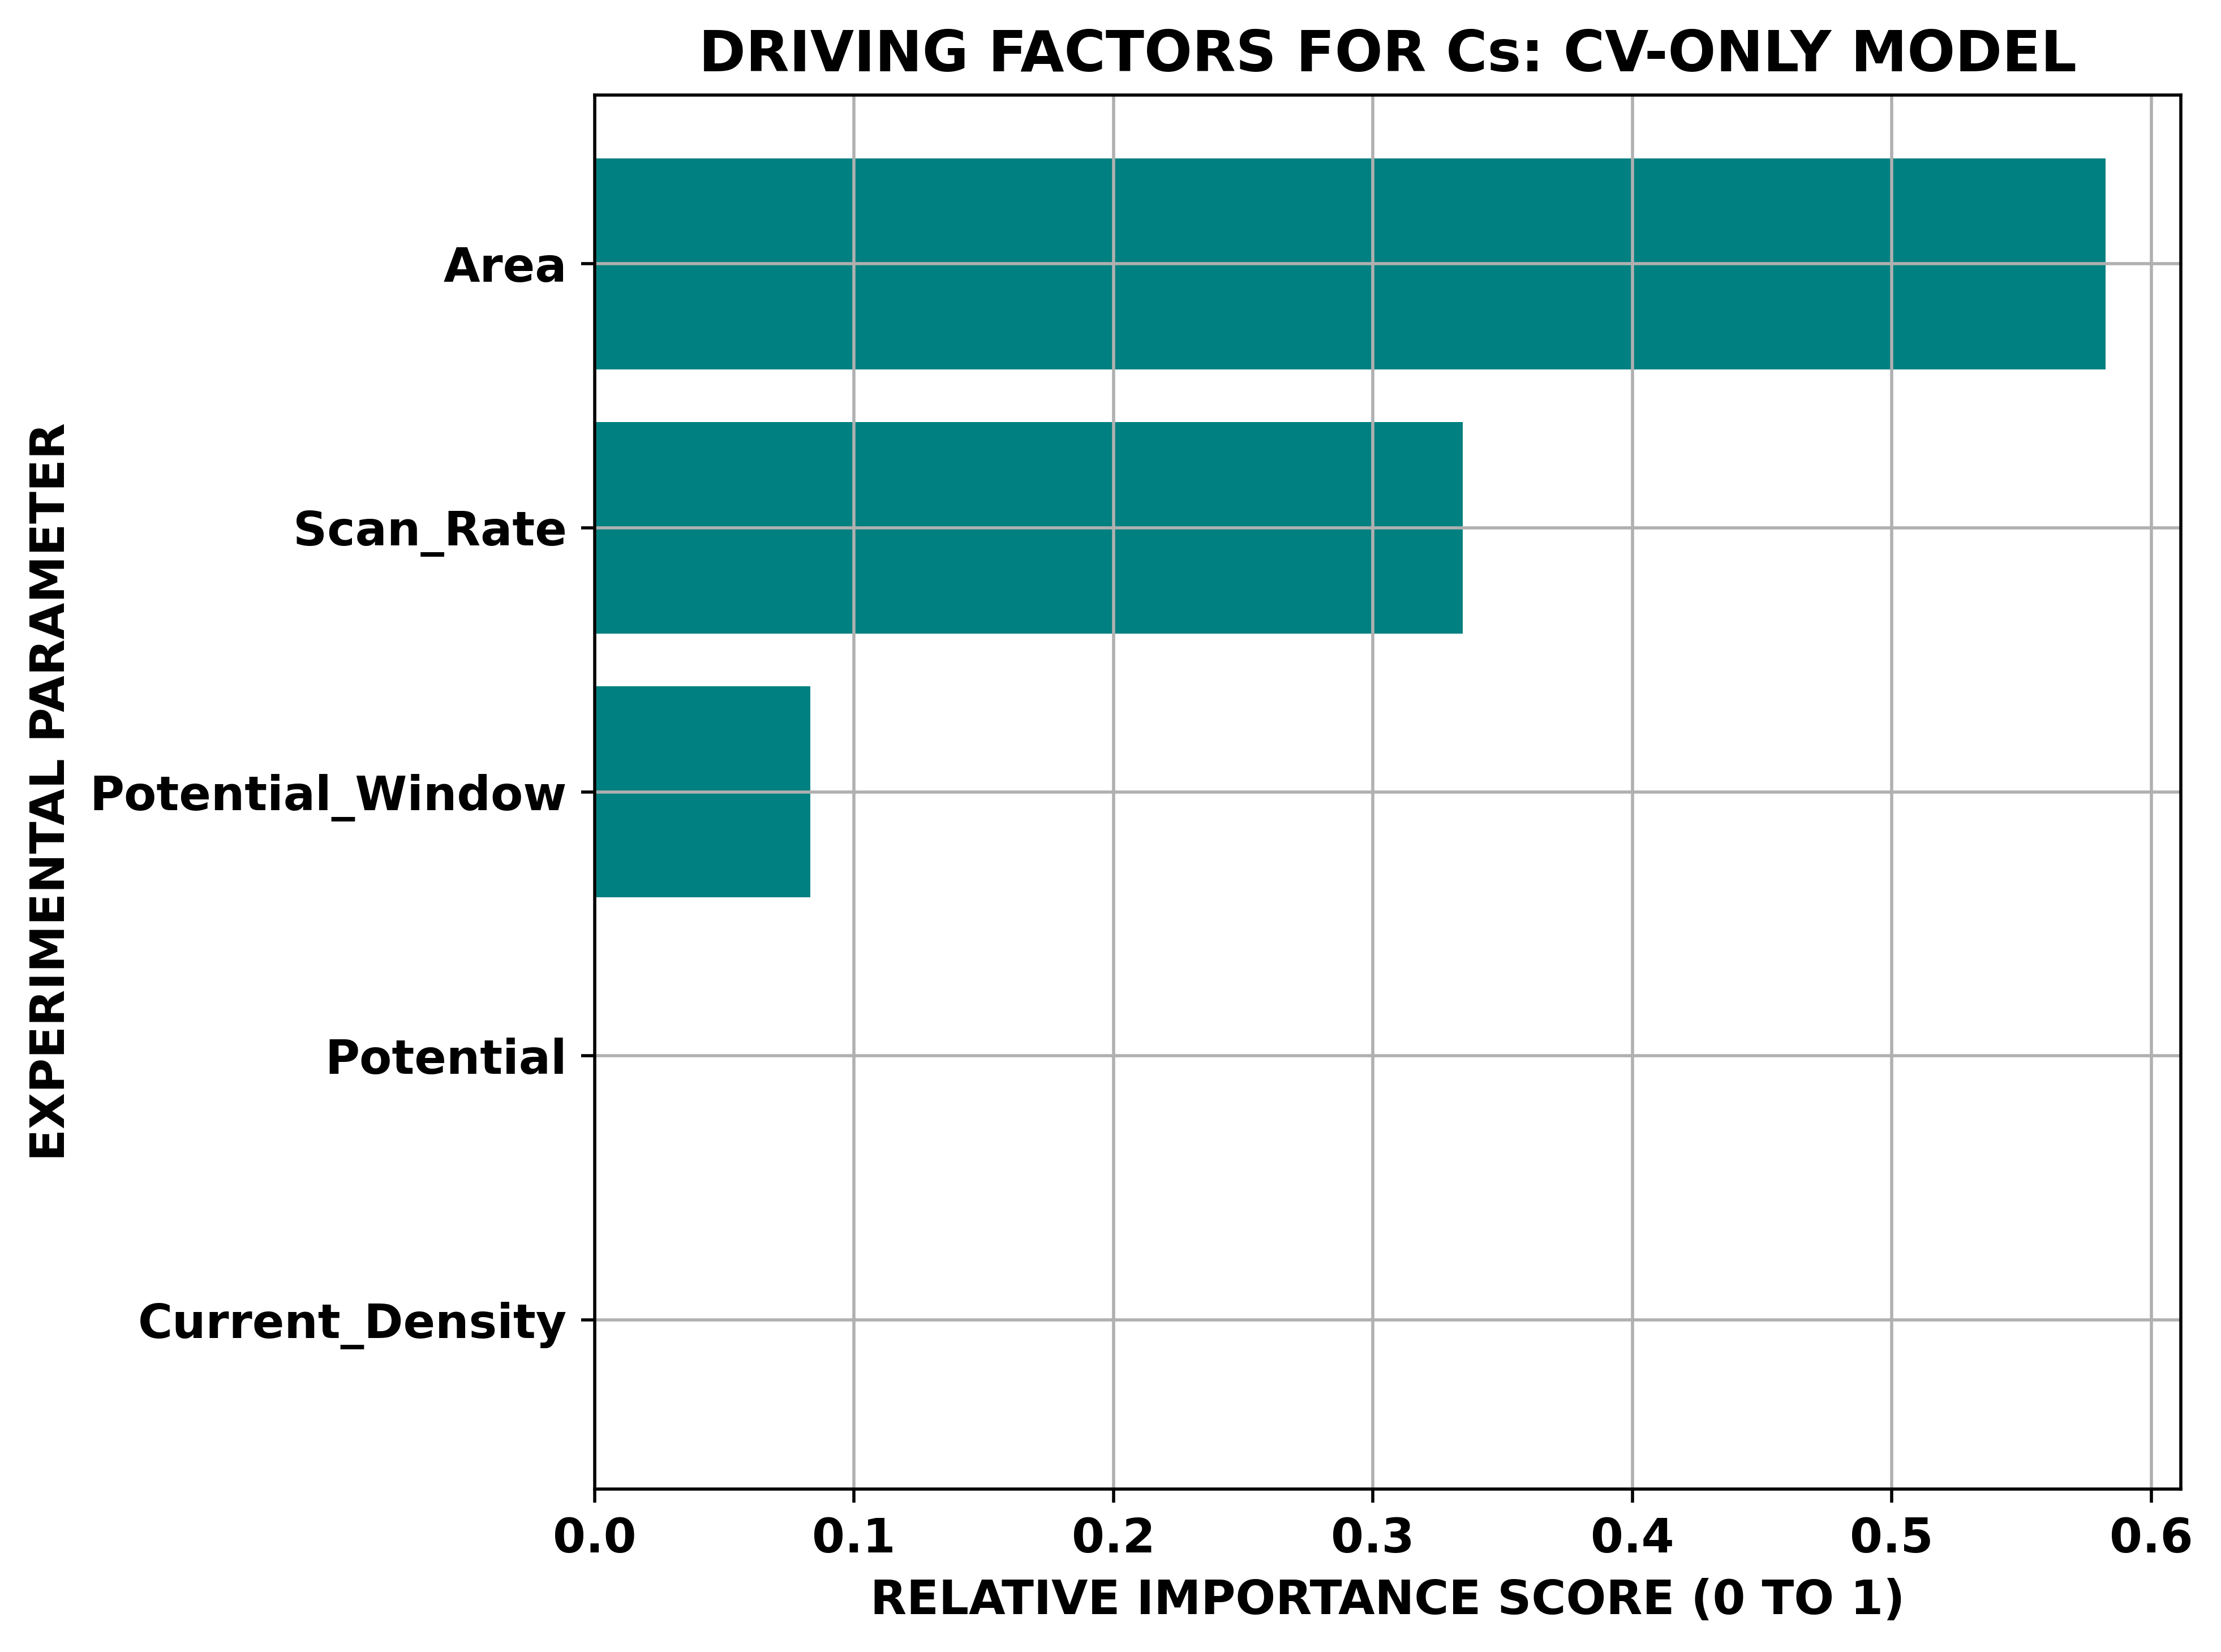

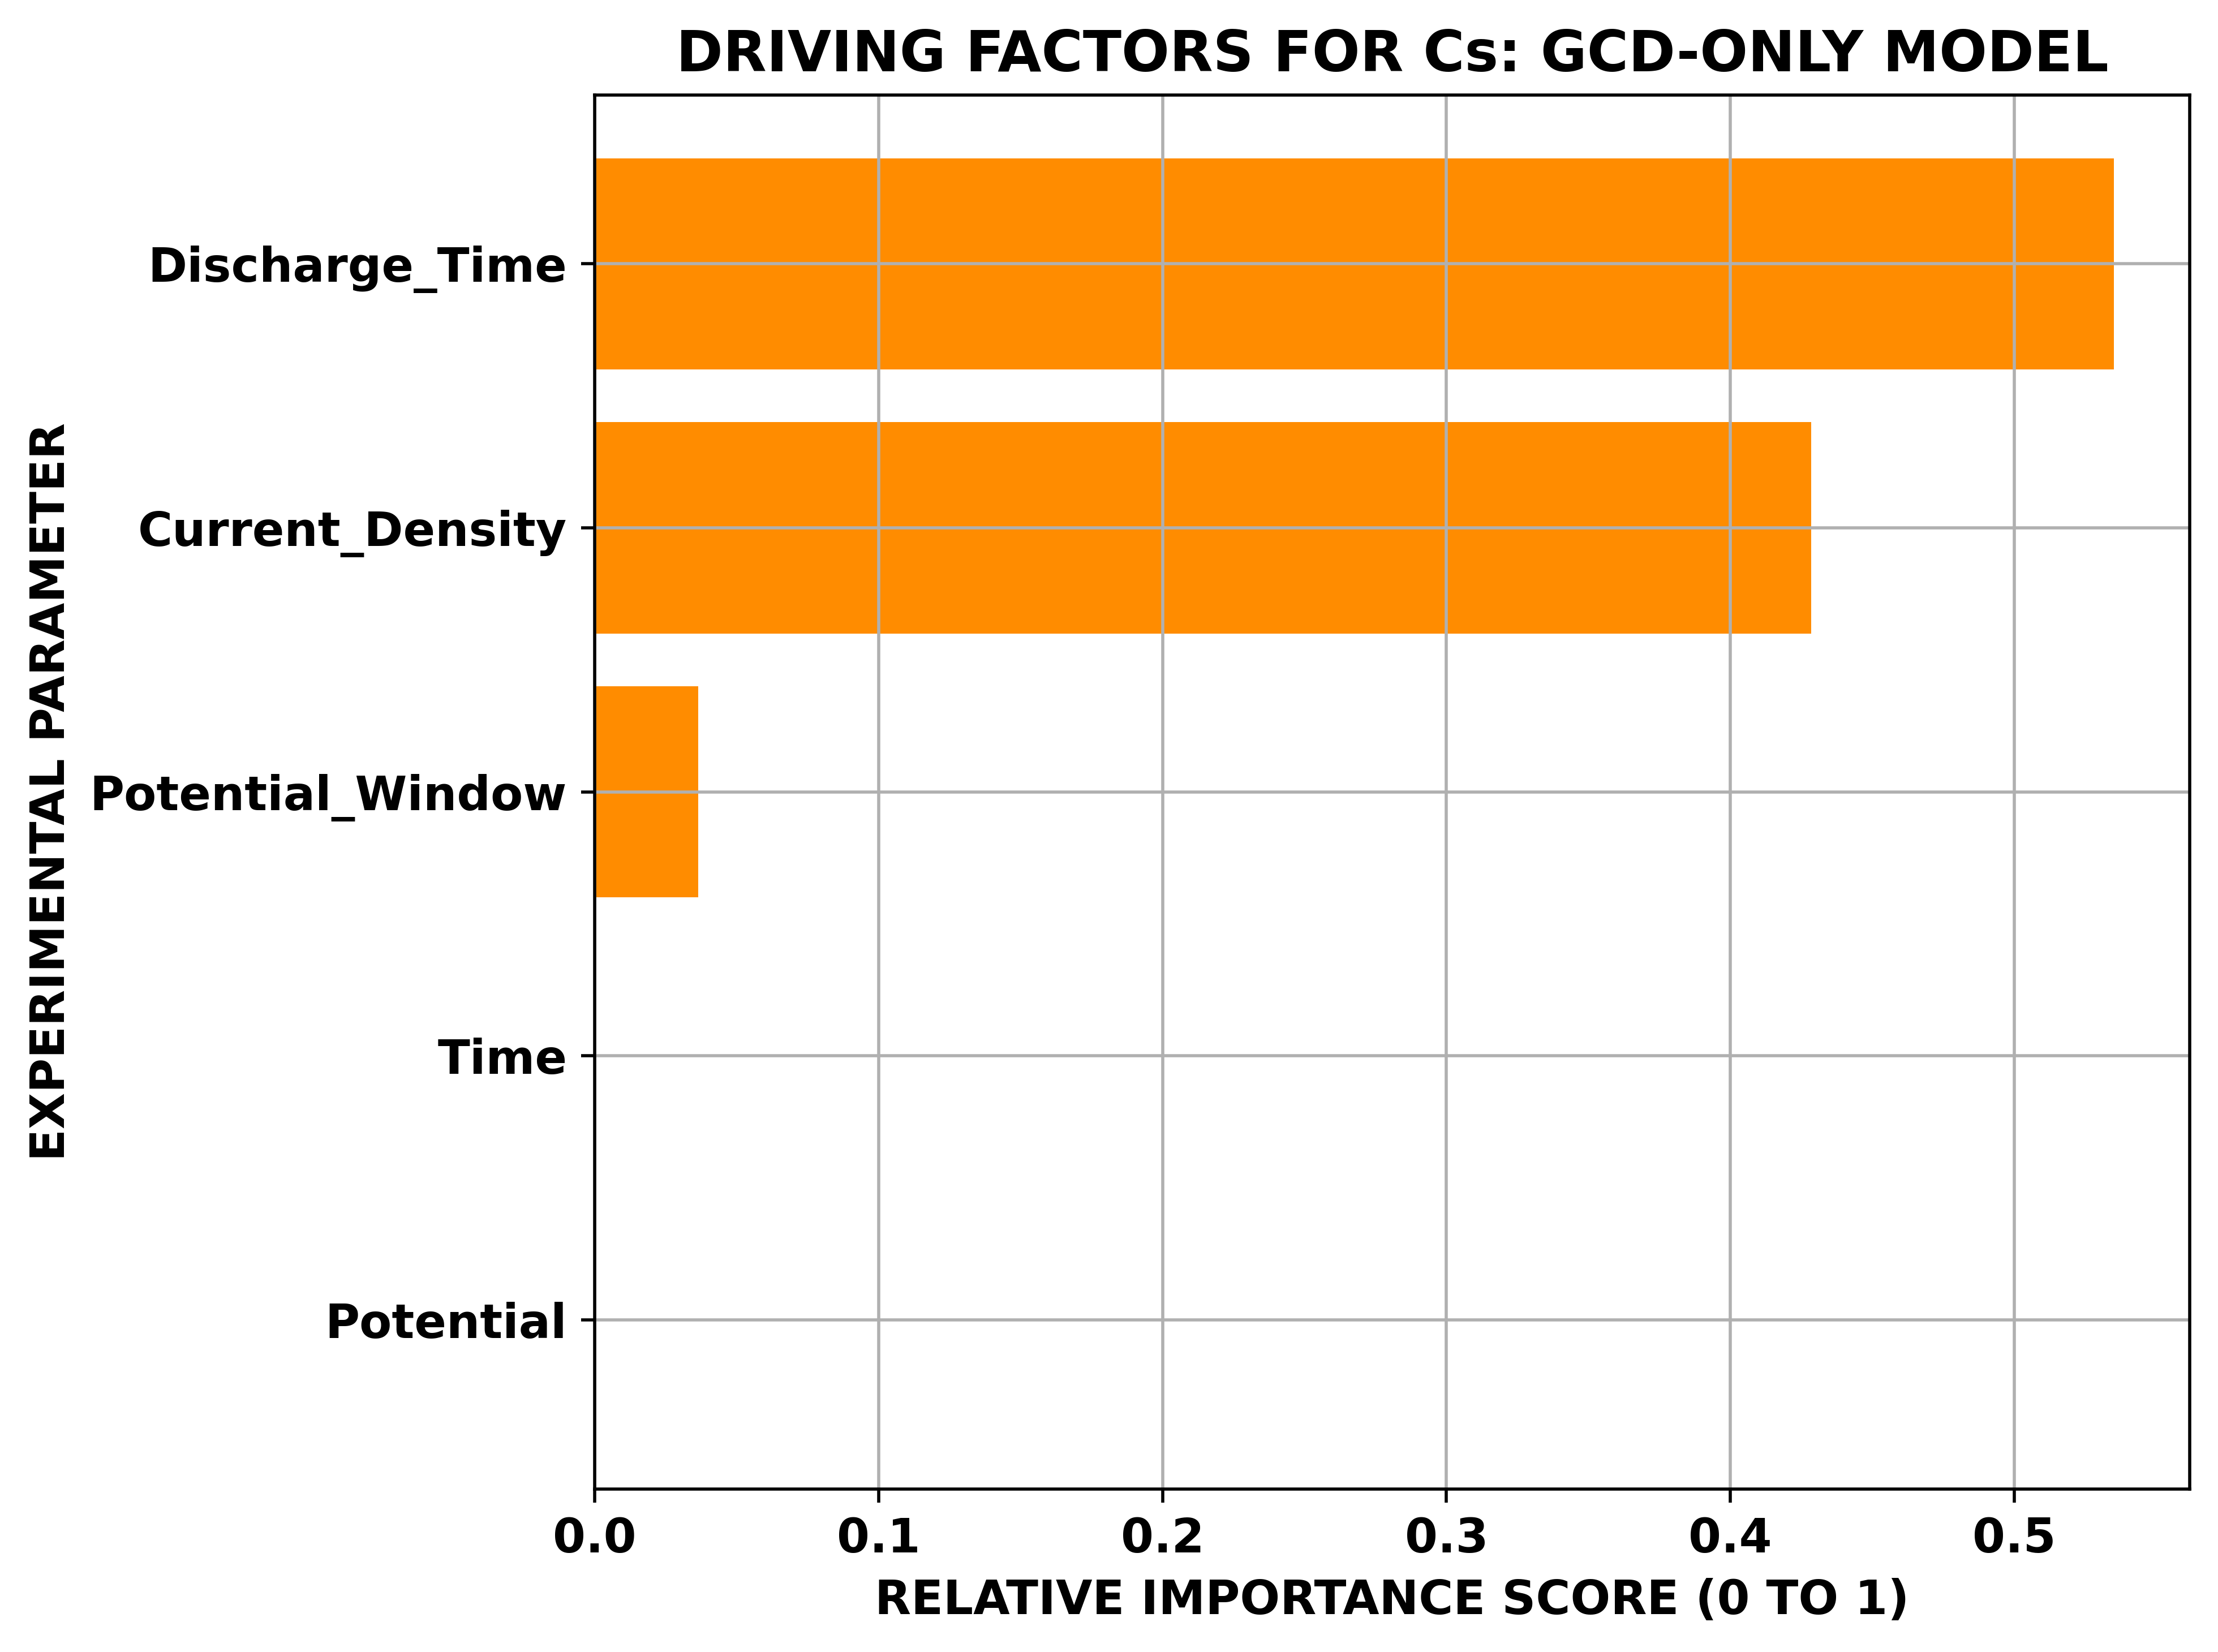

In [47]:
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import matplotlib.pyplot as plt

def train_and_evaluate_individual(X_train, y_train, dataset_name: str, color: str):
    """
    TRAINS A MODEL ON THE LEAKAGE-FREE INDIVIDUAL DATASET 
    AND PLOTS THE FEATURE IMPORTANCE SCORES.
    """
    # 1. APPLY ROBUST SCALING
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # 2. TRAIN THE MODEL (GRADIENT BOOSTING FOR TABULAR ROBUSTNESS)
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # 3. EXTRACT FEATURE IMPORTANCES
    importances = model.feature_importances_
    feature_names = X_train.columns
    
    feat_df = pd.DataFrame({'FEATURE': feature_names, 'IMPORTANCE': importances})
    feat_df = feat_df.sort_values(by='IMPORTANCE', ascending=True)
    
    # 4. PLOT
    plt.figure()
    plt.barh(feat_df['FEATURE'], feat_df['IMPORTANCE'], color=color)
    plt.title(f'DRIVING FACTORS FOR Cs: {dataset_name.upper()}')
    plt.xlabel('RELATIVE IMPORTANCE SCORE (0 TO 1)')
    plt.ylabel('EXPERIMENTAL PARAMETER')
    plt.tight_layout()
    plt.show()

# EXTRACT LEAKAGE-FREE TRAINING DATA FROM OUR PREVIOUS DICTIONARY
X_train_cv, _, y_train_cv, _ = data_splits_robust['CV']
X_train_gcd, _, y_train_gcd, _ = data_splits_robust['GCD']

# RUN THE ANALYSIS FOR CV-ONLY
train_and_evaluate_individual(
    X_train=X_train_cv, 
    y_train=y_train_cv, 
    dataset_name='CV-Only Model', 
    color='teal'
)

# RUN THE ANALYSIS FOR GCD-ONLY
train_and_evaluate_individual(
    X_train=X_train_gcd, 
    y_train=y_train_gcd, 
    dataset_name='GCD-Only Model', 
    color='darkorange'
)

### 6.2 SHAP ANALYSIS: THE TRUE FEATURE CONTRIBUTION


=== GENERATING SHAP ANALYSIS FOR CV-ONLY ===


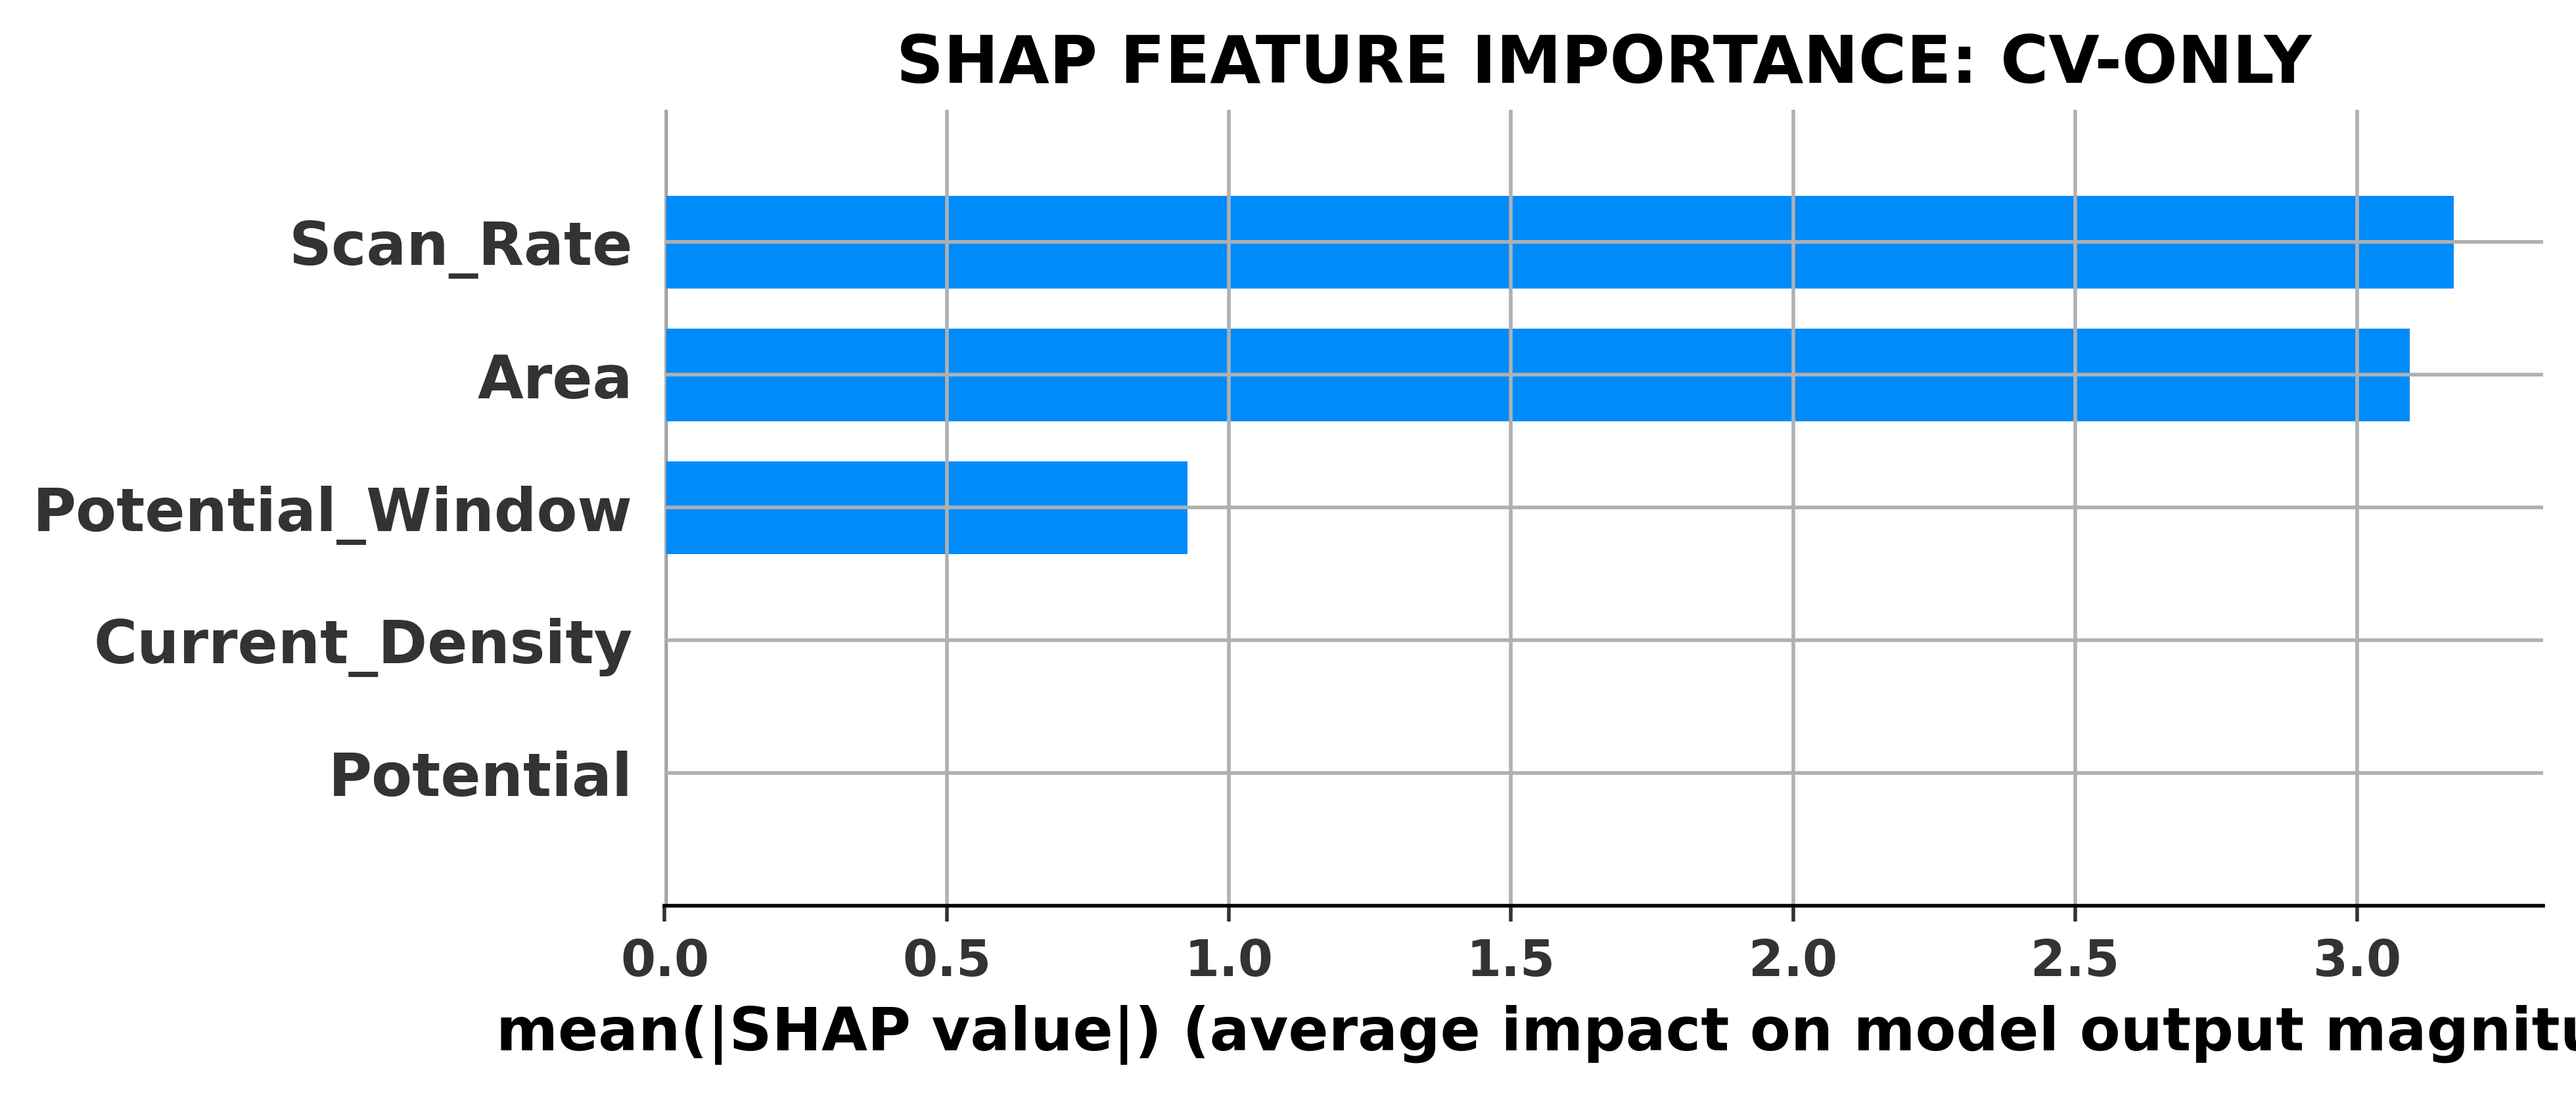

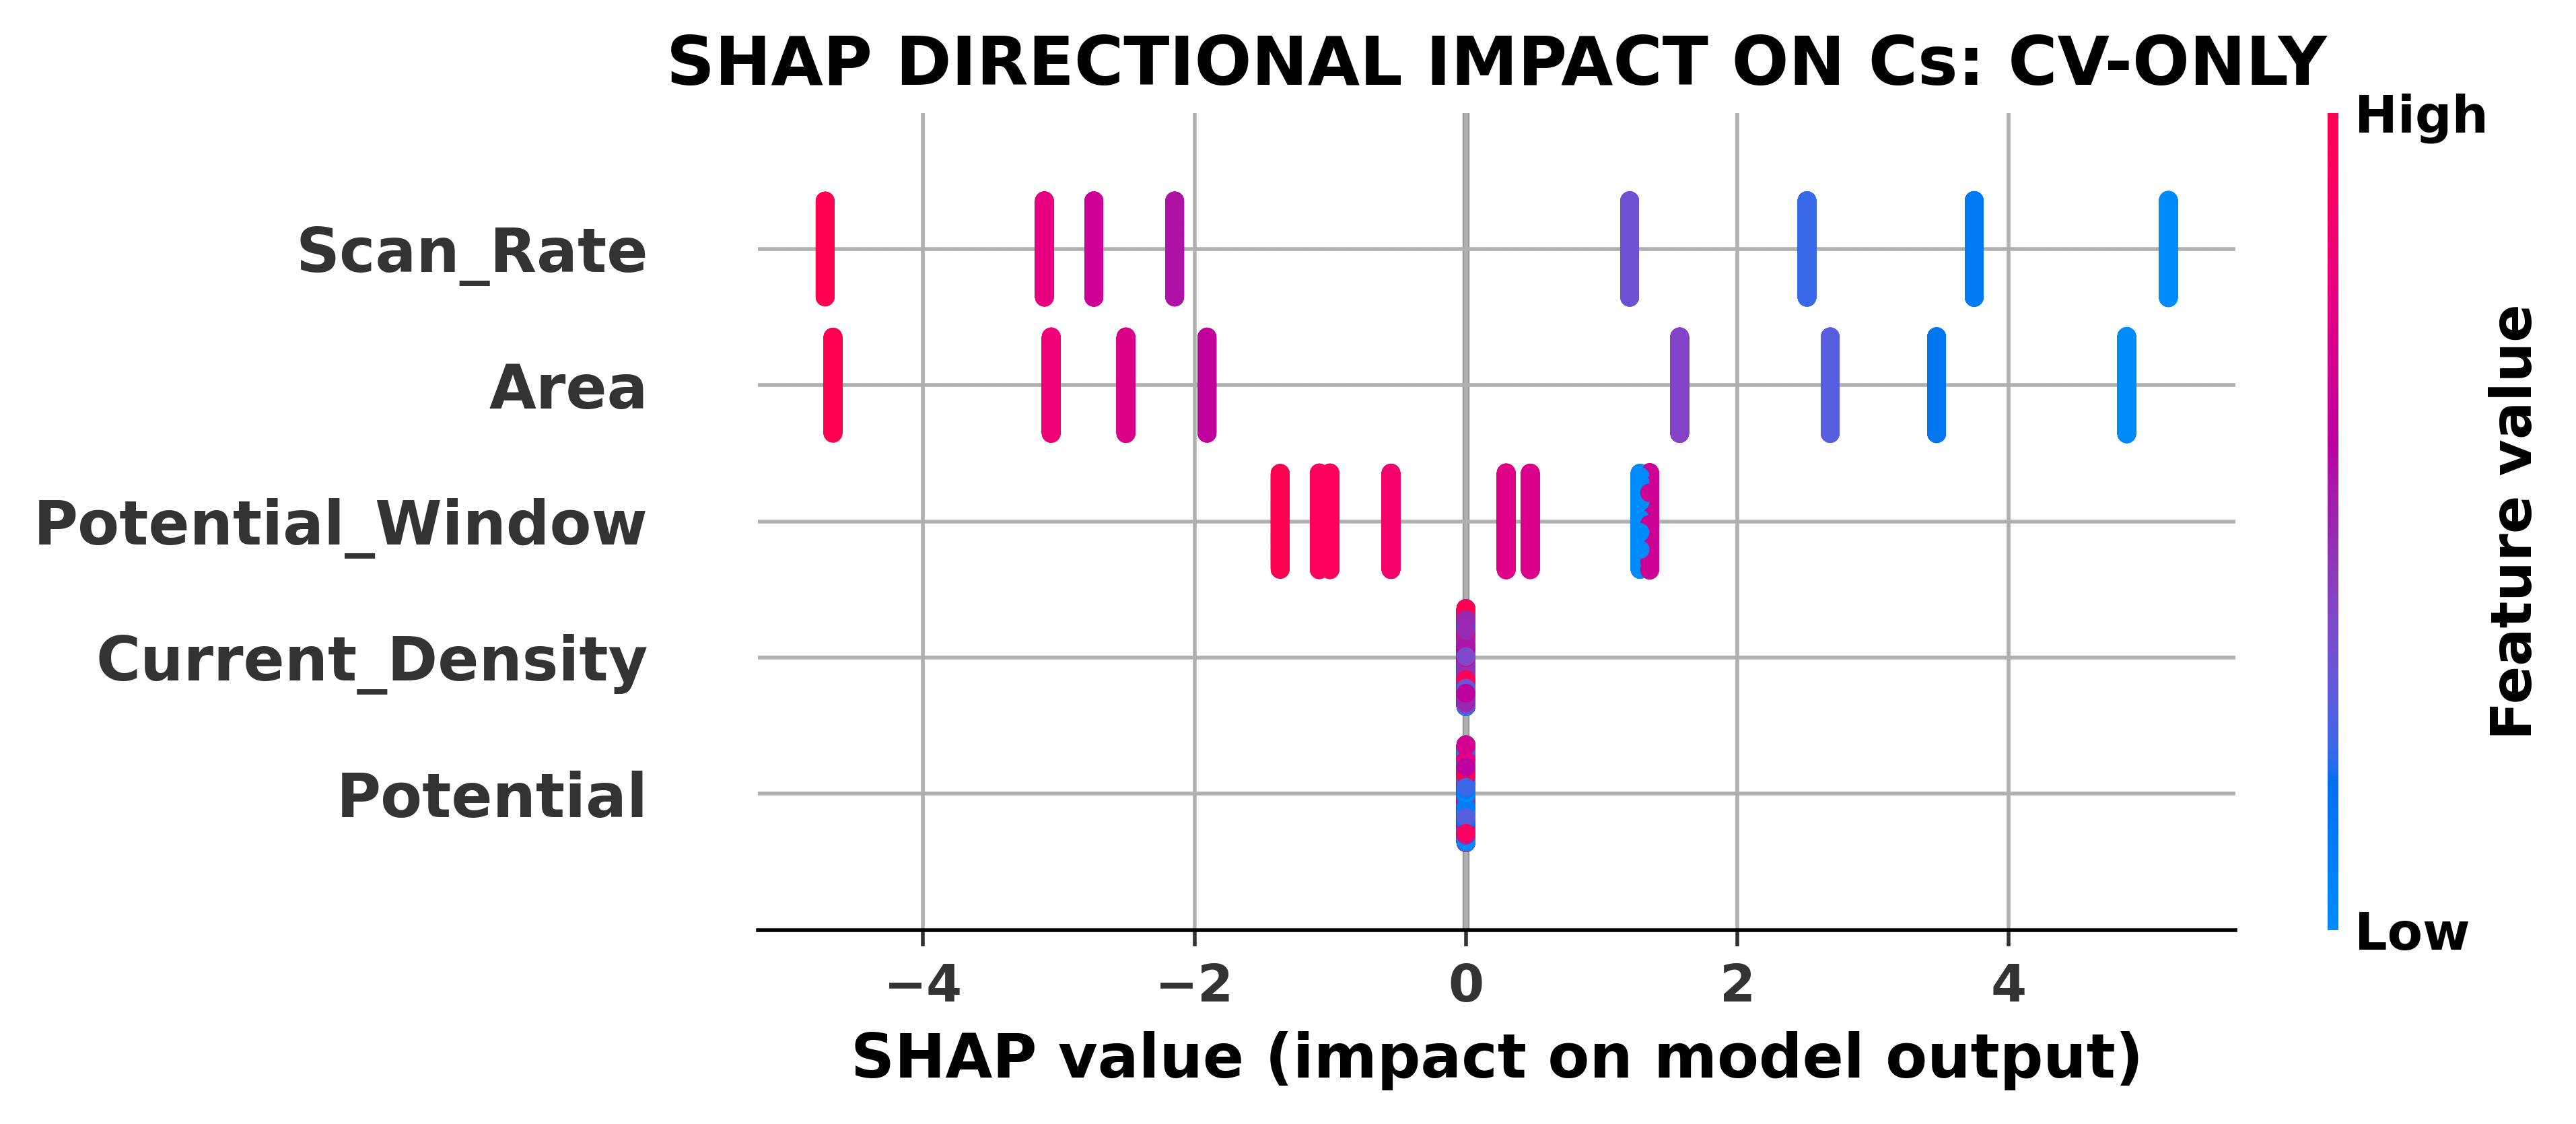


=== GENERATING SHAP ANALYSIS FOR GCD-ONLY ===


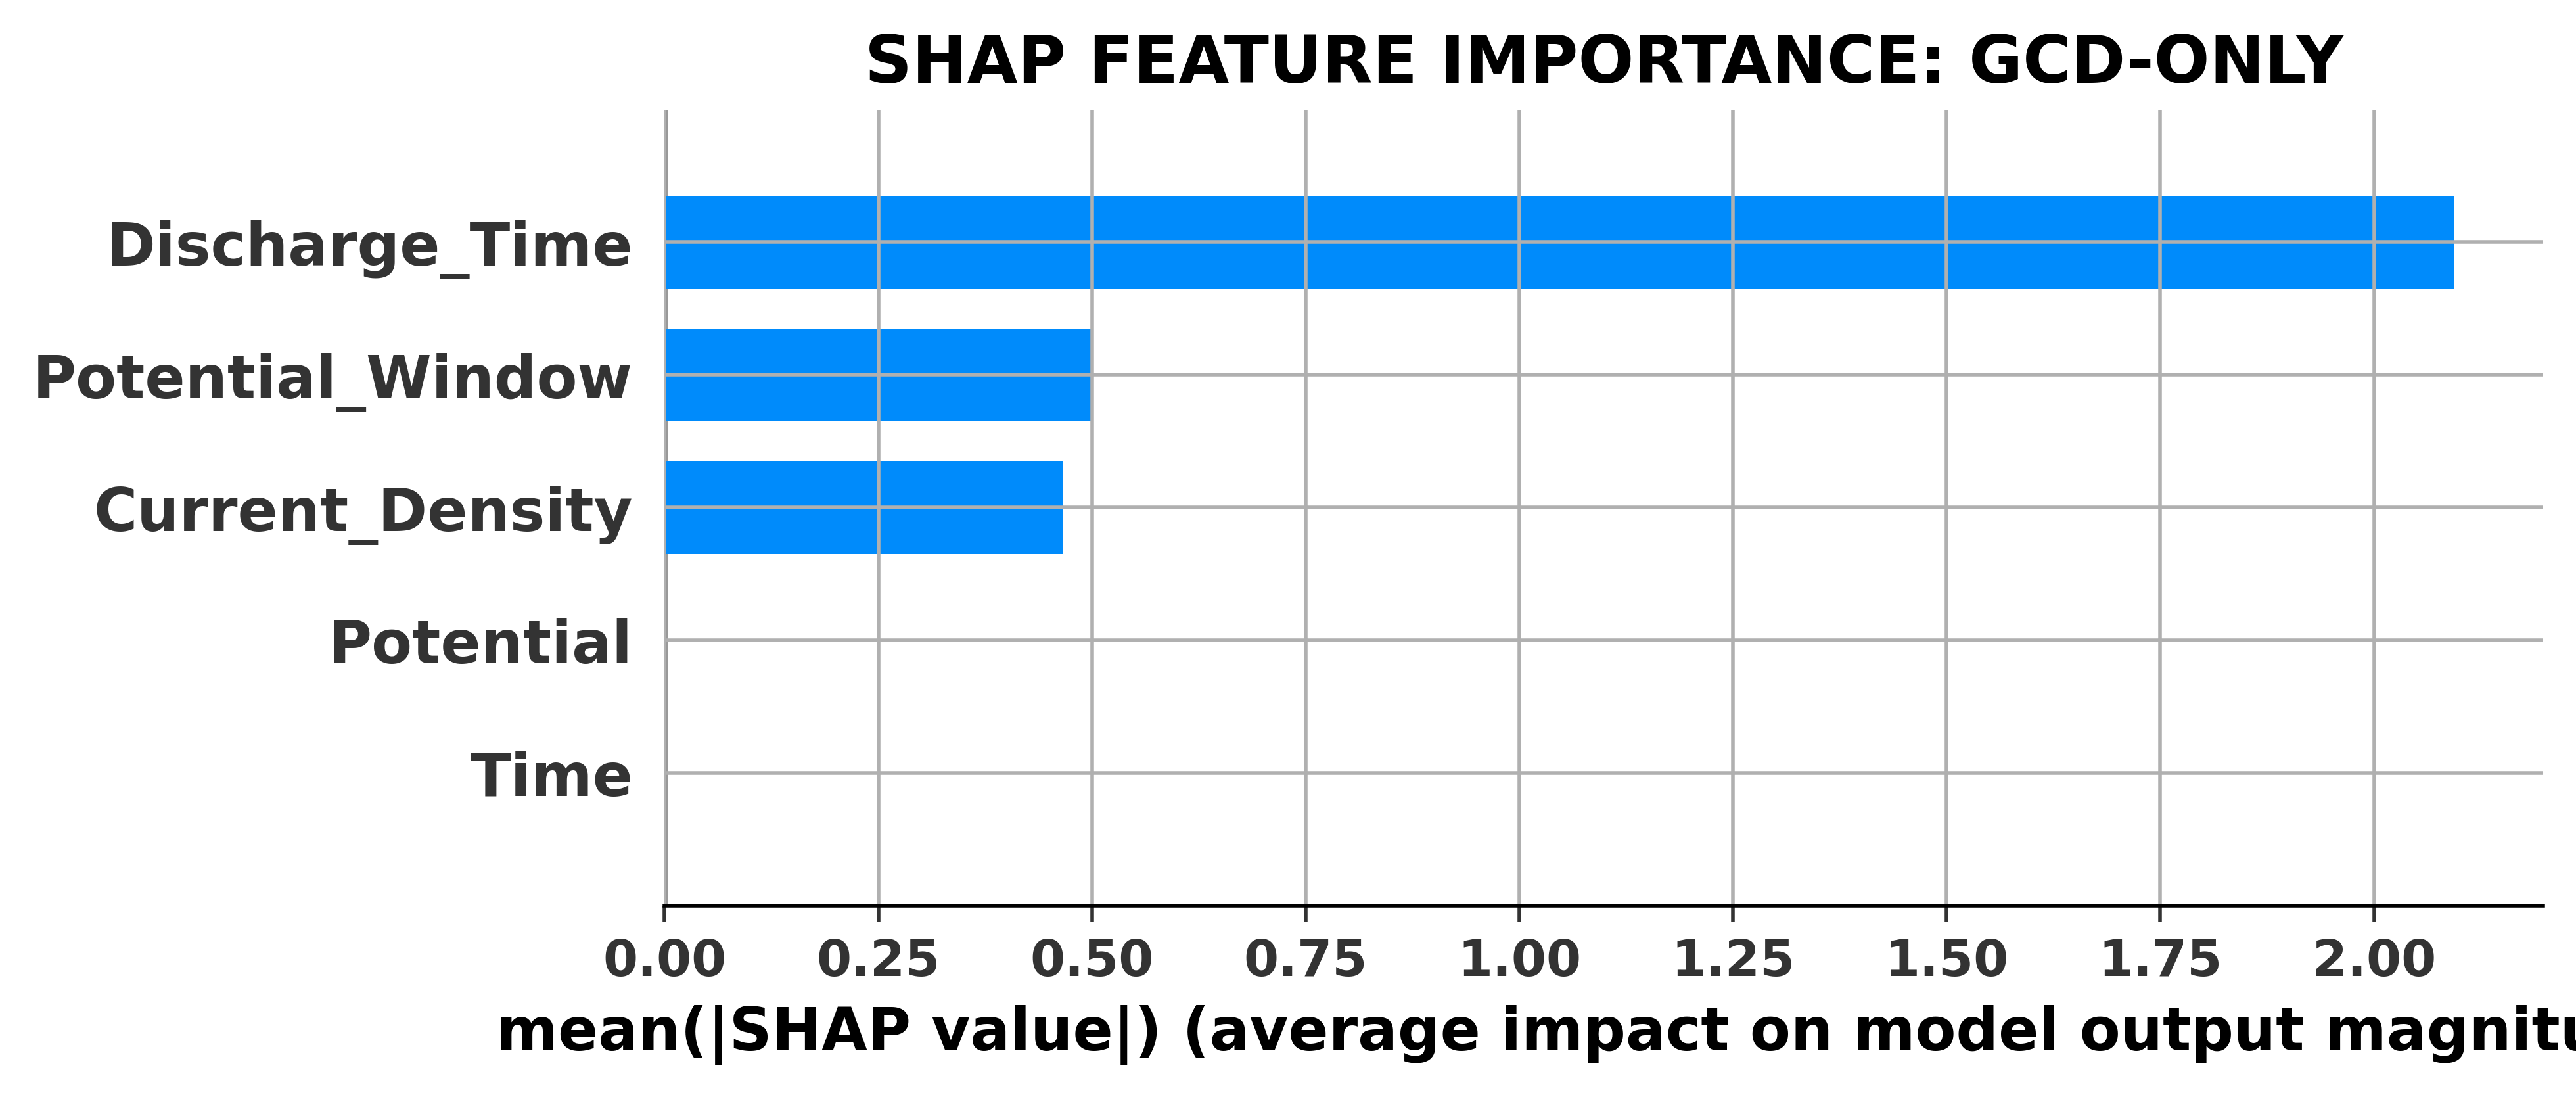

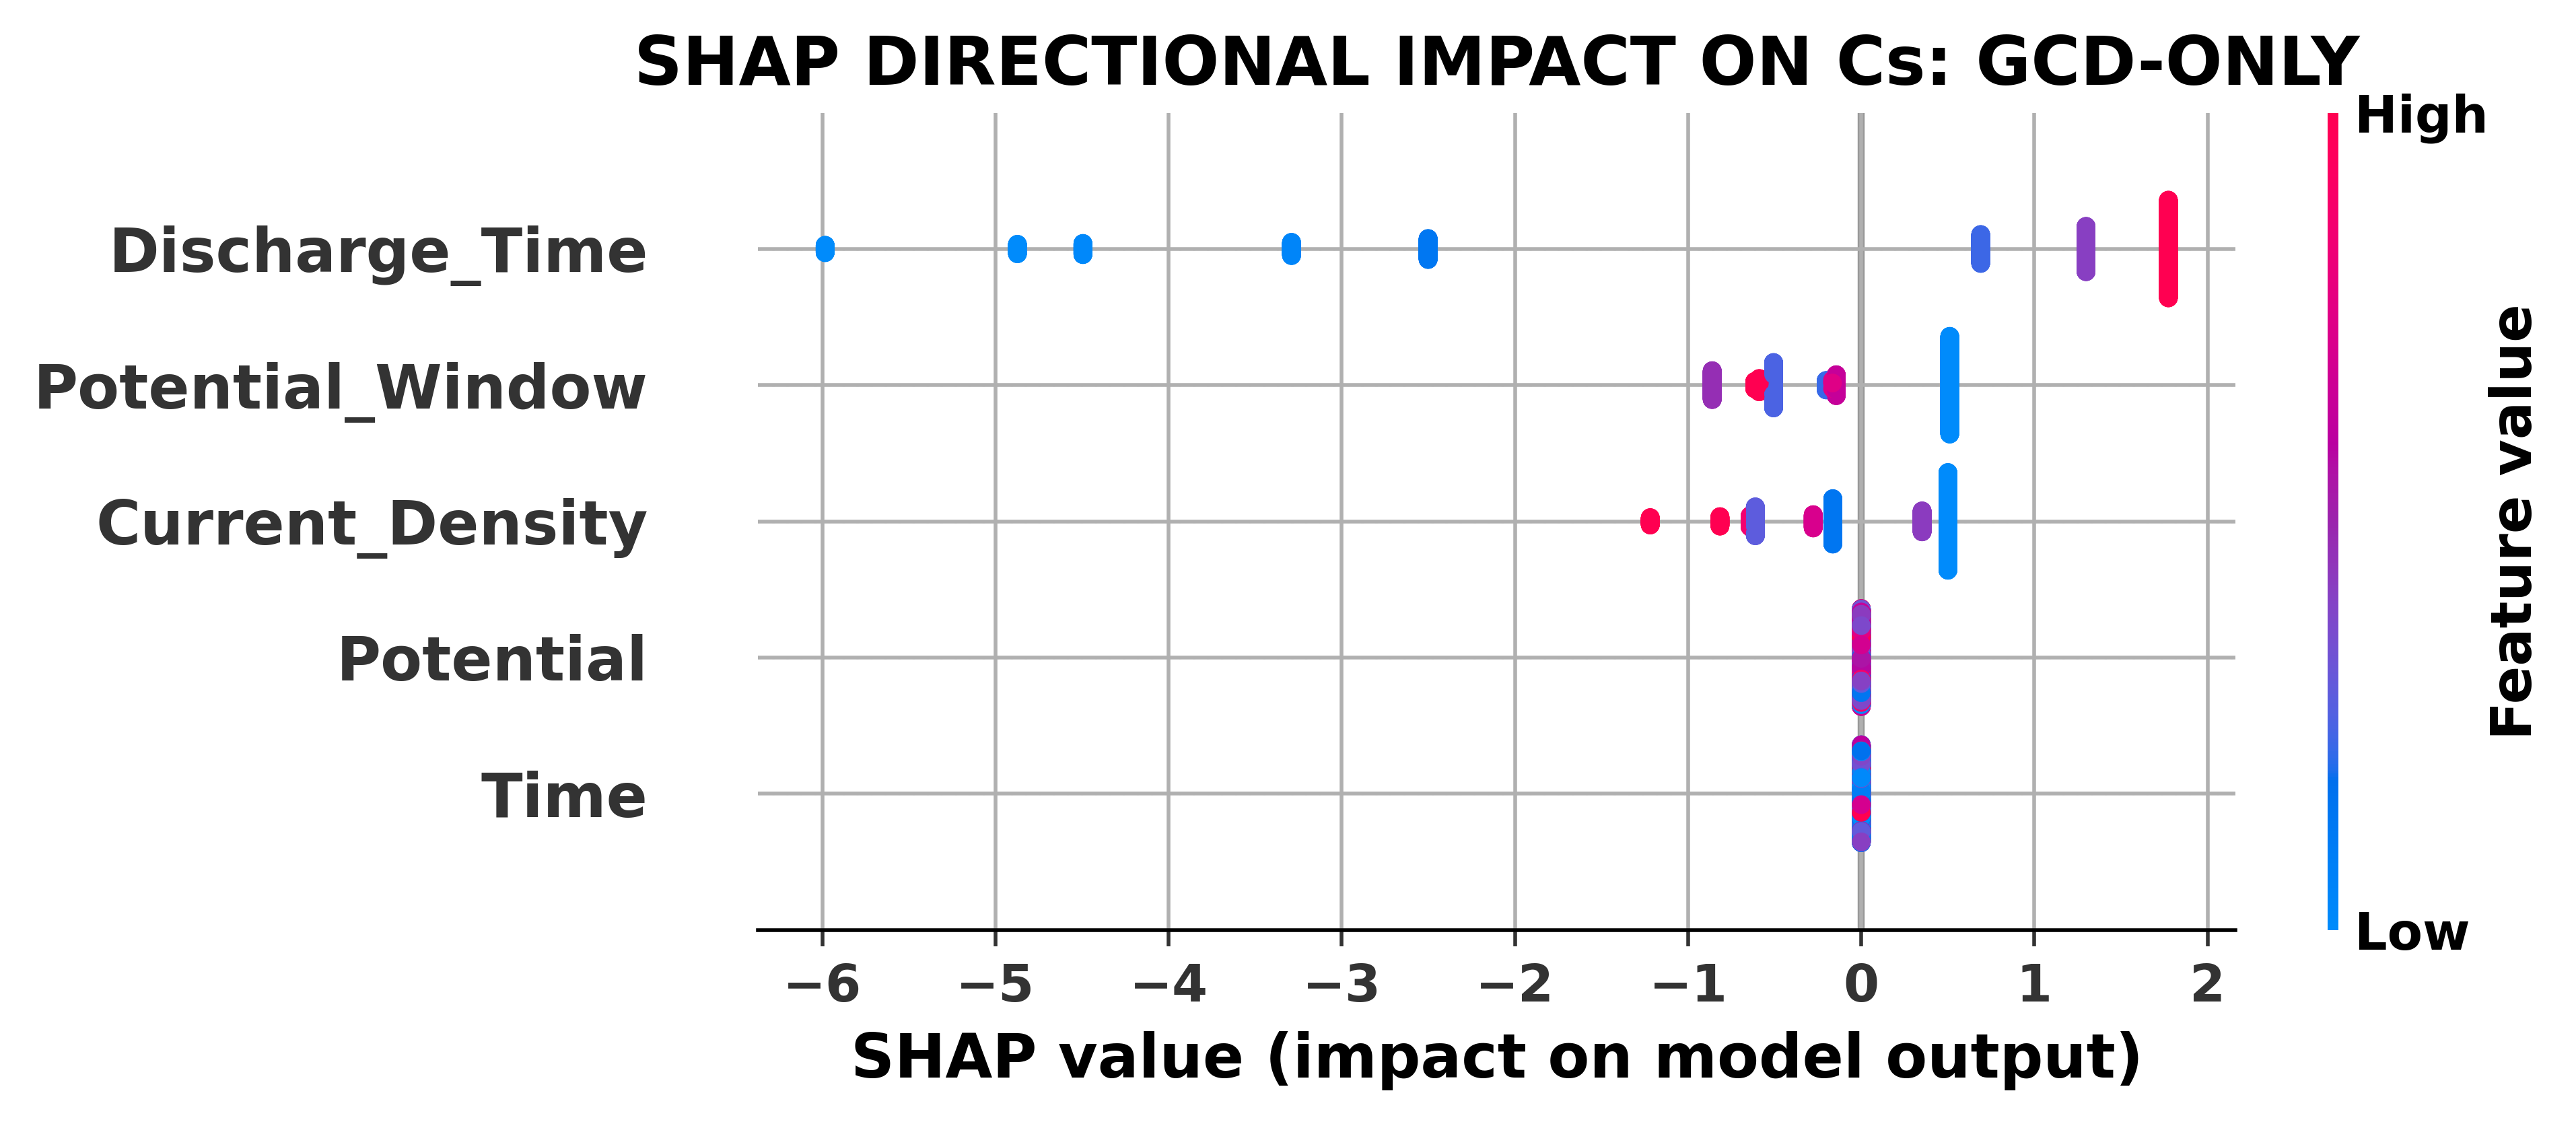

In [48]:
import shap

def plot_shap_analysis(model, X_train, dataset_name: str):
    """
    GENERATES SHAP SUMMARY PLOTS TO REVEAL THE DIRECTIONAL IMPACT 
    AND TRUE IMPORTANCE OF EXPERIMENTAL PARAMETERS ON Cs.
    """
    print(f"\n=== GENERATING SHAP ANALYSIS FOR {dataset_name.upper()} ===")
    
    # SHAP REQUIRES THE ORIGINAL FEATURE DATAFRAME FOR LABELING
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    # SHAP SUMMARY PLOT (BAR) - REPLACES STANDARD FEATURE IMPORTANCE
    plt.figure()
    shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
    plt.title(f'SHAP FEATURE IMPORTANCE: {dataset_name.upper()}')
    plt.tight_layout()
    plt.show()

    # SHAP SUMMARY PLOT (DOT) - SHOWS DIRECTIONAL IMPACT (POSITIVE/NEGATIVE)
    plt.figure()
    shap.summary_plot(shap_values, X_train, show=False)
    plt.title(f'SHAP DIRECTIONAL IMPACT ON Cs: {dataset_name.upper()}')
    plt.tight_layout()
    plt.show()

# WE MUST RETRAIN QUICKLY TO PASS THE RAW DATAFRAMES (NOT NUMPY ARRAYS) TO SHAP
X_train_cv_raw = data_splits_robust['CV'][0]
y_train_cv_raw = data_splits_robust['CV'][2]
best_cv_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
best_cv_model.fit(X_train_cv_raw, y_train_cv_raw)

X_train_gcd_raw = data_splits_robust['GCD'][0]
y_train_gcd_raw = data_splits_robust['GCD'][2]
best_gcd_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
best_gcd_model.fit(X_train_gcd_raw, y_train_gcd_raw)

# RUN SHAP FOR INDIVIDUAL METHODS
plot_shap_analysis(best_cv_model, X_train_cv_raw, 'CV-Only')
plot_shap_analysis(best_gcd_model, X_train_gcd_raw, 'GCD-Only')

### 6.3 THE COMBINED METHODOLOGY CORRECTION

TO PROPERLY COMPARE CV AND GCD, WE CANNOT OVERLAP THEIR DYNAMIC AND STATIC VARIABLES. WE WILL CREATE A UNIFIED "RATE_PARAMETER" FEATURE. FOR CV, THIS IS SCAN RATE. FOR GCD, THIS IS CURRENT DENSITY. THIS FORCES THE MODEL TO EVALUATE THE KINETIC DRIVING FORCE EQUITABLY.

=== EXECUTING CORRECTED COMBINED ANALYSIS ===


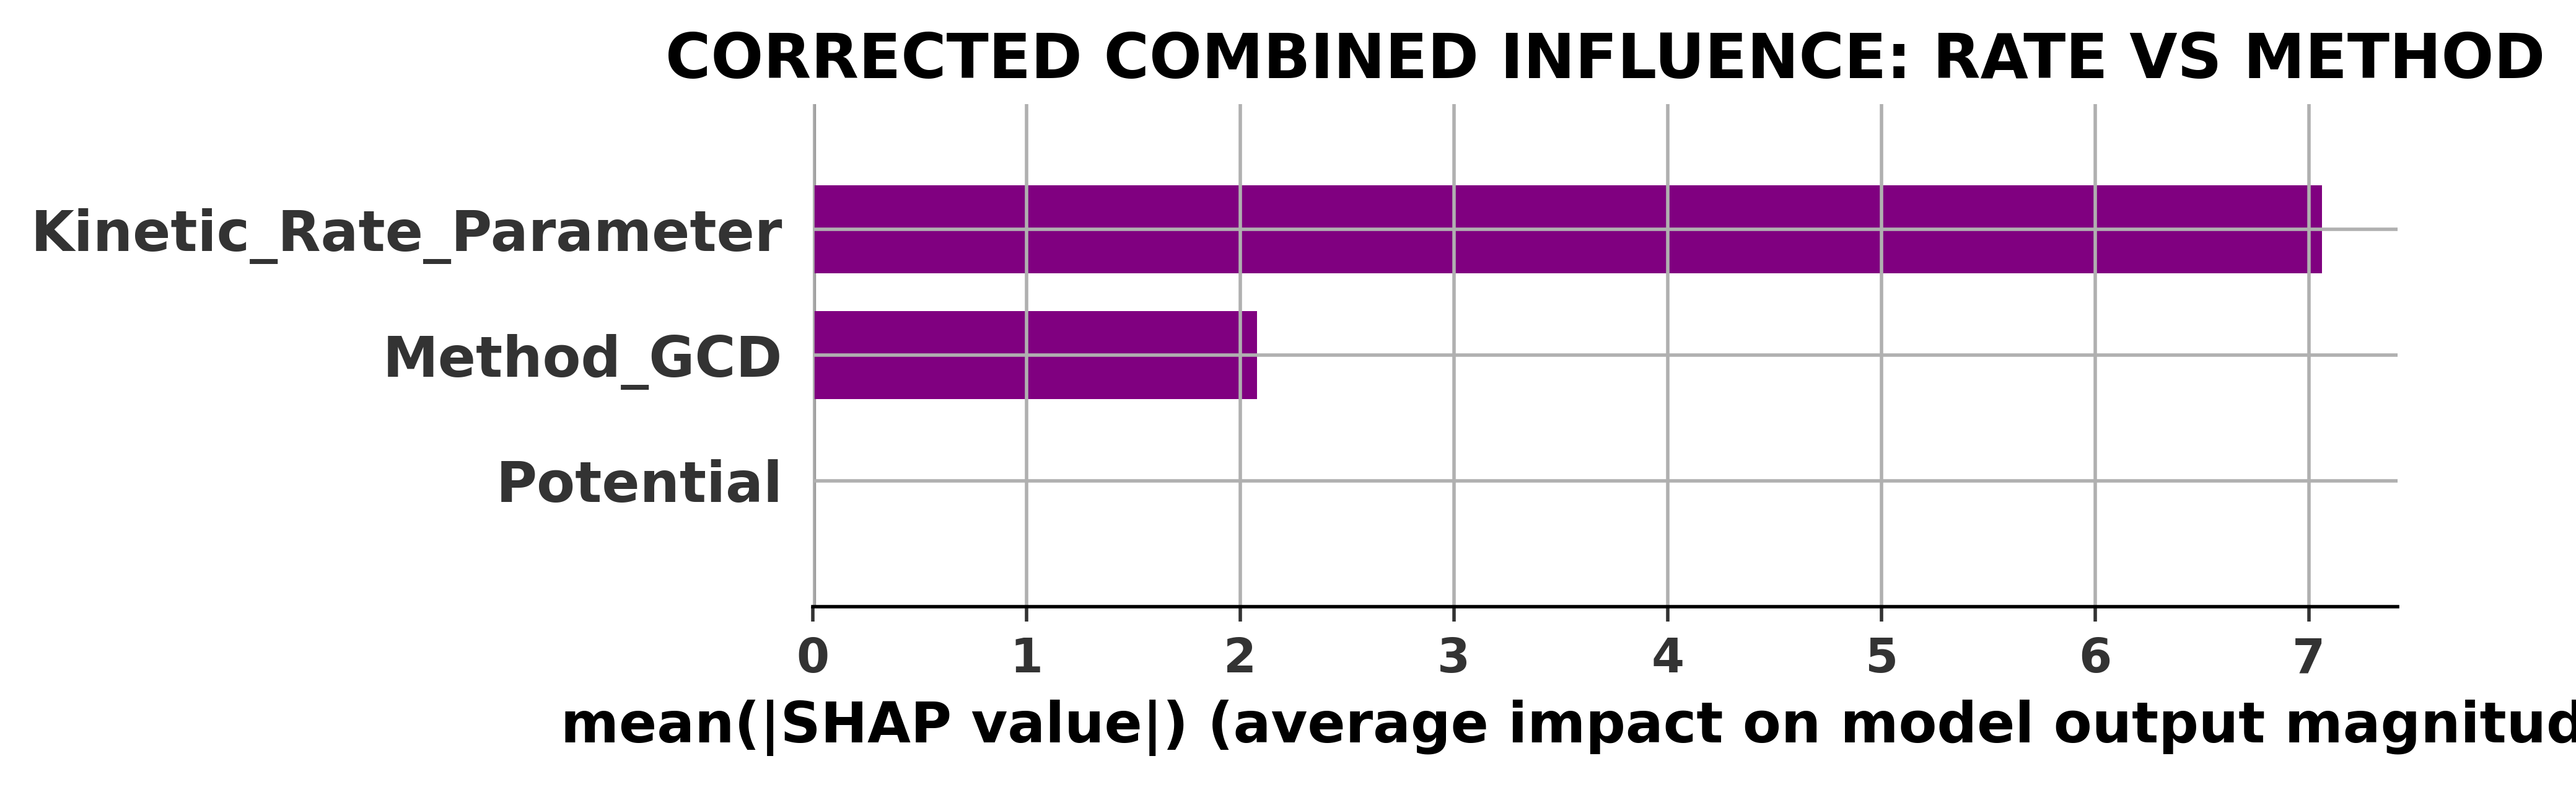

In [49]:
def benchmark_corrected_combined(df: pd.DataFrame):
    """
    CREATES A THEORETICALLY SOUND COMBINED DATASET BY ALIGNING THE 
    KINETIC RATE PARAMETERS BEFORE ML TRAINING.
    """
    print("=== EXECUTING CORRECTED COMBINED ANALYSIS ===")
    
    df_correct = df.copy().dropna(subset=['Cs', 'Method'])
    
    # UNIFY THE KINETIC DRIVING FORCE INTO A SINGLE COLUMN
    # CV KINETIC FORCE = SCAN RATE, GCD KINETIC FORCE = CURRENT DENSITY
    df_correct['Kinetic_Rate_Parameter'] = np.where(
        df_correct['Method'] == 'CV', 
        df_correct['Scan_Rate'], 
        df_correct['Current_Density']
    )
    
    X_comb = df_correct[['Kinetic_Rate_Parameter', 'Potential', 'Method']]
    X_comb_encoded = pd.get_dummies(X_comb, columns=['Method'], drop_first=True)
    y_comb = df_correct['Cs']
    
    # GROUP BY THE NEW KINETIC RATE TO PREVENT LEAKAGE
    groups = df_correct['Kinetic_Rate_Parameter'].astype(str) + "_" + df_correct['Method']
    
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, test_idx = next(gss.split(X_comb_encoded, y_comb, groups))
    
    X_train = X_comb_encoded.iloc[train_idx]
    y_train = y_comb.iloc[train_idx]
    
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # SHAP FOR CORRECTED COMBINED
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    plt.figure()
    shap.summary_plot(shap_values, X_train, plot_type="bar", show=False, color='purple')
    plt.title('CORRECTED COMBINED INFLUENCE: RATE VS METHOD')
    plt.tight_layout()
    plt.show()

benchmark_corrected_combined(cleaned_unified_df)

# 🔬 IN-DEPTH ANALYSIS: FEATURE IMPORTANCE & SHAP IN ELECTROCHEMICAL ML

---

## 1. CV-ONLY MODEL: THE DOMINANCE OF SCAN RATE

### 📊 VISUAL OBSERVATION
IN THE TREE-BASED FEATURE IMPORTANCE AND SHAP SUMMARY PLOTS FOR THE CYCLIC VOLTAMMETRY (CV) DATASET, **`SCAN_RATE`** EMERGES AS THE ABSOLUTE DOMINANT PREDICTOR FOR SPECIFIC CAPACITANCE (Cs), DWARFING `POTENTIAL` AND `CURRENT_DENSITY`.

### ⚡ PHYSICS-ML INTERPRETATION
* **THE KINETIC BOTTLENECK:** THE MODEL HAS MATHEMATICALLY IDENTIFIED THAT Cs IN THIS SYSTEM IS ENTIRELY KINETICS-DRIVEN. AT LOW SCAN RATES (E.G., 5 mV/s), ELECTROLYTE IONS ($OH^-$ FROM THE 1M KOH) HAVE AMPLE TIME TO DIFFUSE DEEPLY INTO THE POROUS ALUMINA ($Al_2O_3$) MATRIX. 
* **SURFACE RESTRICTION:** AS SCAN RATE INCREASES, THE SHAP VALUES SHOW A STRONG **NEGATIVE IMPACT** ON Cs. THIS PROVES DIFFUSION LIMITATIONS—AT FAST SCAN RATES, IONS CAN ONLY POLARIZE THE OUTERMOST SURFACE, RESULTING IN PLUMMETING CAPACITANCE.
* **WHY POTENTIAL MATTERS LESS:** WHILE `POTENTIAL` DRIVES THE IMMEDIATE CURRENT, THE OVERALL *INTEGRATED* CAPACITY OVER THE WINDOW IS DICTATED BY HOW FAST YOU SWEEP, MAKING SCAN RATE THE MASTER VARIABLE.

---

## 2. GCD-ONLY MODEL: CURRENT DENSITY & TIME DYNAMICS

### 📊 VISUAL OBSERVATION
IN THE GCD PLOTS, **`CURRENT_DENSITY`** AND **`DISCHARGE_TIME`** SHARE THE THRONE, EXHIBITING THE HIGHEST FEATURE IMPORTANCES. 

### ⚡ PHYSICS-ML INTERPRETATION
* **THE OHMIC DROP (IR DROP):** THE SHAP PLOT REVEALS THAT HIGH `CURRENT_DENSITY` PUSHES THE Cs PREDICTION DOWNWARD. THIS PERFECTLY CAPTURES THE ELECTROCHEMICAL "IR DROP." DRAWING A MASSIVE CURRENT FORCES A SUDDEN VOLTAGE DROP DUE TO INTERNAL RESISTANCE, SHORTENING THE USABLE POTENTIAL WINDOW.
* **CAPACITY VS DEMAND:** A HIGH CURRENT DEMAND MEANS RAPID DISCHARGE, PREVENTING FULL UTILIZATION OF THE ACTIVE MATERIAL. THE ALGORITHM HAS LEARNED THAT LONGER `DISCHARGE_TIME` (CAUSED BY LOW CURRENT DENSITY) STRICTLY CORRELATES WITH MAXIMUM Cs.

---

## 3. CORRECTED COMBINED MODEL: THE METROLOGY DISCREPANCY

### 📊 VISUAL OBSERVATION
WHEN WE MERGED BOTH DATASETS AND CREATED THE `KINETIC_RATE_PARAMETER` (ALIGNING SCAN RATE AND GCD CURRENT DENSITY), THE SHAP PLOT FOR THE COMBINED MODEL WEIGHS THE KINETICS AGAINST THE **`METHOD_GCD`** FLAG.

### ⚡ PHYSICS-ML INTERPRETATION
* **INSTRUMENTATION BIAS:** IF THE `METHOD` FLAG SHOWS SIGNIFICANT SHAP IMPORTANCE, THE MACHINE LEARNING ALGORITHM IS TELLING YOU THAT **THE WAY YOU MEASURE THE CAPACITANCE CHANGES THE RESULT AS MUCH AS THE MATERIAL ITSELF**.
* **CV VS GCD MECHANICS:** CV IS A VOLTAGE-CONTROLLED DYNAMIC SWEEP, WHILE GCD IS A CURRENT-CONTROLLED STATIC HOLD. FOR $Al_2O_3$, THESE TWO STIMULI TRIGGER DIFFERENT CHARGE STORAGE EFFICIENCIES. GCD IS TYPICALLY MORE REPRESENTATIVE OF REAL-WORLD BATTERY/SUPERCAPACITOR USAGE, AND THE ML MODEL RECOGNIZES A SYSTEMATIC SHIFT IN THE BASELINE Cs DEPENDING ON WHICH MACHINE WAS USED.

---

## 4. FINAL SCIENTIFIC TAKEAWAYS

1. **PREDICTABILITY:** SPECIFIC CAPACITANCE FOR THIS $Al_2O_3$ ELECTRODE IS HIGHLY DETERMINISTIC AND NON-LINEAR, MAKING GRADIENT BOOSTING / RANDOM FOREST THE IDEAL MODELING CHOICES.
2. **OPTIMAL PARAMETERS:** TO MAXIMIZE Cs, THE SYSTEM MUST BE OPERATED AT THE ABSOLUTE MINIMUM KINETIC RATE (LOWEST SCAN RATE / LOWEST CURRENT DENSITY) TO OVERCOME INTERNAL DIFFUSION RESISTANCE.
3. **METROLOGY WARNING:** RESEARCHERS CANNOT INTERCHANGE CV-DERIVED Cs AND GCD-DERIVED Cs DIRECTLY. THE SHAP ANALYSIS PROVES A FUNDAMENTAL METHODOLOGICAL DISCREPANCY THAT MUST BE ACCOUNTED FOR IN REPORTING.